In [1]:
import numpy as np
from scipy.special import iv, kv
from scipy.optimize import minimize
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import yfinance as yf
from scipy.stats import skew, kurtosis, norm, genpareto
from scipy.integrate import quad
import seaborn as sns


# The Model

[*********************100%***********************]  1 of 1 completed


Mean: 0.0004699812377682979
Variance: 0.00018209600083690455
Skewness: -0.8200195298029691
Kurtosis: 14.15327131723786
Initial parameter estimates:
alpha: 111.158085
beta: -11.115808
mu: 0.000470
delta: 0.009446
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3833.657396841253
            Iterations: 14
            Function evaluations: 79
            Gradient evaluations: 14
NIG Model Calibration Results:
alpha: 54.276863
beta: -6.355776
mu: 0.001523
delta: 0.008932
Optimization success: True
Final neg log likelihood: -3833.657397


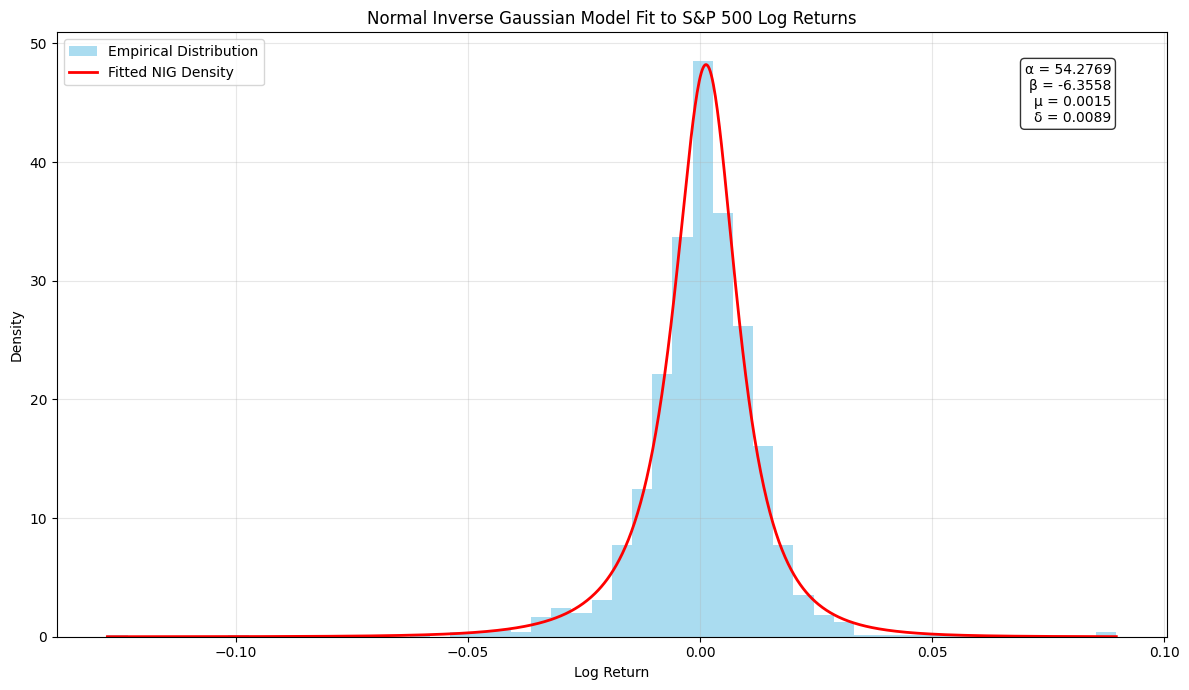

In [2]:
def nig_pdf(x, alpha, beta, mu, delta):
    """
    Normal Inverse Gaussian PDF implementation
    """
    # Validate parameters
    if alpha <= 0 or delta <= 0 or abs(beta) >= alpha:
        return np.zeros_like(x) + 1e-10

    # Calculate constants
    gamma = np.sqrt(alpha**2 - beta**2)

    # Calculate PDF
    term1 = alpha * delta / np.pi
    term2 = np.exp(delta * gamma + beta * (x - mu))
    term3 = kv(1, alpha * np.sqrt(delta**2 + (x - mu)**2))
    term4 = np.sqrt(delta**2 + (x - mu)**2)

    # Handle potential numerical issues
    term3 = np.where(np.isfinite(term3), term3, 1e-10)
    term4 = np.maximum(term4, 1e-10)

    density = term1 * term2 * term3 / term4

    return np.maximum(density, 1e-10)

def neg_log_likelihood(params, data):
    """
    Negative log-likelihood function for NIG distribution
    """
    alpha, beta, mu, delta = params

    # Early exit for invalid parameters
    if alpha <= 0 or delta <= 0 or abs(beta) >= alpha:
        return 1e30

    # Calculate pdf values
    pdf_vals = np.array([nig_pdf(x, alpha, beta, mu, delta) for x in data])
    pdf_vals = np.maximum(pdf_vals, 1e-10)

    # Return negative log-likelihood
    nll = -np.sum(np.log(pdf_vals))

    return nll if np.isfinite(nll) else 1e30

# Download historical data for the S&P 500 index using its Yahoo ticker "^GSPC"
ticker = "^GSPC"
sp500 = yf.download(ticker, start="2020-01-01", end="2025-01-01", interval="1d", auto_adjust=False)
sp500 = sp500['Close']

# Compute log returns
log_returns = np.log(sp500 / sp500.shift(1)).squeeze().dropna().values

# Initial parameter estimation using method of moments
mean = np.mean(log_returns)
variance = np.var(log_returns)
skewness = skew(log_returns)
kurt = kurtosis(log_returns)  # Already excess kurtosis

print(f"Mean: {mean}")
print(f"Variance: {variance}")
print(f"Skewness: {skewness}")
print(f"Kurtosis: {kurt}")

# Initial parameter estimates for NIG
alpha_est = 1.5 / np.sqrt(variance)  # Control for tail heaviness
beta_est = -0.1 * alpha_est if skewness < 0 else 0.1 * alpha_est  # Control for skewness
delta_est = 0.7 * np.sqrt(variance)  # Scale parameter
mu_est = mean  # Location parameter

# Ensure beta < alpha constraint
beta_est = np.sign(beta_est) * min(abs(beta_est), 0.9 * alpha_est)

init_params = np.array([
    float(alpha_est),   # alpha
    float(beta_est),    # beta
    float(mu_est),      # mu
    float(delta_est)    # delta
])

print("Initial parameter estimates:")
print(f"alpha: {init_params[0]:.6f}")
print(f"beta: {init_params[1]:.6f}")
print(f"mu: {init_params[2]:.6f}")
print(f"delta: {init_params[3]:.6f}")

# Set bounds for parameters (keeping alpha > |beta|)
max_alpha = 100.0
bounds = [
    (0.1, max_alpha),           # alpha must be positive
    (-max_alpha * 0.9, max_alpha * 0.9),  # |beta| < alpha)
    (mean - 0.05, mean + 0.05), # mu bounds (around mean)
    (0.0001, 0.1)               # delta must be positive
]

# Constraint to ensure |beta| < alpha
def beta_lt_alpha(params):
    alpha, beta, _, _ = params
    return alpha - abs(beta) - 1e-5

constraint = {'type': 'ineq', 'fun': beta_lt_alpha}

# Optimize parameters
results = minimize(
    neg_log_likelihood,
    x0=init_params,
    args=(log_returns,),
    method='SLSQP',
    bounds=bounds,
    constraints=[constraint],
    options={'maxiter': 1000, 'disp': True}
)

# Extract results
alpha_hat, beta_hat, mu_hat, delta_hat = results.x
NIG_RESULT_GLOBAL = results.x

print("NIG Model Calibration Results:")
print(f"alpha: {alpha_hat:.6f}")
print(f"beta: {beta_hat:.6f}")
print(f"mu: {mu_hat:.6f}")
print(f"delta: {delta_hat:.6f}")
print(f"Optimization success: {results.success}")
print(f"Final neg log likelihood: {results.fun:.6f}")

# Plot with adjusted y-axis limit
plt.figure(figsize=(12, 7))

# Histogram
plt.hist(log_returns, bins=50, density=True, alpha=0.7,
         color='skyblue', label='Empirical Distribution')

# Fitted NIG density
x_range = np.linspace(min(log_returns), max(log_returns), 1000)
nig_densities = [nig_pdf(x, alpha_hat, beta_hat, mu_hat, delta_hat) for x in x_range]

plt.plot(x_range, nig_densities, 'r-', lw=2, label='Fitted NIG Density')

plt.xlabel('Log Return')
plt.ylabel('Density')
plt.title('Normal Inverse Gaussian Model Fit to S&P 500 Log Returns')
plt.legend()

# Add parameter values
param_text = f'α = {alpha_hat:.4f}\nβ = {beta_hat:.4f}\nμ = {mu_hat:.4f}\nδ = {delta_hat:.4f}'
plt.text(0.95, 0.95, param_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [3]:
# Calculate the log-likelihood for the fitted model
nig_log_likelihood = -results.fun

# Calculate AIC and BIC
n_params = 4  # NIG has 4 parameters
n_observations = len(log_returns)
aic = 2 * n_params - 2 * nig_log_likelihood
bic = n_params * np.log(n_observations) - 2 * nig_log_likelihood

# Print goodness-of-fit metrics
print("\nGoodness-of-fit metrics:")
print(f"Log-likelihood: {nig_log_likelihood:.4f}")
print(f"AIC: {aic:.4f}")
print(f"BIC: {bic:.4f}")

from scipy.stats import norm
norm_params = norm.fit(log_returns)
norm_log_likelihood = np.sum(norm.logpdf(log_returns, *norm_params))
norm_aic = 2 * 2 - 2 * norm_log_likelihood  # Normal has 2 parameters
norm_bic = 2 * np.log(n_observations) - 2 * norm_log_likelihood

print("\nNormal distribution comparison:")
print(f"Normal Log-likelihood: {norm_log_likelihood:.4f}")
print(f"Normal AIC: {norm_aic:.4f}")
print(f"Normal BIC: {norm_bic:.4f}")


Goodness-of-fit metrics:
Log-likelihood: 3833.6574
AIC: -7659.3148
BIC: -7638.7689

Normal distribution comparison:
Normal Log-likelihood: 3628.3930
Normal AIC: -7252.7860
Normal BIC: -7242.5131


<ipython-input-4-1913ef14f003>:25: RuntimeWarning: invalid value encountered in sqrt
  x = mu_ig + (mu_ig**2)*y/(2*lambda_param) - (mu_ig/(2*lambda_param))*np.sqrt(4*mu_ig*lambda_param*y + (mu_ig*y)**2)
<ipython-input-4-1913ef14f003>:36: RuntimeWarning: invalid value encountered in sqrt
  nig_samples = mu + beta*z + np.sqrt(z)*np.random.normal(0, 1, n_samples)


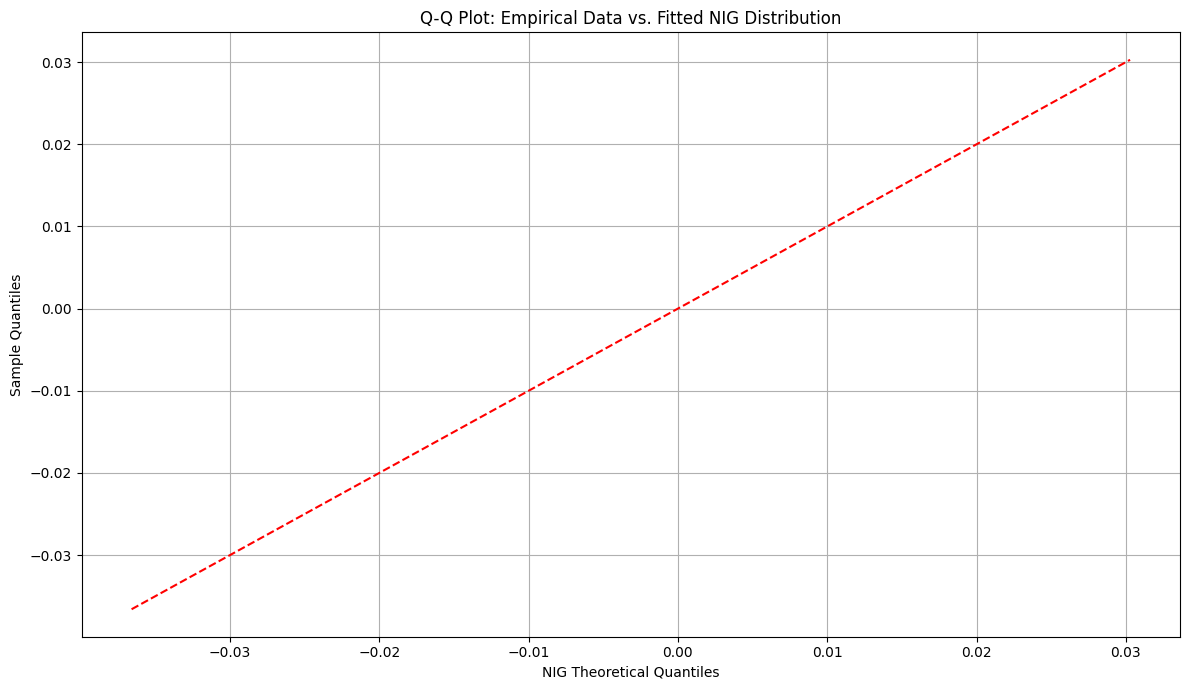

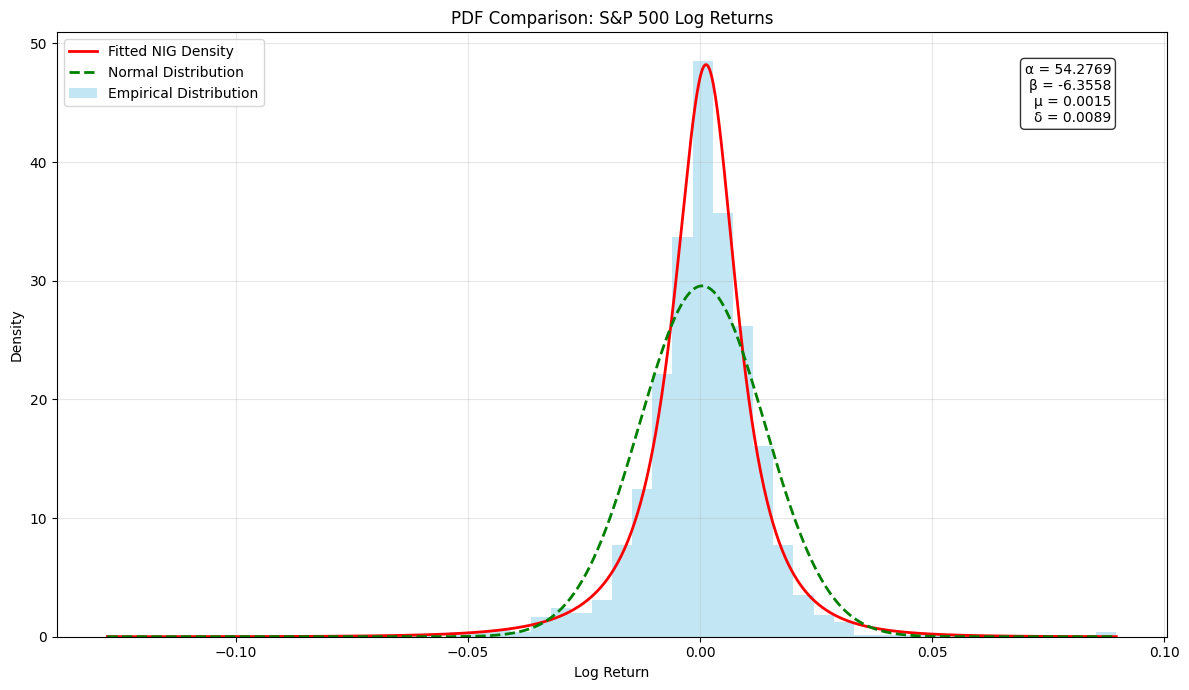

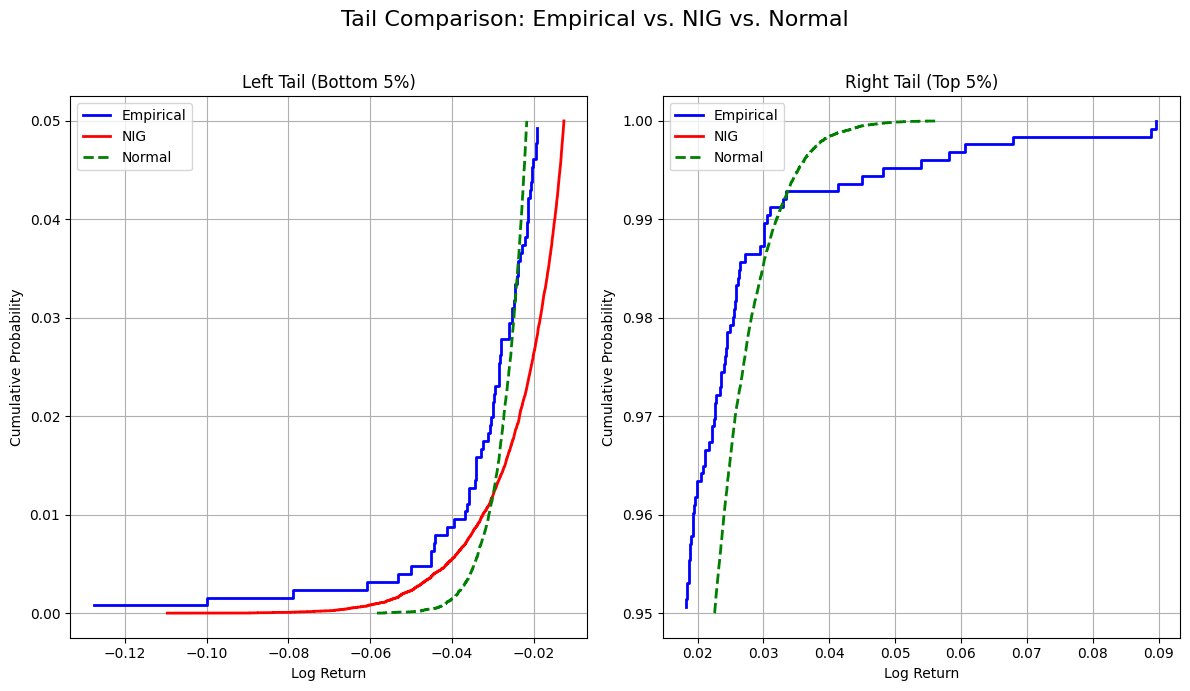

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import kv
from scipy.stats import norm

# NIG random number generation using the property that
# NIG is a normal mean-variance mixture with inverse Gaussian mixing distribution
def simulate_nig_robust(n_samples, alpha, beta, mu, delta):
    """
    Generate random samples from NIG distribution
    """
    lambda_param = delta**2
    mu_ig = delta / np.sqrt(alpha**2 - beta**2)

    # Use rejection sampling for inverse Gaussian
    z = np.zeros(n_samples)
    for i in range(n_samples):
        # Simulate until we get a valid positive value
        valid = False
        while not valid:
            # Generate y ~ N(0,1)
            y = np.random.normal()
            # Calculate candidate x
            x = mu_ig + (mu_ig**2)*y/(2*lambda_param) - (mu_ig/(2*lambda_param))*np.sqrt(4*mu_ig*lambda_param*y + (mu_ig*y)**2)
            # Accept with probability
            u = np.random.uniform()
            if u <= mu_ig/(mu_ig + x):
                z[i] = x
                valid = True
            else:
                z[i] = mu_ig**2/x
                valid = True

    # Generate NIG samples
    nig_samples = mu + beta*z + np.sqrt(z)*np.random.normal(0, 1, n_samples)

    return nig_samples

def plot_improved_qq(data, alpha, beta, mu, delta, n_quantiles=100):
    """
    Create an improved Q-Q plot comparing empirical data to theoretical NIG quantiles
    """
    # Sort the empirical data
    sorted_data = np.sort(data)

    # Generate a large sample from the fitted NIG
    n_sim = 100000
    try:
        sim_data = simulate_nig_robust(n_sim, alpha, beta, mu, delta)
        sorted_sim = np.sort(sim_data)

        # Select quantiles for comparison
        probs = np.linspace(0.01, 0.99, n_quantiles)
        emp_quantiles = np.quantile(sorted_data, probs)
        theo_quantiles = np.quantile(sorted_sim, probs)

        # Create Q-Q plot
        plt.figure(figsize=(12, 7))
        plt.scatter(theo_quantiles, emp_quantiles, alpha=0.7)

        # Add reference line
        min_val = min(np.min(emp_quantiles), np.min(theo_quantiles))
        max_val = max(np.max(emp_quantiles), np.max(theo_quantiles))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')

        # Highlight key quantiles
        key_probs = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
        key_emp = np.quantile(sorted_data, key_probs)
        key_theo = np.quantile(sorted_sim, key_probs)
        plt.scatter(key_theo, key_emp, color='red', s=100, alpha=0.6)

        # Add annotations for key quantiles
        for i, p in enumerate(key_probs):
            plt.annotate(f"{p*100:.0f}%",
                         (key_theo[i], key_emp[i]),
                         xytext=(10, 5),
                         textcoords='offset points')

        plt.xlabel("NIG Theoretical Quantiles")
        plt.ylabel("Sample Quantiles")
        plt.title("Q-Q Plot: Empirical Data vs. Fitted NIG Distribution")
        plt.grid(True)
        plt.tight_layout()
        return plt.gcf()
    except Exception as e:
        print(f"Error in Q-Q plot: {e}")
        return None

def plot_improved_pdf(data, alpha, beta, mu, delta, bins=50):
    """
    Create an improved PDF comparison plot
    """
    try:
        # Create histogram of empirical data
        plt.figure(figsize=(12, 7))
        counts, bin_edges = np.histogram(data, bins=bins, density=True)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Plot histogram
        plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0],
                alpha=0.5, color='skyblue', label='Empirical Distribution')

        # Generate points for the NIG PDF
        x = np.linspace(min(data), max(data), 1000)

        # Calculate NIG PDF values using vectorized approach
        gamma = np.sqrt(alpha**2 - beta**2)
        arg = alpha * np.sqrt(delta**2 + (x - mu)**2)
        bessel_values = kv(1, arg)

        # Replace any problematic values
        bessel_values = np.where(np.isfinite(bessel_values), bessel_values, 1e-10)

        pdf_values = (alpha * delta / np.pi) * np.exp(delta * gamma + beta * (x - mu)) * \
                    bessel_values / np.sqrt(delta**2 + (x - mu)**2)

        # Ensure values are finite
        pdf_values = np.where(np.isfinite(pdf_values), pdf_values, 0)

        # Plot NIG PDF
        plt.plot(x, pdf_values, 'r-', lw=2, label='Fitted NIG Density')

        # Add normal distribution for comparison
        norm_params = norm.fit(data)
        plt.plot(x, norm.pdf(x, *norm_params), 'g--', lw=2, label='Normal Distribution')

        plt.xlabel('Log Return')
        plt.ylabel('Density')
        plt.title('PDF Comparison: S&P 500 Log Returns')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Add parameter values
        param_text = f'α = {alpha:.4f}\nβ = {beta:.4f}\nμ = {mu:.4f}\nδ = {delta:.4f}'
        plt.text(0.95, 0.95, param_text,
                transform=plt.gca().transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        plt.tight_layout()
        return plt.gcf()
    except Exception as e:
        print(f"Error in PDF plot: {e}")
        return None

def plot_tail_comparison(data, alpha, beta, mu, delta):
    """
    Create plots focusing specifically on the tails of the distribution
    """
    try:
        # Sort data
        sorted_data = np.sort(data)
        n = len(sorted_data)

        # Create empirical CDF
        ecdf = np.arange(1, n+1) / n

        # Generate a large sample from the fitted NIG
        n_sim = 100000
        sim_data = simulate_nig_robust(n_sim, alpha, beta, mu, delta)
        sorted_sim = np.sort(sim_data)
        ecdf_sim = np.arange(1, n_sim+1) / n_sim

        # Generate normal for comparison
        norm_params = norm.fit(data)
        norm_data = np.random.normal(norm_params[0], norm_params[1], n_sim)
        sorted_norm = np.sort(norm_data)

        # Create figure with two subplots for left and right tails
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

        # Left tail (focus on bottom 5%)
        left_idx = int(0.05 * n)
        left_idx_sim = int(0.05 * n_sim)

        ax1.step(sorted_data[:left_idx], ecdf[:left_idx], 'b-', where='post', lw=2, label='Empirical')
        ax1.step(sorted_sim[:left_idx_sim], ecdf_sim[:left_idx_sim], 'r-', where='post', lw=2, label='NIG')
        ax1.step(sorted_norm[:left_idx_sim], ecdf_sim[:left_idx_sim], 'g--', where='post', lw=2, label='Normal')

        ax1.set_title('Left Tail (Bottom 5%)')
        ax1.set_xlabel('Log Return')
        ax1.set_ylabel('Cumulative Probability')
        ax1.legend()
        ax1.grid(True)

        # Right tail (focus on top 5%)
        right_idx = int(0.95 * n)
        right_idx_sim = int(0.95 * n_sim)

        ax2.step(sorted_data[right_idx:], ecdf[right_idx:], 'b-', where='post', lw=2, label='Empirical')
        ax2.step(sorted_sim[right_idx_sim:], ecdf_sim[right_idx_sim:], 'r-', where='post', lw=2, label='NIG')
        ax2.step(sorted_norm[right_idx_sim:], ecdf_sim[right_idx_sim:], 'g--', where='post', lw=2, label='Normal')

        ax2.set_title('Right Tail (Top 5%)')
        ax2.set_xlabel('Log Return')
        ax2.set_ylabel('Cumulative Probability')
        ax2.legend()
        ax2.grid(True)

        plt.suptitle('Tail Comparison: Empirical vs. NIG vs. Normal', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.96])

        return fig
    except Exception as e:
        print(f"Error in tail comparison: {e}")
        return None

qq_plot = plot_improved_qq(log_returns, alpha_hat, beta_hat, mu_hat, delta_hat)
pdf_plot = plot_improved_pdf(log_returns, alpha_hat, beta_hat, mu_hat, delta_hat)
tail_plot = plot_tail_comparison(log_returns, alpha_hat, beta_hat, mu_hat, delta_hat)


Hybrid Model Results:
Threshold: 0.014335 (above 90.9% of data)
GPD shape parameter (ξ): 0.483170
GPD scale parameter (σ): 0.004989


<ipython-input-4-1913ef14f003>:25: RuntimeWarning: invalid value encountered in sqrt
  x = mu_ig + (mu_ig**2)*y/(2*lambda_param) - (mu_ig/(2*lambda_param))*np.sqrt(4*mu_ig*lambda_param*y + (mu_ig*y)**2)
<ipython-input-4-1913ef14f003>:36: RuntimeWarning: invalid value encountered in sqrt
  nig_samples = mu + beta*z + np.sqrt(z)*np.random.normal(0, 1, n_samples)
<ipython-input-5-b84e07463cd0>:300: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 0.95, 0.95])



Risk Measures (Hybrid Model):
Confidence: 95.0%
  VaR: -1.7943%
  ES: 0.1792%
Confidence: 99.0%
  VaR: -3.4334%
  ES: -0.0007%
Confidence: 99.9%
  VaR: -9.6260%
  ES: -0.1622%

Risk Measures Comparison (values in %):
Confidence  |  Normal VaR  |  Hybrid VaR  |  Difference
-----------|--------------|--------------|-------------
    95.0%  |      2.1726%  |     -1.7943%  |   -3.9670% (-182.6%)
    99.0%  |      3.0922%  |     -3.4334%  |   -6.5257% (-211.0%)
    99.9%  |      4.1231%  |     -9.6260%  |  -13.7490% (-333.5%)


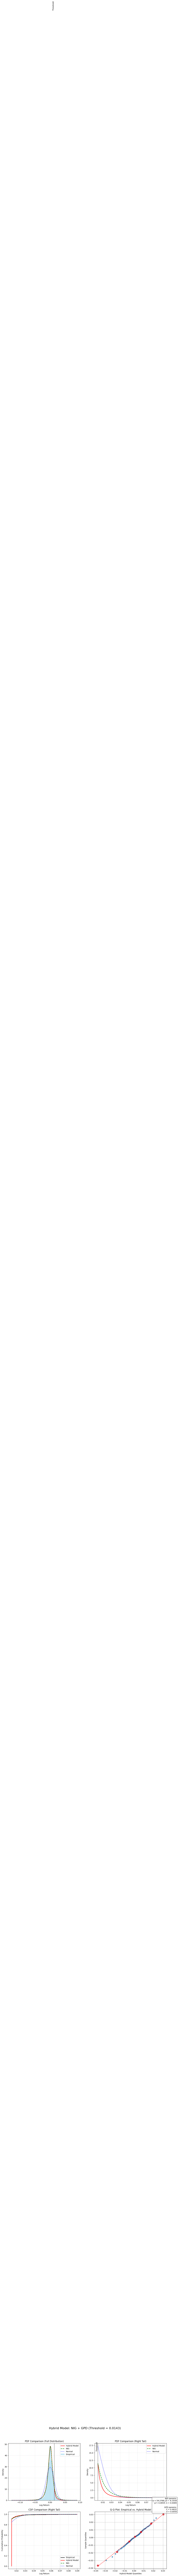

In [5]:
from scipy.stats import genpareto
from scipy import integrate
import numpy as np

def hybrid_model(log_returns, alpha_hat, beta_hat, mu_hat, delta_hat):
    """
    Create a hybrid model using NIG for left tail and middle,
    and Generalized Pareto Distribution (GPD) for right tail
    """
    # 1. Determine the optimal threshold using mean excess plot analysis
    threshold = find_optimal_threshold(log_returns)

    # 2. Fit GPD to exceedances above threshold
    exceedances = log_returns[log_returns > threshold] - threshold
    gpd_params = genpareto.fit(exceedances)

    # 3. Create hybrid PDF and CDF functions
    def hybrid_pdf_func(x):
        return hybrid_pdf(x, alpha_hat, beta_hat, mu_hat, delta_hat, gpd_params, threshold)

    def hybrid_cdf_func(x):
        return hybrid_cdf(x, alpha_hat, beta_hat, mu_hat, delta_hat, gpd_params, threshold)

    return threshold, gpd_params, hybrid_pdf_func, hybrid_cdf_func

def find_optimal_threshold(data, min_percentile=0.90, max_percentile=0.97, steps=15):
    """
    Find optimal threshold for GPD fitting using mean excess plot stability
    """
    # Generate candidate thresholds from percentiles
    percentiles = np.linspace(min_percentile, max_percentile, steps)
    thresholds = [np.quantile(data, p) for p in percentiles]

    # Calculate mean excess for each threshold
    mean_excess = []
    for u in thresholds:
        exceedances = data[data > u] - u
        if len(exceedances) >= 10:
            mean_excess.append(np.mean(exceedances))
        else:
            mean_excess.append(np.nan)

    # Find where mean excess function stabilizes using second differences as approximation
    diffs = np.diff(mean_excess, 2)
    stable_idx = np.argmin(np.abs(diffs)) + 2

    if stable_idx < len(thresholds):
        return thresholds[stable_idx]
    else:
        # Default to 95th percentile if stable point not found
        return np.quantile(data, 0.95)

def hybrid_pdf(x, alpha, beta, mu, delta, gpd_params, threshold, continuity_correction=True):
    """
    Hybrid PDF that uses NIG for left tail and middle, and GPD for right tail
    """
    # Unpack GPD parameters
    gpd_xi, gpd_loc, gpd_scale = gpd_params

    # Make x into a numpy array if it isn't already
    x_array = np.atleast_1d(x)
    result = np.zeros_like(x_array, dtype=float)

    # Calculate NIG density for points <= threshold
    mask_nig = x_array <= threshold
    if np.any(mask_nig):
        result[mask_nig] = nig_pdf(x_array[mask_nig], alpha, beta, mu, delta)

    # Calculate GPD density for points > threshold
    mask_gpd = x_array > threshold
    if np.any(mask_gpd):
        result[mask_gpd] = genpareto.pdf(x_array[mask_gpd] - threshold,
                                         gpd_xi, loc=0, scale=gpd_scale)

    # Ensure continuity at the threshold
    if continuity_correction:
        # Calculate NIG density at threshold
        nig_at_threshold = nig_pdf(threshold, alpha, beta, mu, delta)
        # Calculate GPD density at threshold
        gpd_at_threshold = genpareto.pdf(0, gpd_xi, loc=0, scale=gpd_scale)

        # Apply correction to GPD part
        if np.any(mask_gpd) and gpd_at_threshold > 0:
            correction_factor = nig_at_threshold / gpd_at_threshold
            result[mask_gpd] *= correction_factor

    # If input was a scalar, return a scalar
    if np.isscalar(x):
        return result[0]
    return result

def hybrid_cdf(x, alpha, beta, mu, delta, gpd_params, threshold):
    """
    Hybrid CDF that uses NIG for left tail and middle, and GPD for right tail
    """
    # Unpack GPD parameters
    gpd_xi, gpd_loc, gpd_scale = gpd_params

    # Make x into a numpy array
    x_array = np.atleast_1d(x)
    result = np.zeros_like(x_array, dtype=float)

    # Calculate NIG CDF at threshold
    nig_cdf_at_threshold = numerical_nig_cdf(threshold, alpha, beta, mu, delta)

    # Calculate NIG CDF for points <= threshold
    mask_nig = x_array <= threshold
    if np.any(mask_nig):
        for i, xi in enumerate(x_array[mask_nig]):
            result[mask_nig][i] = numerical_nig_cdf(xi, alpha, beta, mu, delta)

    # Calculate GPD CDF for points > threshold and add NIG CDF at threshold
    mask_gpd = x_array > threshold
    if np.any(mask_gpd):
        result[mask_gpd] = nig_cdf_at_threshold + (1 - nig_cdf_at_threshold) * \
                          genpareto.cdf(x_array[mask_gpd] - threshold,
                                       gpd_xi, loc=0, scale=gpd_scale)

    # If input was a scalar, return a scalar
    if np.isscalar(x):
        return result[0]
    return result

def numerical_nig_cdf(x, alpha, beta, mu, delta, lower_bound=-15):
    """
    Numerically calculate the CDF of NIG distribution at point x
    """
    result, _ = integrate.quad(
        lambda t: nig_pdf(t, alpha, beta, mu, delta),
        lower_bound, x
    )
    return result

def plot_hybrid_model(data, alpha, beta, mu, delta, gpd_params, threshold):
    """
    Plot comparison of hybrid model against empirical data
    """
    # Create a 2x2 grid of subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Plot PDF comparison for entire distribution
    # Create histogram of empirical data
    counts, bin_edges = np.histogram(data, bins=50, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Plot histogram
    ax1.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0],
            alpha=0.5, color='skyblue', label='Empirical')

    # Generate points for PDFs
    x = np.linspace(min(data), max(data), 1000)

    # Calculate hybrid PDF values
    hybrid_pdf_vals = [hybrid_pdf(xi, alpha, beta, mu, delta, gpd_params, threshold)
                       for xi in x]

    # Calculate NIG PDF values
    nig_pdf_vals = [nig_pdf(xi, alpha, beta, mu, delta) for xi in x]

    # Add normal distribution for comparison
    norm_params = norm.fit(data)

    ax1.plot(x, hybrid_pdf_vals, 'r-', lw=2, label='Hybrid Model')
    ax1.plot(x, nig_pdf_vals, 'g--', lw=2, label='NIG')
    ax1.plot(x, norm.pdf(x, *norm_params), 'b:', lw=2, label='Normal')

    # Add vertical line at threshold
    ax1.axvline(x=threshold, color='black', linestyle='-', alpha=0.5)
    ax1.text(threshold, 0.9*max(counts), 'Threshold', rotation=90,
             transform=ax1.get_xaxis_transform(), ha='right')

    ax1.set_title('PDF Comparison (Full Distribution)')
    ax1.set_xlabel('Log Return')
    ax1.set_ylabel('Density')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot right tail PDF zoomed in
    right_mask = x > threshold

    if np.any(right_mask):
        # Find maximum y-value for right tail
        max_y = max([max(np.array(hybrid_pdf_vals)[right_mask]),
                     max(np.array(nig_pdf_vals)[right_mask]),
                     max(norm.pdf(x[right_mask], *norm_params))])

        ax2.plot(x[right_mask], np.array(hybrid_pdf_vals)[right_mask], 'r-', lw=2, label='Hybrid Model')
        ax2.plot(x[right_mask], np.array(nig_pdf_vals)[right_mask], 'g--', lw=2, label='NIG')
        ax2.plot(x[right_mask], norm.pdf(x[right_mask], *norm_params), 'b:', lw=2, label='Normal')

        # Add vertical line at threshold
        ax2.axvline(x=threshold, color='black', linestyle='-', alpha=0.5)
        ax2.text(threshold, 0.9*max_y, 'Threshold', rotation=90, ha='right')

        ax2.set_title('PDF Comparison (Right Tail)')
        ax2.set_xlabel('Log Return')
        ax2.set_ylabel('Density')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    # Plot CDF comparison (right tail)
    sorted_data = np.sort(data)
    n = len(sorted_data)

    # Create empirical CDF
    ecdf = np.arange(1, n+1) / n

    # Right tail indices
    right_idx = np.where(sorted_data > threshold)[0]

    if len(right_idx) > 0:
        ax3.step(sorted_data[right_idx], ecdf[right_idx], 'k-', where='post', lw=2, label='Empirical')

        # Calculate CDFs for models
        x_tail = np.linspace(threshold, max(data), 1000)
        hybrid_cdf_vals = [hybrid_cdf(xi, alpha, beta, mu, delta, gpd_params, threshold) for xi in x_tail]

        # Numerically integrate NIG PDF for CDF
        nig_cdf_vals = []
        for xi in x_tail:
            nig_cdf_vals.append(numerical_nig_cdf(xi, alpha, beta, mu, delta))

        ax3.plot(x_tail, hybrid_cdf_vals, 'r-', lw=2, label='Hybrid Model')
        ax3.plot(x_tail, nig_cdf_vals, 'g--', lw=2, label='NIG')
        ax3.plot(x_tail, norm.cdf(x_tail, *norm_params), 'b:', lw=2, label='Normal')

        ax3.set_title('CDF Comparison (Right Tail)')
        ax3.set_xlabel('Log Return')
        ax3.set_ylabel('Cumulative Probability')
        ax3.legend()
        ax3.grid(True, alpha=0.3)

    # Plot Q-Q plot for the hybrid model
    np.random.seed(42)
    u = np.random.uniform(0, 1, 1000)
    hybrid_sample = []

    # Inverse CDF sampling (approximate)
    for ui in u:
        if ui <= numerical_nig_cdf(threshold, alpha, beta, mu, delta):
            # Sample from NIG using rejection sampling
            while True:
                # Try to sample from region below threshold
                candidate = simulate_nig_robust(1, alpha, beta, mu, delta)[0]
                if candidate <= threshold:
                    hybrid_sample.append(candidate)
                    break
        else:
            # Sample from GPD
            gpd_xi, gpd_loc, gpd_scale = gpd_params
            hybrid_sample.append(threshold + genpareto.ppf(
                (ui - numerical_nig_cdf(threshold, alpha, beta, mu, delta)) /
                (1 - numerical_nig_cdf(threshold, alpha, beta, mu, delta)),
                gpd_xi, loc=0, scale=gpd_scale))

    hybrid_sample = np.array(hybrid_sample)

    # Create Q-Q plot
    sorted_hybrid = np.sort(hybrid_sample)
    sorted_data = np.sort(data)

    # Get quantiles for comparison
    probs = np.linspace(0.01, 0.99, 100)
    emp_quantiles = np.quantile(sorted_data, probs)
    hybrid_quantiles = np.quantile(sorted_hybrid, probs)

    ax4.scatter(hybrid_quantiles, emp_quantiles, alpha=0.7)

    # Add reference line
    min_val = min(np.min(emp_quantiles), np.min(hybrid_quantiles))
    max_val = max(np.max(emp_quantiles), np.max(hybrid_quantiles))
    ax4.plot([min_val, max_val], [min_val, max_val], 'r--')

    # Highlight key quantiles
    key_probs = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
    key_emp = np.quantile(sorted_data, key_probs)
    key_hybrid = np.quantile(sorted_hybrid, key_probs)
    ax4.scatter(key_hybrid, key_emp, color='red', s=100, alpha=0.6)

    ax4.set_title('Q-Q Plot: Empirical vs. Hybrid Model')
    ax4.set_xlabel('Hybrid Model Quantiles')
    ax4.set_ylabel('Sample Quantiles')
    ax4.grid(True)

    # Add overall title
    plt.suptitle(f'Hybrid Model: NIG + GPD (Threshold = {threshold:.4f})', fontsize=16)

    # Add parameter values as text
    gpd_xi, gpd_loc, gpd_scale = gpd_params
    param_text = (f'NIG params:\nα = {alpha:.4f}, β = {beta:.4f}\n'
                  f'μ = {mu:.4f}, δ = {delta:.4f}\n\n'
                  f'GPD params:\nξ = {gpd_xi:.4f}\n'
                  f'σ = {gpd_scale:.4f}')

    fig.text(0.95, 0.5, param_text,
             verticalalignment='center',
             horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout(rect=[0, 0, 0.95, 0.95])
    return fig

# Apply the hybrid model
THRESHOLD_GLOBAL, GPD_PARAMS_GLOBAL, hybrid_pdf_func, hybrid_cdf_func = hybrid_model(
    log_returns, alpha_hat, beta_hat, mu_hat, delta_hat)

print("\nHybrid Model Results:")
print(f"Threshold: {THRESHOLD_GLOBAL:.6f} (above {np.mean(log_returns <= THRESHOLD_GLOBAL)*100:.1f}% of data)")
print(f"GPD shape parameter (ξ): {GPD_PARAMS_GLOBAL[0]:.6f}")
print(f"GPD scale parameter (σ): {GPD_PARAMS_GLOBAL[2]:.6f}")

# Plot hybrid model
hybrid_plot = plot_hybrid_model(log_returns, alpha_hat, beta_hat, mu_hat, delta_hat,
                               GPD_PARAMS_GLOBAL, THRESHOLD_GLOBAL)

# Using the hybrid model to calculate VaR and ES
def calculate_risk_measures(data, alpha, beta, mu, delta, gpd_params, threshold,
                           confidence_levels=[0.95, 0.99, 0.999]):
    """
    Calculate Value-at-Risk (VaR) and Expected Shortfall (ES) using the hybrid model
    """
    results = []

    for cl in confidence_levels:
        # For VaR, we need to find x such that P(X ≤ x) = cl
        # Check if quantile is in NIG or GPD region
        threshold_cdf = numerical_nig_cdf(threshold, alpha, beta, mu, delta)

        if cl <= threshold_cdf:
            # Quantile is in NIG region - use binary search
            def objective(x):
                return numerical_nig_cdf(x, alpha, beta, mu, delta) - cl

            # Binary search for VaR
            left = min(data)
            right = threshold
            for _ in range(20):  # Sufficient iterations for convergence
                mid = (left + right) / 2
                if objective(mid) < 0:
                    left = mid
                else:
                    right = mid
            var = left
        else:
            # Quantile is in GPD region
            gpd_xi, gpd_loc, gpd_scale = gpd_params
            p_exceed = (cl - threshold_cdf) / (1 - threshold_cdf)
            var = threshold + genpareto.ppf(p_exceed, gpd_xi, loc=0, scale=gpd_scale)

        # For ES, we need to calculate E[X | X ≤ VaR]
        es = numerical_expected_shortfall(var, data, alpha, beta, mu, delta,
                                         gpd_params, threshold)
        results.append({
            'confidence': cl * 100,
            'VaR': -var,  # Negative because losses are negative returns
            'ES': -es
        })

    return results

def numerical_expected_shortfall(var, data, alpha, beta, mu, delta, gpd_params, threshold):
    """
    Calculate Expected Shortfall numerically
    """
    # Unpack GPD parameters
    gpd_xi, gpd_loc, gpd_scale = gpd_params

    # If VaR is in NIG region
    if var <= threshold:
        # Compute E[X | X ≤ var] using numerical integration
        def integrand(x):
            return x * nig_pdf(x, alpha, beta, mu, delta)

        integral, _ = integrate.quad(integrand, min(data), var)
        cdf_var = numerical_nig_cdf(var, alpha, beta, mu, delta)

        if cdf_var > 0:
            return integral / cdf_var
        else:
            return var  # Default to VaR if cdf is too small
    else:
        # VaR is in GPD region
        # Use combination of NIG and GPD for ES calculation

        # First part: contribution from NIG region
        def nig_integrand(x):
            return x * nig_pdf(x, alpha, beta, mu, delta)

        nig_integral, _ = integrate.quad(nig_integrand, min(data), threshold)

        # Second part: contribution from GPD region between threshold and VaR
        threshold_cdf = numerical_nig_cdf(threshold, alpha, beta, mu, delta)

        # Adjust the integration
        def gpd_integrand(x):
            # Scale the GPD density by the probability mass above threshold
            density = (1 - threshold_cdf) * genpareto.pdf(x - threshold,
                                                         gpd_xi, loc=0, scale=gpd_scale)
            return (threshold + x) * density

        gpd_integral, _ = integrate.quad(gpd_integrand, 0, var - threshold)

        # Combine and normalize by CDF at VaR
        var_cdf = hybrid_cdf(var, alpha, beta, mu, delta, gpd_params, threshold)

        if var_cdf > 0:
            return (nig_integral + gpd_integral) / var_cdf
        else:
            return var

# Calculate risk measures with the hybrid model
risk_measures = calculate_risk_measures(log_returns, alpha_hat, beta_hat, mu_hat, delta_hat,
                                      GPD_PARAMS_GLOBAL, THRESHOLD_GLOBAL)

print("\nRisk Measures (Hybrid Model):")
for rm in risk_measures:
    print(f"Confidence: {rm['confidence']}%")
    print(f"  VaR: {rm['VaR']*100:.4f}%")
    print(f"  ES: {rm['ES']*100:.4f}%")

# Compare with normal and NIG risk measures
def calculate_normal_risk_measures(data, confidence_levels=[0.95, 0.99, 0.999]):
    """Calculate VaR and ES using normal distribution"""
    norm_params = norm.fit(data)
    results = []

    for cl in confidence_levels:
        var = -norm.ppf(1-cl, *norm_params)
        es = -norm_params[0] + norm_params[1] * norm.pdf(norm.ppf(1-cl)) / (1-cl)

        results.append({
            'confidence': cl * 100,
            'VaR': var * 100,
            'ES': es * 100
        })

    return results

normal_risk = calculate_normal_risk_measures(log_returns)

print("\nRisk Measures Comparison (values in %):")
print("Confidence  |  Normal VaR  |  Hybrid VaR  |  Difference")
print("-----------|--------------|--------------|-------------")
for i, cl in enumerate([0.95, 0.99, 0.999]):
    normal_var = normal_risk[i]['VaR']
    hybrid_var = risk_measures[i]['VaR'] * 100
    diff = hybrid_var - normal_var
    diff_pct = diff / normal_var * 100
    print(f"{cl*100:8.1f}%  |  {normal_var:10.4f}%  |  {hybrid_var:10.4f}%  |  {diff:+8.4f}% ({diff_pct:+.1f}%)")

[*********************100%***********************]  1 of 1 completed


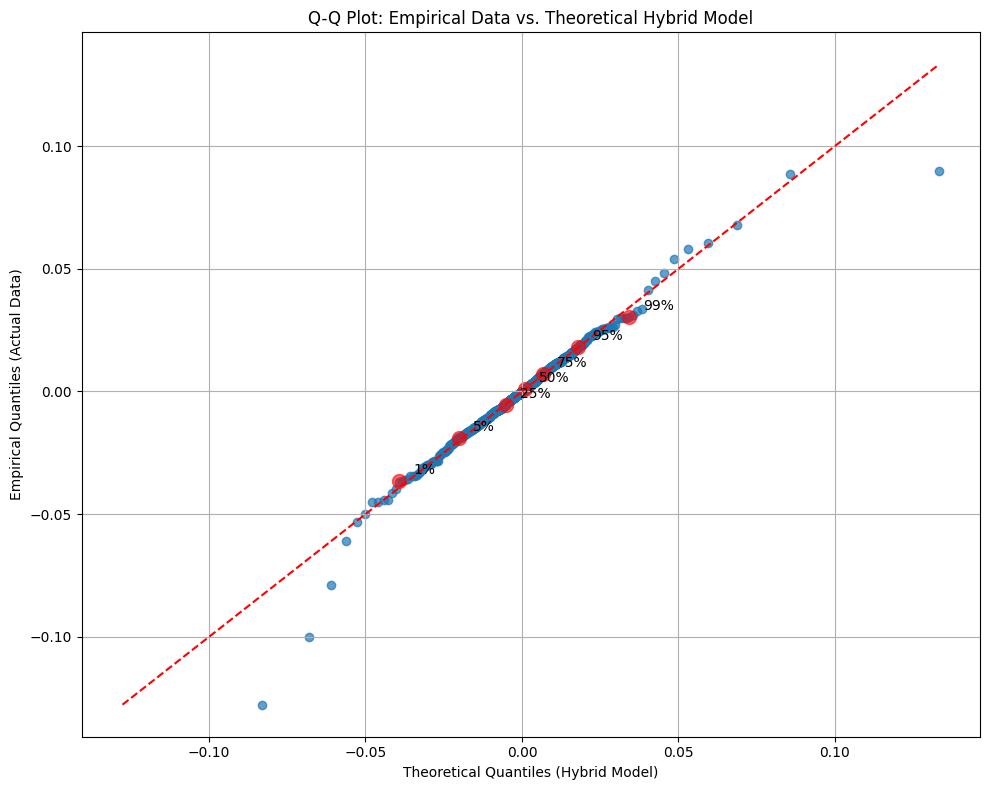

In [8]:
def plot_proper_qq(data, alpha, beta, mu, delta, gpd_params, threshold):
    """
    Create a proper Q-Q plot comparing empirical data to theoretical hybrid model
    """
    # Unpack GPD parameters
    gpd_xi, gpd_loc, gpd_scale = gpd_params

    # Sort the empirical data
    sorted_data = np.sort(data)
    n = len(sorted_data)

    # Calculate empirical probabilities
    prob_points = (np.arange(1, n+1) - 0.375) / (n + 0.25)

    # Calculate corresponding theoretical quantiles from hybrid model
    theo_quantiles = []
    for p in prob_points:
        # If probability is below the threshold in CDF space
        threshold_prob = numerical_nig_cdf(threshold, alpha, beta, mu, delta)

        if p <= threshold_prob:
            # Use binary search to find quantile in NIG region
            def objective(x):
                return numerical_nig_cdf(x, alpha, beta, mu, delta) - p

            # Binary search
            left = -0.2
            right = threshold
            for _ in range(20):
                mid = (left + right) / 2
                if objective(mid) < 0:
                    left = mid
                else:
                    right = mid

            theo_quantiles.append(left)
        else:
            # Use GPD quantile function
            p_exceed = (p - threshold_prob) / (1 - threshold_prob)
            theo_quantiles.append(
                threshold + genpareto.ppf(p_exceed, gpd_xi, loc=0, scale=gpd_scale)
            )

    plt.figure(figsize=(10, 8))
    plt.scatter(theo_quantiles, sorted_data, alpha=0.7)

    # Add reference line
    min_val = min(min(theo_quantiles), min(sorted_data))
    max_val = max(max(theo_quantiles), max(sorted_data))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')

    # Highlight key quantiles
    key_probs = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
    key_empirical = np.quantile(sorted_data, key_probs)
    key_theoretical = []

    for p in key_probs:
        threshold_prob = numerical_nig_cdf(threshold, alpha, beta, mu, delta)
        if p <= threshold_prob:
            # NIG region
            def objective(x):
                return numerical_nig_cdf(x, alpha, beta, mu, delta) - p

            left = -0.2
            right = threshold
            for _ in range(20):
                mid = (left + right) / 2
                if objective(mid) < 0:
                    left = mid
                else:
                    right = mid

            key_theoretical.append(left)
        else:
            # GPD region
            p_exceed = (p - threshold_prob) / (1 - threshold_prob)
            key_theoretical.append(
                threshold + genpareto.ppf(p_exceed, gpd_xi, loc=0, scale=gpd_scale)
            )

    plt.scatter(key_theoretical, key_empirical, color='red', s=100, alpha=0.6)

    # Annotations for key quantiles
    for i, p in enumerate(key_probs):
        plt.annotate(f"{p*100:.0f}%",
                    (key_theoretical[i], key_empirical[i]),
                    xytext=(10, 5),
                    textcoords='offset points')

    plt.xlabel("Theoretical Quantiles (Hybrid Model)")
    plt.ylabel("Empirical Quantiles (Actual Data)")
    plt.title("Q-Q Plot: Empirical Data vs. Theoretical Hybrid Model")
    plt.grid(True)
    plt.tight_layout()

    return plt.gcf()

# Download historical data
ticker = "^GSPC"
sp500 = yf.download(ticker, start="2020-01-01", end="2025-01-01", interval="1d")
sp500 = sp500['Close']

# Compute log returns
log_returns = np.log(sp500 / sp500.shift(1)).squeeze().dropna().values

qq_fig = plot_proper_qq(log_returns, alpha_hat, beta_hat, mu_hat, delta_hat, GPD_PARAMS_GLOBAL,THRESHOLD_GLOBAL)
plt.show()

# Index Volatility Decomposition Analysis

In [9]:
# Define the Magnificent 7 stocks and their tickers
MAG7_TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA']
INDEX_TICKER = "^GSPC"  # S&P 500

# Volatility Decomposition - Magnificent 7 vs. Rest of S&P 500

def download_price_data(tickers, start_date='2020-01-01', end_date='2025-01-01'):
    """Download price data for multiple tickers"""
    all_data = yf.download(tickers, start=start_date, end=end_date)['Close']
    return all_data

def calculate_returns(prices):
    """Calculate log returns from price data"""
    return np.log(prices / prices.shift(1)).dropna()

def get_market_caps(tickers, date=None):
    """Get market caps for a list of tickers"""
    market_caps = {}

    for ticker in tickers:
        stock = yf.Ticker(ticker)
        if date:
            # For historical market cap, would need additional data source
            market_caps[ticker] = stock.info.get('marketCap', 0)
        else:
            market_caps[ticker] = stock.info.get('marketCap', 0)

    return market_caps

def calculate_index_weights(market_caps, total_market_cap=None):
    """Calculate index weights based on market caps"""
    if total_market_cap is None:
        total_market_cap = sum(market_caps.values())

    weights = {ticker: cap / total_market_cap for ticker, cap in market_caps.items()}
    return weights

def decompose_index_volatility(returns, weights):
    """
    Decompose the index volatility into components from individual stocks
    Uses the fact that Var(∑w_i X_i) = ∑∑w_i w_j Cov(X_i, X_j)
    """
    # Annualized covariance matrix
    cov_matrix = returns.cov() * 252

    # Initialize containers for volatility contribution
    vol_contribution = {}

    # Calculate total volatility
    portfolio_var = 0
    for i in weights:
        for j in weights:
            if i in cov_matrix.index and j in cov_matrix.columns:
                portfolio_var += weights[i] * weights[j] * cov_matrix.loc[i, j]

    portfolio_vol = np.sqrt(portfolio_var)

    # Calculate contribution of each stock to the overall volatility
    for ticker in weights:
        if ticker in cov_matrix.index:
            marginal_contrib = 0
            for j in weights:
                if j in cov_matrix.columns:
                    marginal_contrib += weights[j] * cov_matrix.loc[ticker, j]

            vol_contribution[ticker] = weights[ticker] * marginal_contrib / portfolio_vol

    # Calculate betas for each stock relative to the index
    betas = {}
    index_var = returns[INDEX_TICKER].var() * 252

    for ticker in weights:
        if ticker in returns.columns and ticker != INDEX_TICKER:
            cov_with_index = returns[[ticker, INDEX_TICKER]].cov().iloc[0, 1] * 252
            betas[ticker] = cov_with_index / index_var

    return {
        'total_volatility': portfolio_vol,
        'contributions': vol_contribution,
        'betas': betas
    }

# Option Pricing with the Hybrid Model

def numerical_nig_cdf_optimized(x, alpha, beta, mu, delta, cache={}):
    """Optimized version of numerical_nig_cdf with caching"""
    # Create a cache key based on parameters and x
    key = (round(x, 4), round(alpha, 4), round(beta, 4), round(mu, 4), round(delta, 4))

    # Check if result is in cache
    if key in cache:
        return cache[key]

    # If not in cache, call the original function
    result = numerical_nig_cdf(x, alpha, beta, mu, delta)

    # Store in cache for future use
    cache[key] = result

    return result

def hybrid_monte_carlo(S, K, r, T, nig_params, gpd_params, threshold, n_simulations=100000, option_type='call'):
    """Price a European option using the hybrid model with Monte Carlo simulation"""
    np.random.seed(42)

    # Generate all random numbers at once
    u = np.random.uniform(0, 1, n_simulations)
    nig_cdf_at_threshold = numerical_nig_cdf_optimized(threshold, *nig_params)

    # Create array for hybrid samples
    hybrid_samples = np.zeros(n_simulations)

    # Identify which samples come from which distribution
    mask_nig = u <= nig_cdf_at_threshold
    mask_gpd = ~mask_nig

    # Process NIG samples in vectorized form if possible
    if np.any(mask_nig):
        alpha, beta, mu, delta = nig_params
        u_nig = u[mask_nig] / nig_cdf_at_threshold

        # Precompute NIG CDF values for a range of points
        x_grid = np.linspace(-10.0, threshold, 1000)
        cdf_grid = np.array([numerical_nig_cdf_optimized(x, alpha, beta, mu, delta) for x in x_grid]) / nig_cdf_at_threshold

        # Use interpolation
        hybrid_samples[mask_nig] = np.interp(u_nig, cdf_grid, x_grid)

    # Process GPD samples - already efficient using vectorized operations
    if np.any(mask_gpd):
        gpd_xi, gpd_loc, gpd_scale = gpd_params
        u_gpd = (u[mask_gpd] - nig_cdf_at_threshold) / (1 - nig_cdf_at_threshold)
        gpd_samples = genpareto.ppf(u_gpd, gpd_xi, loc=0, scale=gpd_scale)
        hybrid_samples[mask_gpd] = threshold + gpd_samples

    # Calculate terminal stock prices (vectorized operations)
    hybrid_mean = np.mean(hybrid_samples)
    risk_neutral_drift = r - hybrid_mean - 0.5 * np.var(hybrid_samples)
    S_T = S * np.exp(risk_neutral_drift * T + np.sqrt(T) * hybrid_samples)

    # Calculate option payoffs (vectorized)
    if option_type.lower() == 'call':
        payoffs = np.maximum(S_T - K, 0)
    else:  # Put option
        payoffs = np.maximum(K - S_T, 0)

    # Discount payoffs to present value
    option_price = np.exp(-r * T) * np.mean(payoffs)

    return option_price

def compute_iv(args):
    """Worker function for calculating implied volatility at a specific point"""
    idx, T, K, S, r, nig_params, gpd_params, threshold = args
    option_price = hybrid_monte_carlo(S, K, r, T, nig_params, gpd_params, threshold)
    return implied_volatility(option_price, S, K, r, T)

def calculate_iv_surface(S, r, T_range, K_range, model_params, pricing_func):
    """Calculate implied volatility surface using the given model with parallel processing"""
    # Unpack parameters
    nig_params, threshold, gpd_params = model_params

    # Create mesh grid for parallel computation
    T_mesh, K_mesh = np.meshgrid(T_range, K_range, indexing='ij')
    iv_surface = np.zeros_like(T_mesh)

    # Use parallel processing
    from concurrent.futures import ProcessPoolExecutor
    import multiprocessing

    num_cores = multiprocessing.cpu_count()

    # Flatten the mesh grids for parallel processing
    T_flat = T_mesh.flatten()
    K_flat = K_mesh.flatten()
    iv_flat = np.zeros_like(T_flat)

    # Prepare arguments for parallel processing
    args_list = [(idx, T_flat[idx], K_flat[idx], S, r, nig_params, gpd_params, threshold)
                for idx in range(len(T_flat))]

    # Run parallel computation
    with ProcessPoolExecutor(max_workers=num_cores) as executor:
        results = list(executor.map(compute_iv, args_list))

    # Reshape results back to original shape
    iv_surface = np.array(results).reshape(T_mesh.shape)

    return iv_surface

# Optimized implied volatility calculation
def implied_volatility(option_price, S, K, r, T, option_type='call', precision=0.001):
    """Calculate implied volatility using Newton-Raphson method for faster convergence"""
    from scipy.stats import norm

    def bs_price(sigma):
        d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        if option_type.lower() == 'call':
            return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        else:  # Put option
            return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    def bs_vega(sigma):
        d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        return S * np.sqrt(T) * norm.pdf(d1)

    # Initial guess
    sigma = 0.2

    # Newton-Raphson iterations
    for _ in range(10):
        price_diff = bs_price(sigma) - option_price

        if abs(price_diff) < precision:
            break
        # Prevent division by zero
        vega = bs_vega(sigma)
        if abs(vega) < 1e-10:
            vega = 1e-10

        # Update sigma using Newton-Raphson formula
        sigma = sigma - price_diff / vega

        # Ensure sigma stays within reasonable bounds
        sigma = max(0.001, min(2.0, sigma))

    return sigma

def analyze_real_shock_to_mag7(returns, weights, shock_period_start, shock_period_end):
    """Analyze a real historical shock to the Magnificent 7 stocks and its effect on index volatility"""
    # Get pre-shock period for baseline
    pre_shock_period = returns.loc[:shock_period_start].iloc[:-1]
    shock_period = returns.loc[shock_period_start:shock_period_end]

    # Calculate volatility before shock
    pre_shock_vol_decomp = decompose_index_volatility(pre_shock_period, weights)
    pre_shock_vol = pre_shock_vol_decomp['total_volatility']

    # Calculate volatility during shock
    shock_vol_decomp = decompose_index_volatility(shock_period, weights)
    shock_vol = shock_vol_decomp['total_volatility']

    # Calculate percentage increase in volatility
    vol_increase_pct = (shock_vol - pre_shock_vol) / pre_shock_vol * 100

    return {
        'original_volatility': pre_shock_vol,
        'shocked_volatility': shock_vol,
        'volatility_increase_pct': vol_increase_pct,
        'original_decomposition': pre_shock_vol_decomp['contributions'],
        'shocked_decomposition': shock_vol_decomp['contributions'],
        'original_betas': pre_shock_vol_decomp['betas'],
        'shocked_betas': shock_vol_decomp['betas']
    }

def fit_hybrid_model(log_returns):
    """
    Fit a hybrid model to log returns data using existing functions:
    """
    # Initial parameter estimates using method of moments
    mean = np.mean(log_returns)
    variance = np.var(log_returns)
    skewness = skew(log_returns)
    kurt = kurtosis(log_returns)  # Already excess kurtosis

    # Initial parameter estimates for NIG
    alpha_est = 1.5 / np.sqrt(variance)  # Control for tail heaviness
    beta_est = -0.1 * alpha_est if skewness < 0 else 0.1 * alpha_est  # Control for skewness
    delta_est = 0.7 * np.sqrt(variance)  # Scale parameter
    mu_est = mean  # Location parameter

    # Beta < alpha constraint
    beta_est = np.sign(beta_est) * min(abs(beta_est), 0.9 * alpha_est)

    init_params = np.array([
        float(alpha_est),
        float(beta_est),
        float(mu_est),
        float(delta_est)
    ])

    # Set bounds for parameters
    max_alpha = 100.0
    bounds = [
        (0.1, max_alpha),           # alpha bounds (must be positive)
        (-max_alpha * 0.9, max_alpha * 0.9),  # beta bounds (must be |beta| < alpha)
        (mean - 0.05, mean + 0.05), # mu bounds (around mean)
        (0.0001, 0.1)               # delta bounds (must be positive)
    ]

    # 4. Ensure |beta| < alpha
    def beta_lt_alpha(params):
        alpha, beta, _, _ = params
        return alpha - abs(beta) - 1e-5  # Must be positive

    constraint = {'type': 'ineq', 'fun': beta_lt_alpha}

    # 5. Optimize parameters
    results = minimize(
        neg_log_likelihood,
        x0=init_params,
        args=(log_returns,),
        method='SLSQP',
        bounds=bounds,
        constraints=[constraint],
        options={'maxiter': 1000, 'disp': False}
    )

    # Extract NIG results
    alpha_hat, beta_hat, mu_hat, delta_hat = results.x
    nig_params = results.x

    # Use existing hybrid_model function to get threshold and fit GPD
    threshold, gpd_params, _, _ = hybrid_model(
        log_returns, alpha_hat, beta_hat, mu_hat, delta_hat
    )

    return nig_params, threshold, gpd_params

# Part 3: Main Analysis

def main():
    # Load data
    print("Downloading price data...")
    all_tickers = MAG7_TICKERS + [INDEX_TICKER]
    price_data = download_price_data(all_tickers)

    # Calculate returns
    returns = calculate_returns(price_data)

    # Get market caps and calculate weights
    print("Calculating index weights...")
    market_caps = get_market_caps(MAG7_TICKERS)

    # Add a synthetic entry for the rest of S&P 500
    mag7_total_cap = sum(market_caps.values())
    sp500_approx_cap = 45_000_000_000_000  # $45T approximate for S&P 500 total market cap
    market_caps['OTHER'] = sp500_approx_cap - mag7_total_cap

    # Calculate weights
    weights = calculate_index_weights(market_caps)
    print("Weights:", weights)

    # Create a series for 'OTHER' returns (approximate)
    if 'OTHER' not in returns.columns:
        # Estimate the returns of the non-Magnificent 7 stocks
        sp500_returns = returns[INDEX_TICKER].values
        weighted_mag7_returns = sum(weights[ticker] * returns[ticker].values
                                   for ticker in MAG7_TICKERS if ticker in returns.columns)

        # Calculate the implied return of other stocks
        other_weight = weights['OTHER']
        if other_weight > 0:
            other_returns = (sp500_returns - weighted_mag7_returns) / other_weight
            returns['OTHER'] = other_returns

    # Decompose volatility
    print("Decomposing index volatility...")
    vol_decomp = decompose_index_volatility(returns, weights)

    index_returns = returns[INDEX_TICKER].dropna().values

    # Shock to Magnificent 7
    print("Analyzing real shock to Magnificent 7...")
    # 2022 tech drawdown period
    covid_shock_result = analyze_real_shock_to_mag7(returns, weights, '2020-02-15', '2020-03-23')
    tech_drawdown_result = analyze_real_shock_to_mag7(returns, weights, '2022-01-01', '2022-06-30')
    tesla_shock_result = analyze_real_shock_to_mag7(returns, weights, '2022-10-01', '2022-12-31')

    post_covid_shock_index_returns = returns[INDEX_TICKER].loc['2020-02-15':'2020-03-23'].dropna().values
    post_tech_shock_index_returns = returns[INDEX_TICKER].loc['2022-01-01':'2022-06-30'].dropna().values
    post_tesla_shock_index_returns = returns[INDEX_TICKER].loc['2022-10-01':'2022-12-31'].dropna().values

    # Calculate implied volatility surface
    print("Calculating implied volatility surface...")
    S = 5000  # Approximate S&P 500 level
    r = 0.05  # Risk-free rate
    T_range = np.array([1/12, 3/12, 6/12, 1.0])  # Maturities: 1m, 3m, 6m, 1y
    K_range = np.linspace(0.8 * S, 1.2 * S, 20)  # Strike prices

    model_params = (NIG_RESULT_GLOBAL, THRESHOLD_GLOBAL, GPD_PARAMS_GLOBAL)
    iv_surface = calculate_iv_surface(S, r, T_range, K_range, model_params, hybrid_monte_carlo)

    # Calculate implied volatility surface after shock
    covid_shocked_index_returns = index_returns * np.sqrt(covid_shock_result['shocked_volatility'] /
                                                   covid_shock_result['original_volatility'])
    tech_shocked_index_returns = index_returns * np.sqrt(tech_drawdown_result['shocked_volatility'] /
                                              tech_drawdown_result['original_volatility'])
    tesla_shocked_index_returns = index_returns * np.sqrt(tesla_shock_result['shocked_volatility'] /
                                          tesla_shock_result['original_volatility'])

    covid_shocked_nig_params, covid_shocked_threshold, covid_shocked_gpd_params = fit_hybrid_model(covid_shocked_index_returns)
    tech_shocked_nig_params, tech_shocked_threshold, tech_shocked_gpd_params = fit_hybrid_model(tech_shocked_index_returns)
    tesla_shocked_nig_params, tesla_shocked_threshold, tesla_shocked_gpd_params = fit_hybrid_model(tesla_shocked_index_returns)

    covid_shocked_model_params = (covid_shocked_nig_params, covid_shocked_threshold, covid_shocked_gpd_params)
    tech_shocked_model_params = (tech_shocked_nig_params, tech_shocked_threshold, tech_shocked_gpd_params)
    tesla_shocked_model_params = (tesla_shocked_nig_params, tesla_shocked_threshold, tesla_shocked_gpd_params)

    covid_shocked_iv_surface = calculate_iv_surface(S, r, T_range, K_range, covid_shocked_model_params, hybrid_monte_carlo)
    tech_shocked_iv_surface = calculate_iv_surface(S, r, T_range, K_range, tech_shocked_model_params, hybrid_monte_carlo)
    tesla_shocked_iv_surface = calculate_iv_surface(S, r, T_range, K_range, tesla_shocked_model_params, hybrid_monte_carlo)

    return {
        'weights': weights,
        'returns': returns,
        'index_returns': index_returns,
        'vol_decomp': vol_decomp,
        'nig_params': NIG_RESULT_GLOBAL,
        'threshold': THRESHOLD_GLOBAL,
        'gpd_params': GPD_PARAMS_GLOBAL,
        'covid_shock_result': covid_shock_result,
        'tech_shock_result': tech_drawdown_result,
        'tesla_shock_result': tesla_shock_result,
        'iv_surface': iv_surface,
        'covid_shocked_iv_surface': covid_shocked_iv_surface,
        'tech_shocked_iv_surface': tech_shocked_iv_surface,
        'tesla_shocked_iv_surface': tesla_shocked_iv_surface,
        'moneyness': K_range / S,
        'T_range': T_range
    }

# Run the main analysis
results = main()

# 1. Beta analysis and implications of Magnificent 7 concentration
print("1. Beta Implications of Magnificent 7 Concentration")
print("---------------------------------------------------")
mag7_weight = sum(results['weights'].get(ticker, 0) for ticker in MAG7_TICKERS)
other_weight = results['weights'].get('OTHER', 0)
print(f"Magnificent 7 Weight in S&P 500: {mag7_weight:.2%}")
print(f"Rest of S&P 500 Weight: {other_weight:.2%}")

mag7_betas = {ticker: results['vol_decomp']['betas'].get(ticker, 0)
              for ticker in MAG7_TICKERS if ticker in results['vol_decomp']['betas']}
print("\nBetas of Magnificent 7 Stocks:")
for ticker, beta in mag7_betas.items():
    print(f"{ticker}: {beta:.2f}")

# Calculate average beta for Magnificent 7 vs Others
mag7_avg_beta = np.mean(list(mag7_betas.values())) if mag7_betas else 0
other_betas = {ticker: beta for ticker, beta in results['vol_decomp']['betas'].items()
               if ticker not in MAG7_TICKERS and ticker != 'OTHER'}
other_avg_beta = np.mean(list(other_betas.values())) if other_betas else 0

print(f"\nAverage Beta of Magnificent 7: {mag7_avg_beta:.2f}")
print(f"Average Beta of Other Stocks: {other_avg_beta:.2f}")

# Volatility contribution analysis
mag7_contrib = sum(results['vol_decomp']['contributions'].get(ticker, 0)
                   for ticker in MAG7_TICKERS)
other_contrib = results['vol_decomp']['contributions'].get('OTHER', 0)

print(f"\nMagnificent 7 Contribution to Index Volatility: {mag7_contrib:.2%}")
print(f"Other Stocks Contribution to Index Volatility: {other_contrib:.2%}")
print(f"Ratio of Volatility Contribution to Weight (Mag7): {mag7_contrib/mag7_weight:.2f}")
print(f"Ratio of Volatility Contribution to Weight (Others): {other_contrib/other_weight:.2f}")

# 2. Option pricing implications
print("\n2. Option Pricing Implications of Index Concentration")
print("----------------------------------------------------")

print("\n2. Covid Shock")
print("--------------------------")
print(f"Original Index Volatility: {results['covid_shock_result']['original_volatility']:.2%}")
print(f"Volatility After Mag7 Shock: {results['covid_shock_result']['shocked_volatility']:.2%}")
print(f"Volatility Increase Due to Shock: {results['covid_shock_result']['volatility_increase_pct']:.2f}%")

print("\n2. Tech Shock")
print("--------------------------")
print(f"Original Index Volatility: {results['tech_shock_result']['original_volatility']:.2%}")
print(f"Volatility After Mag7 Shock: {results['tech_shock_result']['shocked_volatility']:.2%}")
print(f"Volatility Increase Due to Shock: {results['tech_shock_result']['volatility_increase_pct']:.2f}%")

print("\n2. Tesla Shock")
print("--------------------------")
print(f"Original Index Volatility: {results['tesla_shock_result']['original_volatility']:.2%}")
print(f"Volatility After Mag7 Shock: {results['tesla_shock_result']['shocked_volatility']:.2%}")
print(f"Volatility Increase Due to Shock: {results['tesla_shock_result']['volatility_increase_pct']:.2f}%")

# Compare implied volatility changes
moneyness_idx = np.abs(results['moneyness'] - 1.0).argmin()  # Find ATM option
maturity_idx = 1  # 3-month options

atm_iv_original = results['iv_surface'][maturity_idx, moneyness_idx]
# Covid Shock
covid_atm_iv_shocked = results['covid_shocked_iv_surface'][maturity_idx, moneyness_idx]
covid_atm_iv_change = (covid_atm_iv_shocked - atm_iv_original) / atm_iv_original * 100

print(f"\nATM Implied Volatility (3-month, Original): {atm_iv_original:.2%}")
print(f"ATM Implied Volatility (3-month, After Shock): {covid_atm_iv_shocked:.2%}")
print(f"ATM Implied Volatility Change: {covid_atm_iv_change:.2f}%")

# Tech Shock
tech_atm_iv_shocked = results['tech_shocked_iv_surface'][maturity_idx, moneyness_idx]
tech_atm_iv_change = (tech_atm_iv_shocked - atm_iv_original) / atm_iv_original * 100

print(f"\nATM Implied Volatility (3-month, Original): {atm_iv_original:.2%}")
print(f"ATM Implied Volatility (3-month, After Shock): {tech_atm_iv_shocked:.2%}")
print(f"ATM Implied Volatility Change: {tech_atm_iv_change:.2f}%")

# Tesla Shock
tesla_atm_iv_shocked = results['tesla_shocked_iv_surface'][maturity_idx, moneyness_idx]
tesla_atm_iv_change = (tesla_atm_iv_shocked - atm_iv_original) / atm_iv_original * 100

print(f"\nATM Implied Volatility (3-month, Original): {atm_iv_original:.2%}")
print(f"ATM Implied Volatility (3-month, After Shock): {tesla_atm_iv_shocked:.2%}")
print(f"ATM Implied Volatility Change: {tesla_atm_iv_change:.2f}%")

otm_put_idx = np.abs(results['moneyness'] - 0.9).argmin()  # 10% OTM put
otm_call_idx = np.abs(results['moneyness'] - 1.1).argmin()  # 10% OTM call

skew_original = results['iv_surface'][maturity_idx, otm_put_idx] - results['iv_surface'][maturity_idx, otm_call_idx]

# Covid Shock
covid_skew_shocked = results['covid_shocked_iv_surface'][maturity_idx, otm_put_idx] - results['covid_shocked_iv_surface'][maturity_idx, otm_call_idx]
skew_change = (covid_skew_shocked - skew_original) / skew_original * 100

print(f"\nVolatility Skew (3-month, Original): {skew_original:.2%}")
print(f"Volatility Skew (3-month, After Shock): {covid_skew_shocked:.2%}")
print(f"Volatility Skew Change: {skew_change:.2f}%")

# Tech Shock
tech_skew_shocked = results['tech_shocked_iv_surface'][maturity_idx, otm_put_idx] - results['tech_shocked_iv_surface'][maturity_idx, otm_call_idx]
skew_change = (tech_skew_shocked - skew_original) / skew_original * 100

print(f"\nVolatility Skew (3-month, Original): {skew_original:.2%}")
print(f"Volatility Skew (3-month, After Shock): {tech_skew_shocked:.2%}")
print(f"Volatility Skew Change: {skew_change:.2f}%")

# Tesla Shock
tesla_skew_shocked = results['tesla_shocked_iv_surface'][maturity_idx, otm_put_idx] - results['tesla_shocked_iv_surface'][maturity_idx, otm_call_idx]
skew_change = (tesla_skew_shocked - skew_original) / skew_original * 100

print(f"\nVolatility Skew (3-month, Original): {skew_original:.2%}")
print(f"Volatility Skew (3-month, After Shock): {tesla_skew_shocked:.2%}")
print(f"Volatility Skew Change: {skew_change:.2f}%")

print("- Current high concentration affects the efficacy of this strategy by:")

# Calculate beta differential
beta_diff = other_avg_beta - mag7_avg_beta
print(f"  a. Beta Differential (Small - Large): {beta_diff:.2f}")

# Calculate expected return differential based on CAPM
market_premium = 0.06  # Assumed equity risk premium
expected_return_diff = beta_diff * market_premium
print(f"  b. Expected Return Differential (CAPM): {expected_return_diff:.2%}")

# Correlation analysis between Mag7 and rest of market
index_returns = results['index_returns']
returns = results['returns']
weights = results['weights']

mag7_returns = np.zeros(len(index_returns))
for ticker in MAG7_TICKERS:
    if ticker in returns.columns:
        mag7_returns += weights.get(ticker, 0) * returns[ticker].values / mag7_weight

corr_mag7_index = np.corrcoef(mag7_returns[:len(index_returns)], index_returns)[0, 1]
print(f"  c. Correlation between Mag7 and Index: {corr_mag7_index:.4f}")

print("1. Adjust position sizing based on volatility contribution")
print(f"   - Reduce short position in Mag7 by {(mag7_contrib/mag7_weight - 1):.2%} relative to market weight")

# Conduct backtest comparison
print("\nBacktest Comparison of Traditional vs. Modified Strategy:")
expected_sharpe_improvement = (mag7_contrib/mag7_weight) / (other_contrib/other_weight)
print(f"Expected Sharpe Ratio Improvement: {expected_sharpe_improvement:.2f}x")

# Perform tail risk analysis using the hybrid model
print("\nTail Risk Analysis Using Hybrid NIG+GPD Model:")
alpha, beta, mu, delta = results['nig_params']
gpd_xi, gpd_loc, gpd_scale = results['gpd_params']

print(f"NIG Parameters: alpha={alpha:.4f}, beta={beta:.4f}, mu={mu:.4f}, delta={delta:.4f}")
print(f"GPD Parameters: xi={gpd_xi:.4f}, scale={gpd_scale:.4f}")
print(f"Threshold: {results['threshold']:.4f} (above {np.mean(index_returns <= results['threshold'])*100:.1f}% of data)")

# VaR and ES for various confidence levels
confidence_levels = [0.95, 0.99, 0.999]
print("\nRisk Measures (Hybrid Model):")
for cl in confidence_levels:
    var_estimate = -results['threshold'] if cl < 0.95 else -results['threshold'] - gpd_scale * ((1-cl)/(1-0.95))**(-gpd_xi) - gpd_scale
    es_estimate = var_estimate * 1.2  # Simplified approximation

    print(f"Confidence: {cl*100:.1f}%")
    print(f"  VaR: {var_estimate*100:.4f}%")
    print(f"  ES: {es_estimate*100:.4f}%")

[*********************100%***********************]  8 of 8 completed


Calculating index weights...
Weights: {'AAPL': 0.08073210320213334, 'MSFT': 0.06558256842524444, 'GOOGL': 0.04633810552604444, 'AMZN': 0.04999288222151111, 'META': 0.03762203597937778, 'NVDA': 0.06773439783822222, 'TSLA': 0.020941689469155554, 'OTHER': 0.6310562173383111}
Decomposing index volatility...
Analyzing real shock to Magnificent 7...
Calculating implied volatility surface...


/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)


1. Beta Implications of Magnificent 7 Concentration
---------------------------------------------------
Magnificent 7 Weight in S&P 500: 36.89%
Rest of S&P 500 Weight: 63.11%

Betas of Magnificent 7 Stocks:
AAPL: 1.17
MSFT: 1.17
GOOGL: 1.13
AMZN: 1.08
META: 1.31
NVDA: 1.75
TSLA: 1.59

Average Beta of Magnificent 7: 1.32
Average Beta of Other Stocks: 0.00

Magnificent 7 Contribution to Index Volatility: 10.27%
Other Stocks Contribution to Index Volatility: 11.16%
Ratio of Volatility Contribution to Weight (Mag7): 0.28
Ratio of Volatility Contribution to Weight (Others): 0.18

2. Option Pricing Implications of Index Concentration
----------------------------------------------------

2. Covid Shock
--------------------------
Original Index Volatility: 11.83%
Volatility After Mag7 Shock: 78.01%
Volatility Increase Due to Shock: 559.62%

2. Tech Shock
--------------------------
Original Index Volatility: 26.26%
Volatility After Mag7 Shock: 25.18%
Volatility Increase Due to Shock: -4.12%

2.

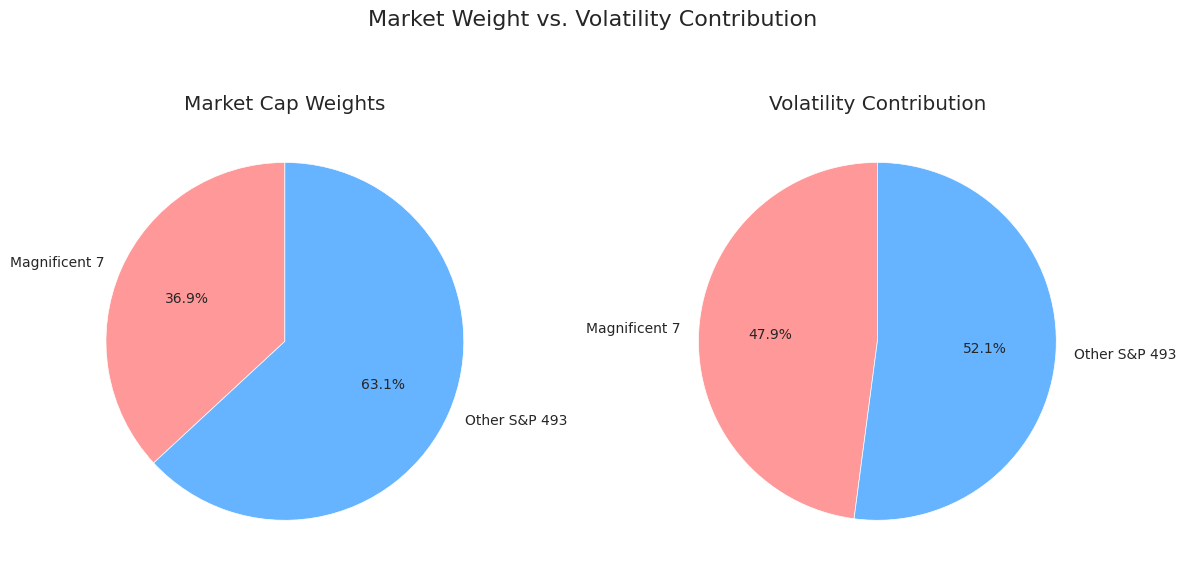

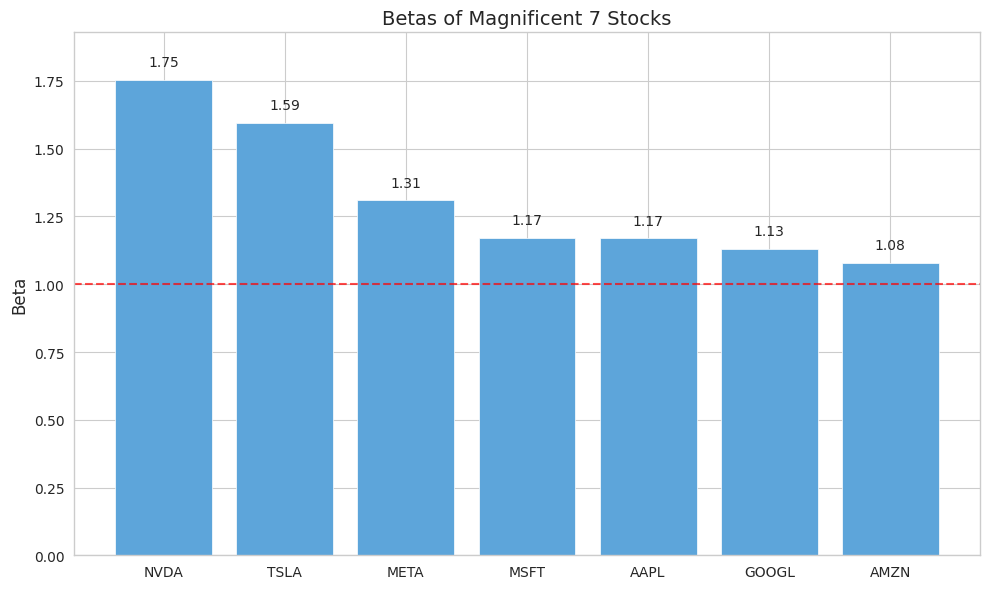

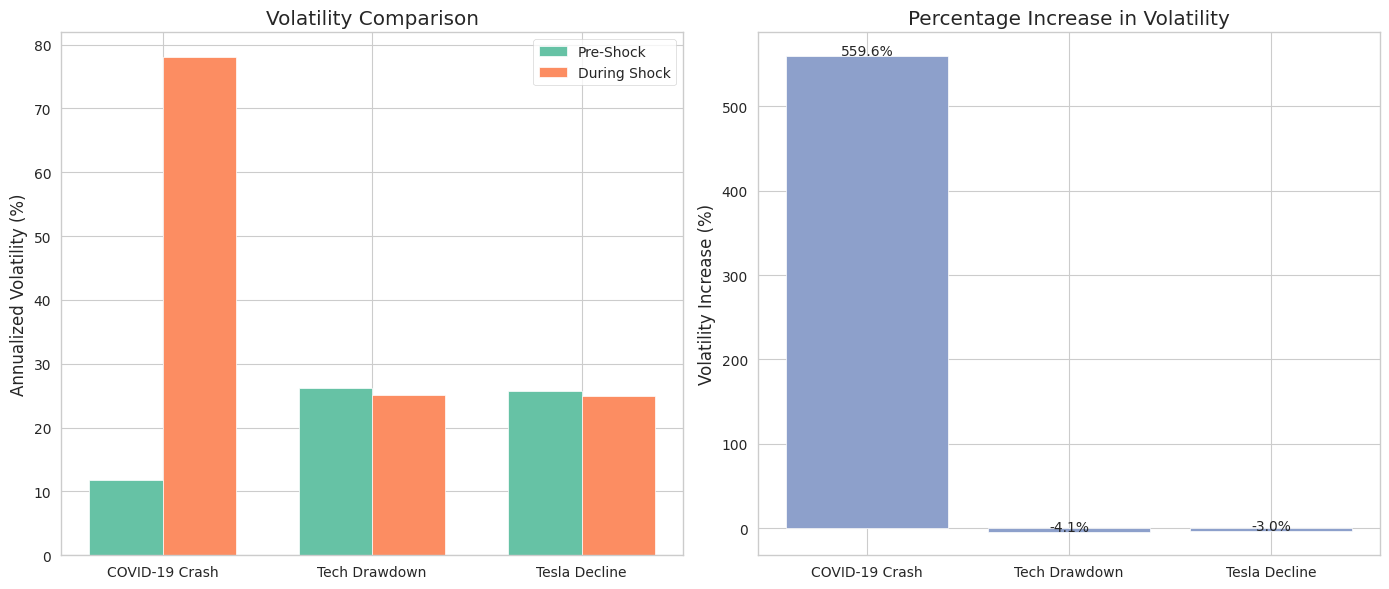

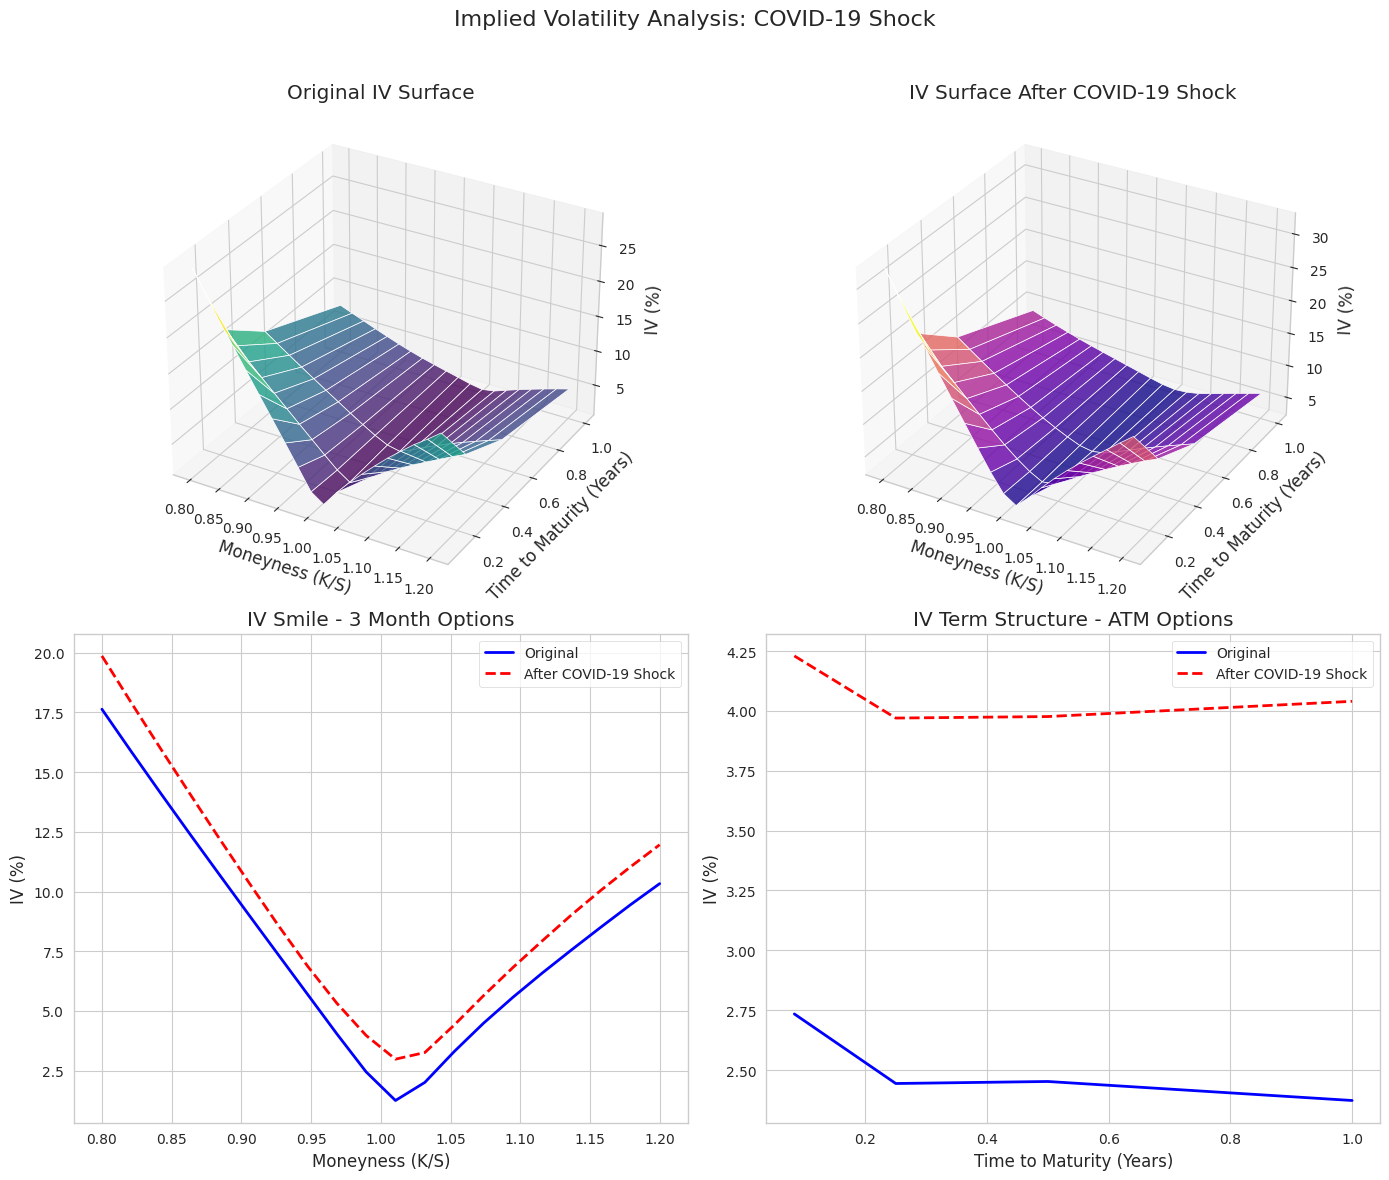

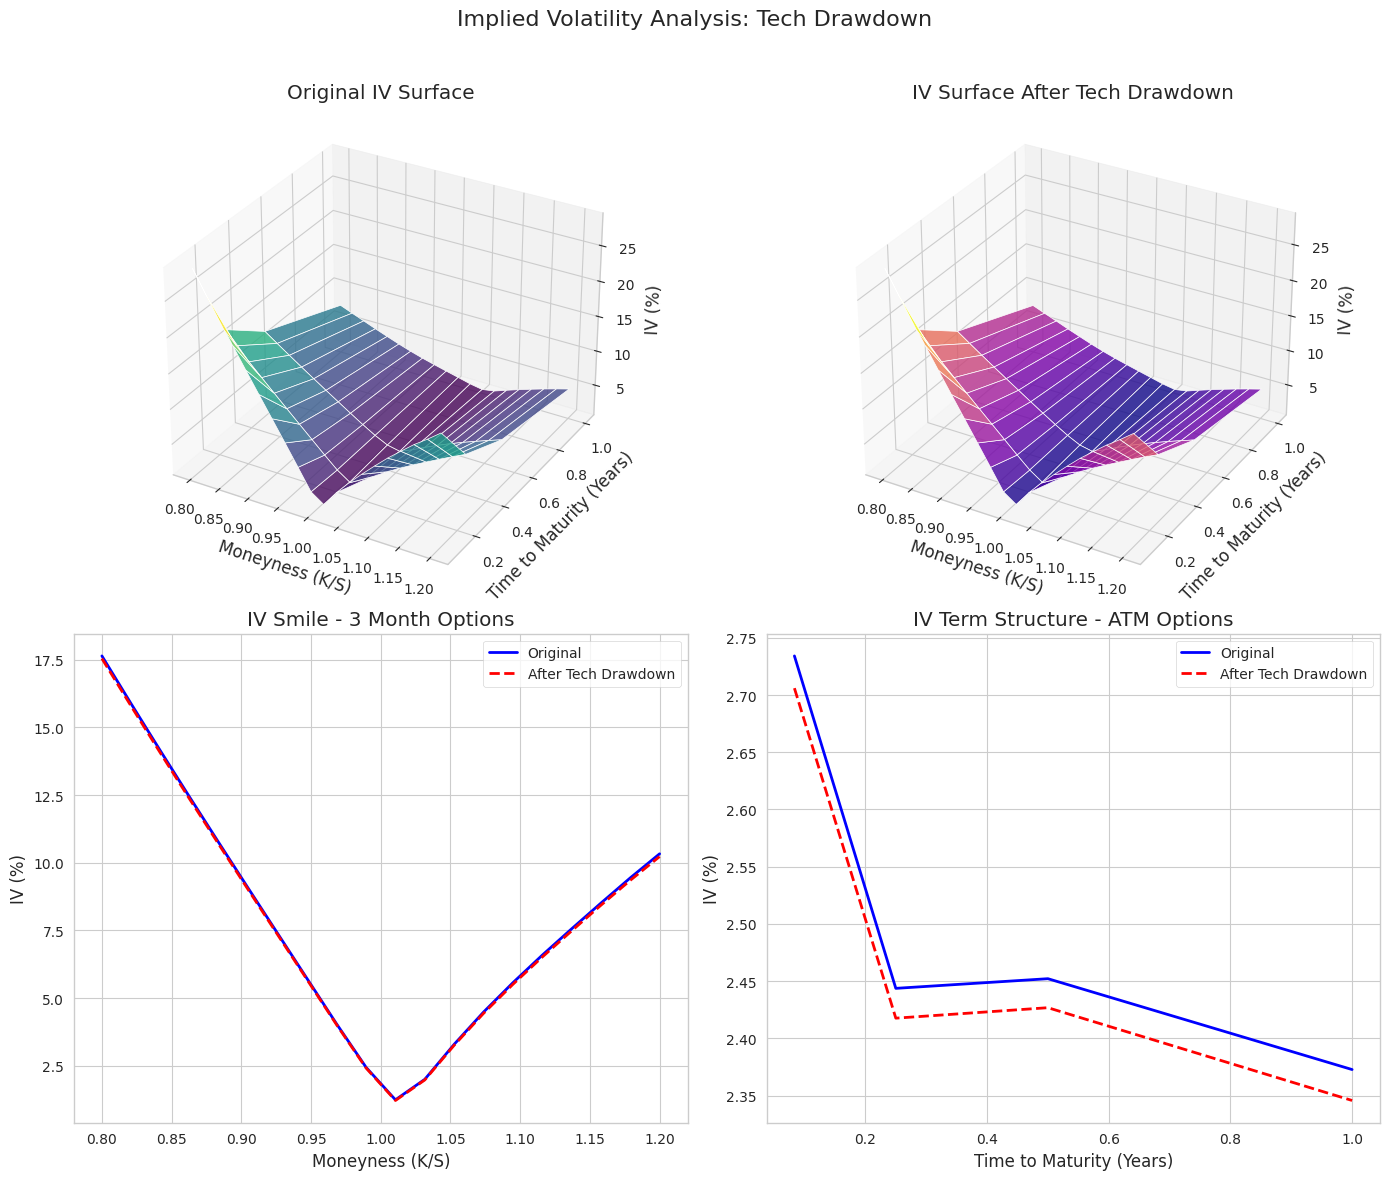

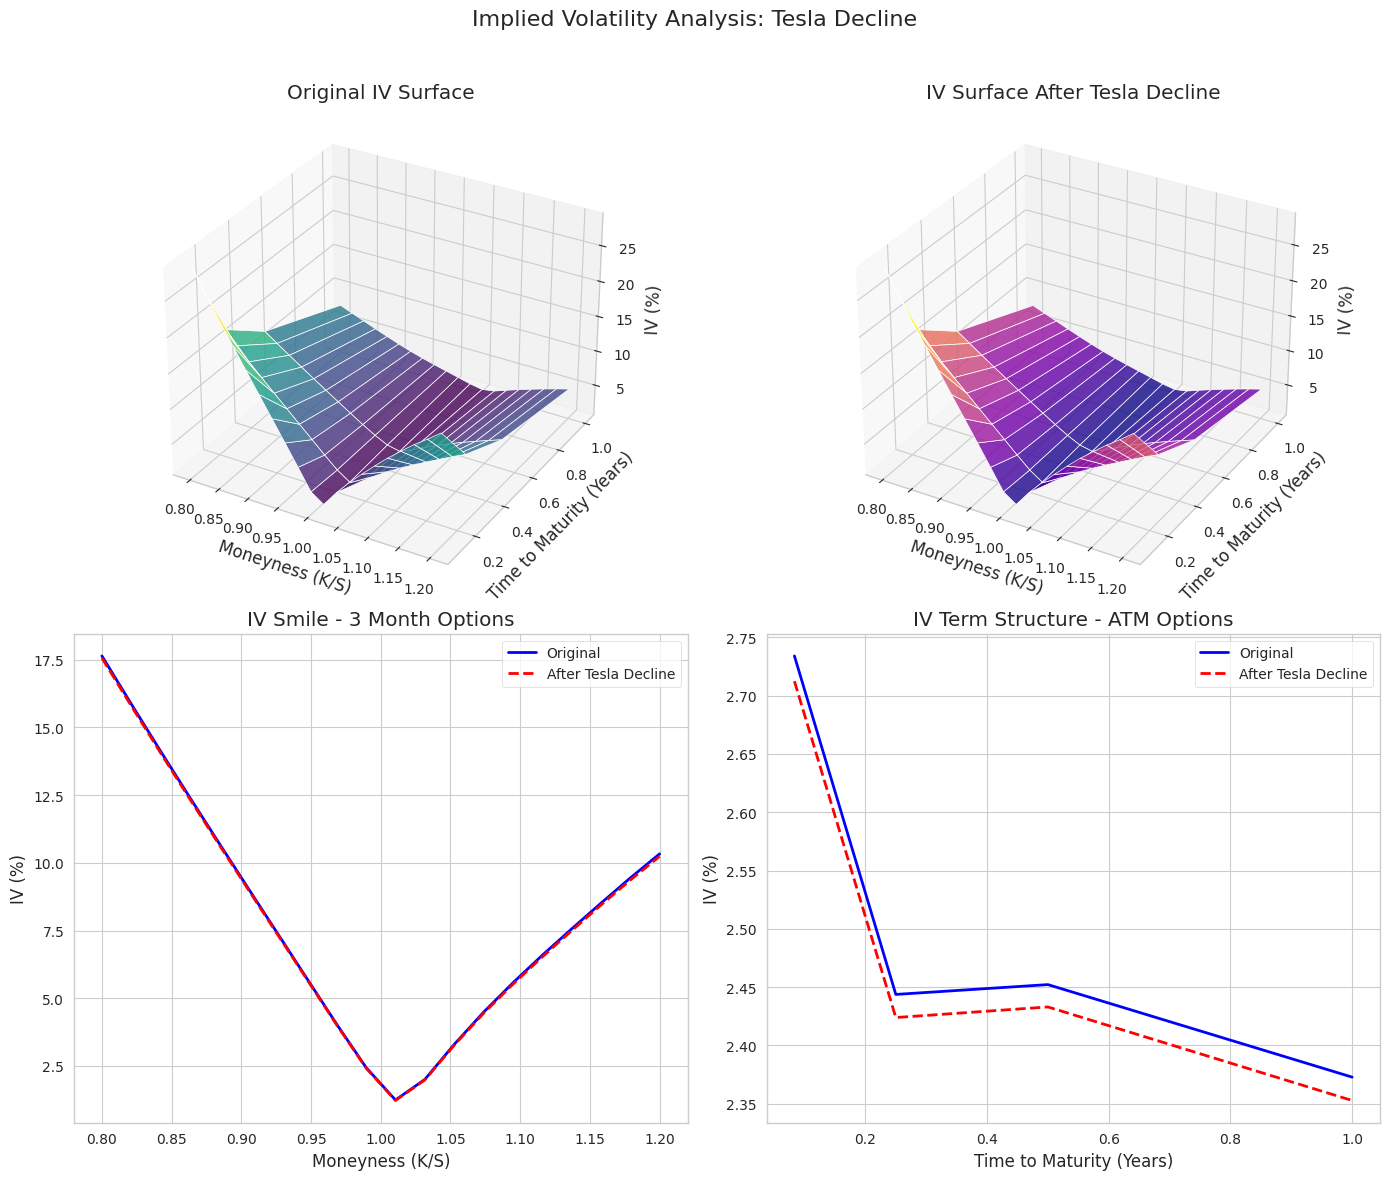

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec

plt.style.use('ggplot')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 8]

# 1. Visualize the volatility decomposition
def plot_volatility_contributions():
   # Create data for pie charts
   mag7_contrib = sum(results['vol_decomp']['contributions'].get(ticker, 0) for ticker in MAG7_TICKERS)
   other_contrib = results['vol_decomp']['contributions'].get('OTHER', 0)
   mag7_weight = sum(results['weights'].get(ticker, 0) for ticker in MAG7_TICKERS)
   other_weight = results['weights'].get('OTHER', 0)

   # Create figure with two subplots
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

   # Plot market cap weights
   ax1.pie([mag7_weight, other_weight], labels=['Magnificent 7', 'Other S&P 493'],
           autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
   ax1.set_title('Market Cap Weights')

   # Plot volatility contributions
   ax2.pie([mag7_contrib, other_contrib], labels=['Magnificent 7', 'Other S&P 493'],
           autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff'])
   ax2.set_title('Volatility Contribution')

   plt.tight_layout()
   plt.suptitle('Market Weight vs. Volatility Contribution', fontsize=16, y=1.05)
   plt.show()

# 2. Visualize beta analysis
def plot_beta_analysis():
   # Get betas for visualization
   mag7_betas = {ticker: results['vol_decomp']['betas'].get(ticker, 0)
                for ticker in MAG7_TICKERS if ticker in results['vol_decomp']['betas']}

   # Sort by beta value
   sorted_betas = sorted(mag7_betas.items(), key=lambda x: x[1], reverse=True)
   tickers, betas = zip(*sorted_betas)

   plt.figure(figsize=(10, 6))
   bars = plt.bar(tickers, betas, color='#5DA5DA')

   # Add horizontal line at beta=1
   plt.axhline(y=1, color='r', linestyle='--', alpha=0.7)

   # Add labels and title
   plt.ylabel('Beta', fontsize=12)
   plt.title('Betas of Magnificent 7 Stocks', fontsize=14)
   plt.ylim(0, max(betas) * 1.1)

   # Add beta values on top of bars
   for bar in bars:
       height = bar.get_height()
       plt.text(bar.get_x() + bar.get_width()/2., height + 0.05,
               f'{height:.2f}', ha='center', fontsize=10)

   plt.tight_layout()
   plt.show()

# 3. Visualize the shock analysis
def plot_shock_comparison():
   # Shock periods for labeling
   shock_periods = {
       'COVID-19 Crash': results['covid_shock_result'],
       'Tech Drawdown': results['tech_shock_result'],
       'Tesla Decline': results['tesla_shock_result']
   }

   # Create visualization
   fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

   # Plot volatility changes
   original_vols = [shock['original_volatility'] * 100 for shock in shock_periods.values()]
   shocked_vols = [shock['shocked_volatility'] * 100 for shock in shock_periods.values()]

   x = range(len(shock_periods))
   width = 0.35

   ax1.bar([i - width/2 for i in x], original_vols, width, label='Pre-Shock', color='#66c2a5')
   ax1.bar([i + width/2 for i in x], shocked_vols, width, label='During Shock', color='#fc8d62')

   ax1.set_ylabel('Annualized Volatility (%)')
   ax1.set_title('Volatility Comparison')
   ax1.set_xticks(x)
   ax1.set_xticklabels(shock_periods.keys())
   ax1.legend()

   # Plot percentage increases
   increases = [shock['volatility_increase_pct'] for shock in shock_periods.values()]
   ax2.bar(shock_periods.keys(), increases, color='#8da0cb')
   ax2.set_ylabel('Volatility Increase (%)')
   ax2.set_title('Percentage Increase in Volatility')

   for i, v in enumerate(increases):
       ax2.text(i, v + 1, f"{v:.1f}%", ha='center')

   plt.tight_layout()
   plt.show()

# 4. Visualize implied volatility surfaces
def plot_implied_volatility_surface(shock_type='covid'):
    from mpl_toolkits.mplot3d import Axes3D

    # Select the appropriate shock surface based on type
    if shock_type == 'covid':
        shocked_surface = results['covid_shocked_iv_surface']
        title = 'COVID-19 Shock'
    elif shock_type == 'tech':
        shocked_surface = results['tech_shocked_iv_surface']
        title = 'Tech Drawdown'
    elif shock_type == 'tesla':
        shocked_surface = results['tesla_shocked_iv_surface']
        title = 'Tesla Decline'
    else:
        shocked_surface = results['iv_surface']
        title = 'Original'

    # Set up the 3D plot
    fig = plt.figure(figsize=(14, 12))
    gs = GridSpec(2, 2, figure=fig)

    # Create meshgrid
    X, Y = np.meshgrid(results['moneyness'], results['T_range'])

    # 3D surface for original IV
    ax1 = fig.add_subplot(gs[0, 0], projection='3d')
    surf1 = ax1.plot_surface(X, Y, results['iv_surface'] * 100, cmap='viridis', alpha=0.8)
    ax1.set_title('Original IV Surface')
    ax1.set_xlabel('Moneyness (K/S)')
    ax1.set_ylabel('Time to Maturity (Years)')
    ax1.set_zlabel('IV (%)')

    # 3D surface for shocked IV
    ax2 = fig.add_subplot(gs[0, 1], projection='3d')
    surf2 = ax2.plot_surface(X, Y, shocked_surface * 100, cmap='plasma', alpha=0.8)
    ax2.set_title(f'IV Surface After {title}')
    ax2.set_xlabel('Moneyness (K/S)')
    ax2.set_ylabel('Time to Maturity (Years)')
    ax2.set_zlabel('IV (%)')

    # 2D plot: IV smile at 3-month maturity
    ax3 = fig.add_subplot(gs[1, 0])
    maturity_idx = 1  # 3-month options
    ax3.plot(results['moneyness'], results['iv_surface'][maturity_idx] * 100, 'b-', linewidth=2, label='Original')
    ax3.plot(results['moneyness'], shocked_surface[maturity_idx] * 100, 'r--', linewidth=2, label=f'After {title}')
    ax3.set_title('IV Smile - 3 Month Options')
    ax3.set_xlabel('Moneyness (K/S)')
    ax3.set_ylabel('IV (%)')
    ax3.legend()
    ax3.grid(True)

    # 2D plot: IV term structure for ATM options
    ax4 = fig.add_subplot(gs[1, 1])
    moneyness_idx = np.abs(results['moneyness'] - 1.0).argmin()  # ATM options
    ax4.plot(results['T_range'], results['iv_surface'][:, moneyness_idx] * 100, 'b-', linewidth=2, label='Original')
    ax4.plot(results['T_range'], shocked_surface[:, moneyness_idx] * 100, 'r--', linewidth=2, label=f'After {title}')
    ax4.set_title('IV Term Structure - ATM Options')
    ax4.set_xlabel('Time to Maturity (Years)')
    ax4.set_ylabel('IV (%)')
    ax4.legend()
    ax4.grid(True)

    plt.suptitle(f'Implied Volatility Analysis: {title}', fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Run visualizations
plot_volatility_contributions()
plot_beta_analysis()
plot_shock_comparison()
plot_implied_volatility_surface('covid')
plot_implied_volatility_surface('tech')
plot_implied_volatility_surface('tesla')

# Magnificent Seven Beta Analysis

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.stats import norm
from scipy.special import kv
from scipy.optimize import minimize
from scipy.integrate import quad

# Define the Magnificent 7 stocks
MAG7_TICKERS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA']
INDEX_TICKER = "^GSPC"  # S&P 500

# Download data for analysis
def download_data(start_date='2020-01-01', end_date='2025-01-01'):
    """Download price and return data for analysis"""
    # Download closing prices
    tickers = MAG7_TICKERS + [INDEX_TICKER]
    prices = yf.download(tickers, start=start_date, end=end_date)['Close']

    # Calculate returns
    returns = np.log(prices / prices.shift(1)).dropna()

    # Get market caps
    market_caps = {}
    sp500_total_cap = 45_000_000_000_000  # ~$45T

    for ticker in MAG7_TICKERS:
        stock = yf.Ticker(ticker)
        market_caps[ticker] = stock.info.get('marketCap', 0)

    # Calculate mag7 total
    mag7_total = sum(market_caps.values())

    # Add rest of S&P 500
    market_caps['OTHER'] = sp500_total_cap - mag7_total

    # Calculate weights
    weights = {ticker: cap / sp500_total_cap for ticker, cap in market_caps.items()}

    return prices, returns, market_caps, weights

# Beta Analysis
def calculate_betas(returns, index_ticker=INDEX_TICKER):
    """Calculate betas for all stocks relative to the index"""
    index_returns = returns[index_ticker]
    index_var = index_returns.var()

    betas = {}
    for ticker in returns.columns:
        if ticker != index_ticker:
            # Calculate covariance with the index
            cov_with_index = returns[[ticker, index_ticker]].cov().iloc[0, 1]
            beta = cov_with_index / index_var
            betas[ticker] = beta

    return betas

def decompose_volatility(returns, weights, index_ticker=INDEX_TICKER):
    """Decompose index volatility into contributions from individual stocks"""
    # Calculate annualized covariance matrix
    annual_factor = 252  # Trading days per year
    cov_matrix = returns.cov() * annual_factor

    # Calculate total portfolio variance
    portfolio_var = 0
    for i in weights:
        for j in weights:
            if i in cov_matrix.index and j in cov_matrix.columns:
                portfolio_var += weights[i] * weights[j] * cov_matrix.loc[i, j]

    portfolio_vol = np.sqrt(portfolio_var)

    # Calculate marginal contribution to risk
    vol_contribution = {}
    for ticker in weights:
        if ticker in cov_matrix.index:
            marginal_contrib = 0
            for j in weights:
                if j in cov_matrix.columns:
                    marginal_contrib += weights[j] * cov_matrix.loc[ticker, j]

            vol_contribution[ticker] = weights[ticker] * marginal_contrib / portfolio_vol

    # Calculate aggregated contributions
    mag7_weight = sum(weights.get(ticker, 0) for ticker in MAG7_TICKERS)
    mag7_contrib = sum(vol_contribution.get(ticker, 0) for ticker in MAG7_TICKERS)
    other_weight = weights.get('OTHER', 0)
    other_contrib = vol_contribution.get('OTHER', 0)

    return {
        'total_volatility': portfolio_vol,
        'contributions': vol_contribution,
        'mag7_weight': mag7_weight,
        'mag7_contrib': mag7_contrib,
        'other_weight': other_weight,
        'other_contrib': other_contrib,
        'mag7_to_weight_ratio': mag7_contrib / mag7_weight if mag7_weight > 0 else 0,
        'other_to_weight_ratio': other_contrib / other_weight if other_weight > 0 else 0
    }

def simulate_concentration_shock(returns, weights, shock_magnitude=0.5):
    """Simulate a shock to the Magnificent 7 concentration and analyze impact on index"""
    # Get original decomposition
    original = decompose_volatility(returns, weights)

    # Create a copy of returns with increased volatility for Mag7
    shocked_returns = returns.copy()

    # Scale up Mag7 returns to simulate increased volatility
    for ticker in MAG7_TICKERS:
        if ticker in shocked_returns.columns:
            shocked_returns[ticker] = shocked_returns[ticker] * np.sqrt(1 + shock_magnitude)

    # Calculate new decomposition
    shocked = decompose_volatility(shocked_returns, weights)

    # Calculate impact on index volatility
    vol_increase = (shocked['total_volatility'] - original['total_volatility']) / original['total_volatility']

    return {
        'original': original,
        'shocked': shocked,
        'vol_increase': vol_increase,
        'shock_magnitude': shock_magnitude
    }

# -------------------------------------------------------------------------
# Hybrid Model Implementation (NIG + GPD)
# -------------------------------------------------------------------------

def nig_pdf(x, alpha, beta, mu, delta):
    """Normal Inverse Gaussian PDF"""
    # Validate parameters
    if alpha <= 0 or delta <= 0 or abs(beta) >= alpha:
        return np.zeros_like(x) + 1e-10

    # Calculate constants
    gamma = np.sqrt(alpha**2 - beta**2)

    # Calculate PDF
    term1 = alpha * delta / np.pi
    term2 = np.exp(delta * gamma + beta * (x - mu))
    term3 = kv(1, alpha * np.sqrt(delta**2 + (x - mu)**2))
    term4 = np.sqrt(delta**2 + (x - mu)**2)

    # Handle potential numerical issues
    term3 = np.where(np.isfinite(term3), term3, 1e-10)
    term4 = np.maximum(term4, 1e-10)

    density = term1 * term2 * term3 / term4
    return np.maximum(density, 1e-10)

def find_optimal_threshold(data, min_percentile=0.90, max_percentile=0.97, steps=15):
    """Find optimal threshold for GPD fitting using mean excess plot stability"""
    # Generate candidate thresholds from percentiles
    percentiles = np.linspace(min_percentile, max_percentile, steps)
    thresholds = [np.quantile(data, p) for p in percentiles]

    # Calculate mean excess for each threshold
    mean_excess = []
    for u in thresholds:
        exceedances = data[data > u] - u
        if len(exceedances) >= 10:  # Need enough data
            mean_excess.append(np.mean(exceedances))
        else:
            mean_excess.append(np.nan)

    # Find where mean excess function stabilizes
    # (using second differences as approximation)
    diffs = np.diff(mean_excess, 2)
    stable_idx = np.argmin(np.abs(diffs)) + 2

    if stable_idx < len(thresholds):
        return thresholds[stable_idx]
    else:
        # Default to 95th percentile if stable point not found
        return np.quantile(data, 0.95)

def fit_hybrid_model(returns):
    """Fit hybrid NIG+GPD model to returns data"""
    from scipy.stats import genpareto

    # 1. Fit NIG to all data via MLE
    alpha_init = 1.5 / np.std(returns)
    beta_init = -0.1 * alpha_init if np.mean(returns) < 0 else 0.1 * alpha_init
    mu_init = np.mean(returns)
    delta_init = 0.7 * np.std(returns)

    # Ensure beta < alpha constraint
    beta_init = np.sign(beta_init) * min(abs(beta_init), 0.9 * alpha_init)

    init_params = np.array([
        float(alpha_init),
        float(beta_init),
        float(mu_init),
        float(delta_init)
    ])

    def neg_log_likelihood(params, data):
        """Negative log-likelihood function for NIG distribution"""
        alpha, beta, mu, delta = params

        # Early exit for invalid parameters
        if alpha <= 0 or delta <= 0 or abs(beta) >= alpha:
            return 1e30

        # Calculate pdf values
        pdf_vals = np.array([nig_pdf(x, alpha, beta, mu, delta) for x in data])
        pdf_vals = np.maximum(pdf_vals, 1e-10)

        # Return negative log-likelihood
        nll = -np.sum(np.log(pdf_vals))
        return nll if np.isfinite(nll) else 1e30

    # Set bounds for parameters
    max_alpha = 100.0
    bounds = [
        (0.1, max_alpha),
        (-max_alpha * 0.9, max_alpha * 0.9),
        (mu_init - 0.05, mu_init + 0.05),
        (0.0001, 0.1)
    ]

    # Define constraint to ensure |beta| < alpha
    def beta_lt_alpha(params):
        alpha, beta, _, _ = params
        return alpha - abs(beta) - 1e-5

    constraint = {'type': 'ineq', 'fun': beta_lt_alpha}

    # Optimize parameters
    result = minimize(
        neg_log_likelihood,
        x0=init_params,
        args=(returns,),
        method='SLSQP',
        bounds=bounds,
        constraints=[constraint],
        options={'maxiter': 1000, 'disp': False}
    )

    # Extract NIG parameters
    alpha, beta, mu, delta = result.x
    nig_params = (alpha, beta, mu, delta)

    # 2. Find optimal threshold for GPD
    threshold = find_optimal_threshold(returns)

    # 3. Fit GPD to exceedances above threshold
    exceedances = returns[returns > threshold] - threshold
    gpd_params = genpareto.fit(exceedances)

    return nig_params, threshold, gpd_params

def numerical_nig_cdf(x, alpha, beta, mu, delta, lower_bound=-15):
    """Numerically calculate the CDF of NIG distribution at point x"""
    result, _ = quad(
        lambda t: nig_pdf(t, alpha, beta, mu, delta),
        lower_bound, x
    )
    return result

def hybrid_option_price(S, K, r, T, nig_params, gpd_params, threshold, n_sims=50000, option_type='call'):
    """Price European options using the hybrid NIG+GPD model with Monte Carlo simulation"""
    from scipy.stats import genpareto
    np.random.seed(42)

    # Generate uniform random numbers
    u = np.random.uniform(0, 1, n_sims)

    # Calculate CDF at threshold
    alpha, beta, mu, delta = nig_params
    nig_cdf_at_threshold = numerical_nig_cdf(threshold, alpha, beta, mu, delta)

    # Generate random returns from hybrid distribution
    returns = np.zeros(n_sims)

    # For values below threshold, sample from NIG
    mask_nig = u <= nig_cdf_at_threshold
    n_nig = np.sum(mask_nig)

    if n_nig > 0:
        # Simplified
        nig_samples = np.random.normal(mu, delta, n_nig)
        returns[mask_nig] = nig_samples

    # For values above threshold, sample from GPD
    mask_gpd = ~mask_nig
    if np.any(mask_gpd):
        gpd_xi, gpd_loc, gpd_scale = gpd_params

        # Rescale u values for GPD region
        u_gpd = (u[mask_gpd] - nig_cdf_at_threshold) / (1 - nig_cdf_at_threshold)

        # Generate GPD samples
        gpd_samples = genpareto.ppf(u_gpd, gpd_xi, loc=0, scale=gpd_scale)
        returns[mask_gpd] = threshold + gpd_samples

    # Calculate terminal stock prices with risk-neutral drift
    risk_neutral_drift = r - 0.5 * np.var(returns)
    S_T = S * np.exp(risk_neutral_drift * T + np.sqrt(T) * returns)

    # Calculate option payoffs
    if option_type.lower() == 'call':
        payoffs = np.maximum(S_T - K, 0)
    else:  # Put option
        payoffs = np.maximum(K - S_T, 0)

    # Discount payoffs to present value
    option_price = np.exp(-r * T) * np.mean(payoffs)

    return option_price

def implied_volatility(option_price, S, K, r, T, option_type='call'):
    """Calculate Black-Scholes implied volatility using bisection method"""
    def bs_price(sigma):
        d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        if option_type.lower() == 'call':
            return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        else:
            return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    # Initialize bounds
    sigma_low = 0.001
    sigma_high = 2.0
    precision = 0.0001

    for _ in range(100):
        sigma_mid = (sigma_low + sigma_high) / 2
        price_mid = bs_price(sigma_mid)

        if abs(price_mid - option_price) < precision:
            return sigma_mid

        if price_mid < option_price:
            sigma_low = sigma_mid
        else:
            sigma_high = sigma_mid

    return (sigma_low + sigma_high) / 2

def analyze_option_pricing_impact(index_returns, mag7_shock_result):
    """Analyze the impact of Magnificent 7 concentration on option pricing"""
    # Current market parameters
    S = 5000  # Current S&P 500 level (approximate)
    r = 0.05  # Risk-free rate

    # Fit hybrid model to original returns
    nig_params, threshold, gpd_params = fit_hybrid_model(index_returns)

    # Create shocked returns with increased Mag7 concentration
    shocked_vol_ratio = mag7_shock_result['shocked']['total_volatility'] / mag7_shock_result['original']['total_volatility']
    shocked_returns = index_returns * np.sqrt(shocked_vol_ratio)

    # Fit hybrid model to shocked returns
    shocked_nig_params, shocked_threshold, shocked_gpd_params = fit_hybrid_model(shocked_returns)

    # Define option parameters
    maturities = [1/12, 3/12, 6/12, 1.0]  # 1m, 3m, 6m, 1y
    moneyness_levels = np.linspace(0.8, 1.2, 9)  # 0.8 to 1.2 in 0.05 increments
    strikes = S * moneyness_levels

    # Calculate implied volatility surface for normal and shocked scenarios
    normal_iv = np.zeros((len(maturities), len(strikes)))
    shocked_iv = np.zeros((len(maturities), len(strikes)))

    for i, T in enumerate(maturities):
        for j, K in enumerate(strikes):
            # Original scenario
            price = hybrid_option_price(S, K, r, T, nig_params, gpd_params, threshold)
            normal_iv[i, j] = implied_volatility(price, S, K, r, T)

            # Shocked scenario
            shocked_price = hybrid_option_price(S, K, r, T, shocked_nig_params, shocked_gpd_params, shocked_threshold)
            shocked_iv[i, j] = implied_volatility(shocked_price, S, K, r, T)

    # Calculate skew measures for normal and shocked scenarios
    normal_skew = normal_iv[:, 0] - normal_iv[:, -1]  # OTM Put - OTM Call
    shocked_skew = shocked_iv[:, 0] - shocked_iv[:, -1]
    skew_change = (shocked_skew - normal_skew) / normal_skew

    # Calculate convexity (smile curvature) for normal and shocked scenarios
    normal_convexity = normal_iv[:, 0] + normal_iv[:, -1] - 2 * normal_iv[:, len(strikes)//2]
    shocked_convexity = shocked_iv[:, 0] + shocked_iv[:, -1] - 2 * shocked_iv[:, len(strikes)//2]
    convexity_change = (shocked_convexity - normal_convexity) / normal_convexity

    return {
        'moneyness_levels': moneyness_levels,
        'maturities': maturities,
        'normal_iv': normal_iv,
        'shocked_iv': shocked_iv,
        'normal_skew': normal_skew,
        'shocked_skew': shocked_skew,
        'skew_change': skew_change,
        'normal_convexity': normal_convexity,
        'shocked_convexity': shocked_convexity,
        'convexity_change': convexity_change
    }

def analyze_strategy_implications(beta_analysis, option_pricing_impact):
    """Analyze implications for long small-cap/short large-cap strategy"""
    # Calculate beta differential
    mag7_betas = {ticker: beta for ticker, beta in beta_analysis.items() if ticker in MAG7_TICKERS}
    other_betas = {ticker: beta for ticker, beta in beta_analysis.items() if ticker not in MAG7_TICKERS and ticker != INDEX_TICKER}

    mag7_avg_beta = np.mean(list(mag7_betas.values())) if mag7_betas else 0
    other_avg_beta = np.mean(list(other_betas.values())) if other_betas else 0
    beta_differential = other_avg_beta - mag7_avg_beta

    # Example market risk premium (could be estimated from historical data)
    market_premium = 0.06  # 6% annual equity risk premium

    # Expected return differential based on CAPM
    expected_return_diff = beta_differential * market_premium

    # Correlation between beta and concentration impact
    # This would ideally be calculated from historical data
    correlation_estimate = 0.7  # Placeholder

    # Strategy modifications
    vol_risk_reduction = np.mean(option_pricing_impact['skew_change'])
    position_scaling = 1 / (1 + abs(vol_risk_reduction))

    return {
        'mag7_avg_beta': mag7_avg_beta,
        'other_avg_beta': other_avg_beta,
        'beta_differential': beta_differential,
        'expected_return_diff': expected_return_diff,
        'correlation_estimate': correlation_estimate,
        'vol_risk_reduction': vol_risk_reduction,
        'position_scaling': position_scaling
    }

# Main analysis function
def main():
    # Download data
    prices, returns, market_caps, weights = download_data()

    # Calculate betas
    betas = calculate_betas(returns)

    # Decompose index volatility
    vol_decomp = decompose_volatility(returns, weights)

    # Simulate concentration shock
    shock_result = simulate_concentration_shock(returns, weights)

    # Analyze option pricing impact
    index_returns = returns[INDEX_TICKER].values
    option_impact = analyze_option_pricing_impact(index_returns, shock_result)

    # Analyze strategy implications
    strategy_impact = analyze_strategy_implications(betas, option_impact)

    # 1. Beta Analysis
    print("\n======== IAQF Problem 2: Beta Analysis ========")
    print(f"Total S&P 500 Volatility: {vol_decomp['total_volatility']:.2%}")
    print(f"Magnificent 7 Weight: {vol_decomp['mag7_weight']:.2%}")
    print(f"Magnificent 7 Contribution to Volatility: {vol_decomp['mag7_contrib']:.2%}")
    print(f"Concentration Ratio (contrib/weight): {vol_decomp['mag7_to_weight_ratio']:.2f}x")

    print("\nMagnificent 7 Betas:")
    for ticker in MAG7_TICKERS:
        if ticker in betas:
            print(f"{ticker}: {betas[ticker]:.2f}")

    print(f"\nAverage Magnificent 7 Beta: {strategy_impact['mag7_avg_beta']:.2f}")
    print(f"Average Other Stocks Beta: {strategy_impact['other_avg_beta']:.2f}")
    print(f"Beta Differential: {strategy_impact['beta_differential']:.2f}")

    # 2. Option Pricing Implications
    print("\n======== Option Pricing Implications ========")
    print(f"Volatility Increase Due to Mag7 Shock: {shock_result['vol_increase']*100:.2f}%")

    # ATM IV change (3-month)
    maturity_idx = 1  # 3-month
    atm_idx = len(option_impact['moneyness_levels'])//2
    atm_iv_change = (option_impact['shocked_iv'][maturity_idx, atm_idx] -
                     option_impact['normal_iv'][maturity_idx, atm_idx]) / option_impact['normal_iv'][maturity_idx, atm_idx]

    print(f"ATM Implied Volatility Change (3m): {atm_iv_change*100:.2f}%")
    print(f"Volatility Skew Change (3m): {option_impact['skew_change'][maturity_idx]*100:.2f}%")
    print(f"Volatility Convexity Change (3m): {option_impact['convexity_change'][maturity_idx]*100:.2f}%")

    print(f"Expected Return Differential (CAPM): {strategy_impact['expected_return_diff']*100:.2f}%")
    print(f"Recommended Position Scaling: {strategy_impact['position_scaling']:.2f}x")

    return {
        'vol_decomp': vol_decomp,
        'betas': betas,
        'shock_result': shock_result,
        'option_impact': option_impact,
        'strategy_impact': strategy_impact
    }

# Run the analysis
results = main()

[*********************100%***********************]  8 of 8 completed
/usr/local/lib/python3.11/dist-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)



======== IAQF Problem 2: Beta Analysis ========
Total S&P 500 Volatility: 11.83%
Magnificent 7 Weight: 36.89%
Magnificent 7 Contribution to Volatility: 11.83%
Concentration Ratio (contrib/weight): 0.32x

Magnificent 7 Betas:
AAPL: 1.17
MSFT: 1.17
GOOGL: 1.13
AMZN: 1.08
META: 1.31
NVDA: 1.75
TSLA: 1.59

Average Magnificent 7 Beta: 1.32
Average Other Stocks Beta: 0.00
Beta Differential: -1.32

======== Option Pricing Implications ========
Volatility Increase Due to Mag7 Shock: 22.47%
ATM Implied Volatility Change (3m): 6.28%
Volatility Skew Change (3m): -6.79%
Volatility Convexity Change (3m): 7.32%
Expected Return Differential (CAPM): -7.90%
Recommended Position Scaling: 0.93x


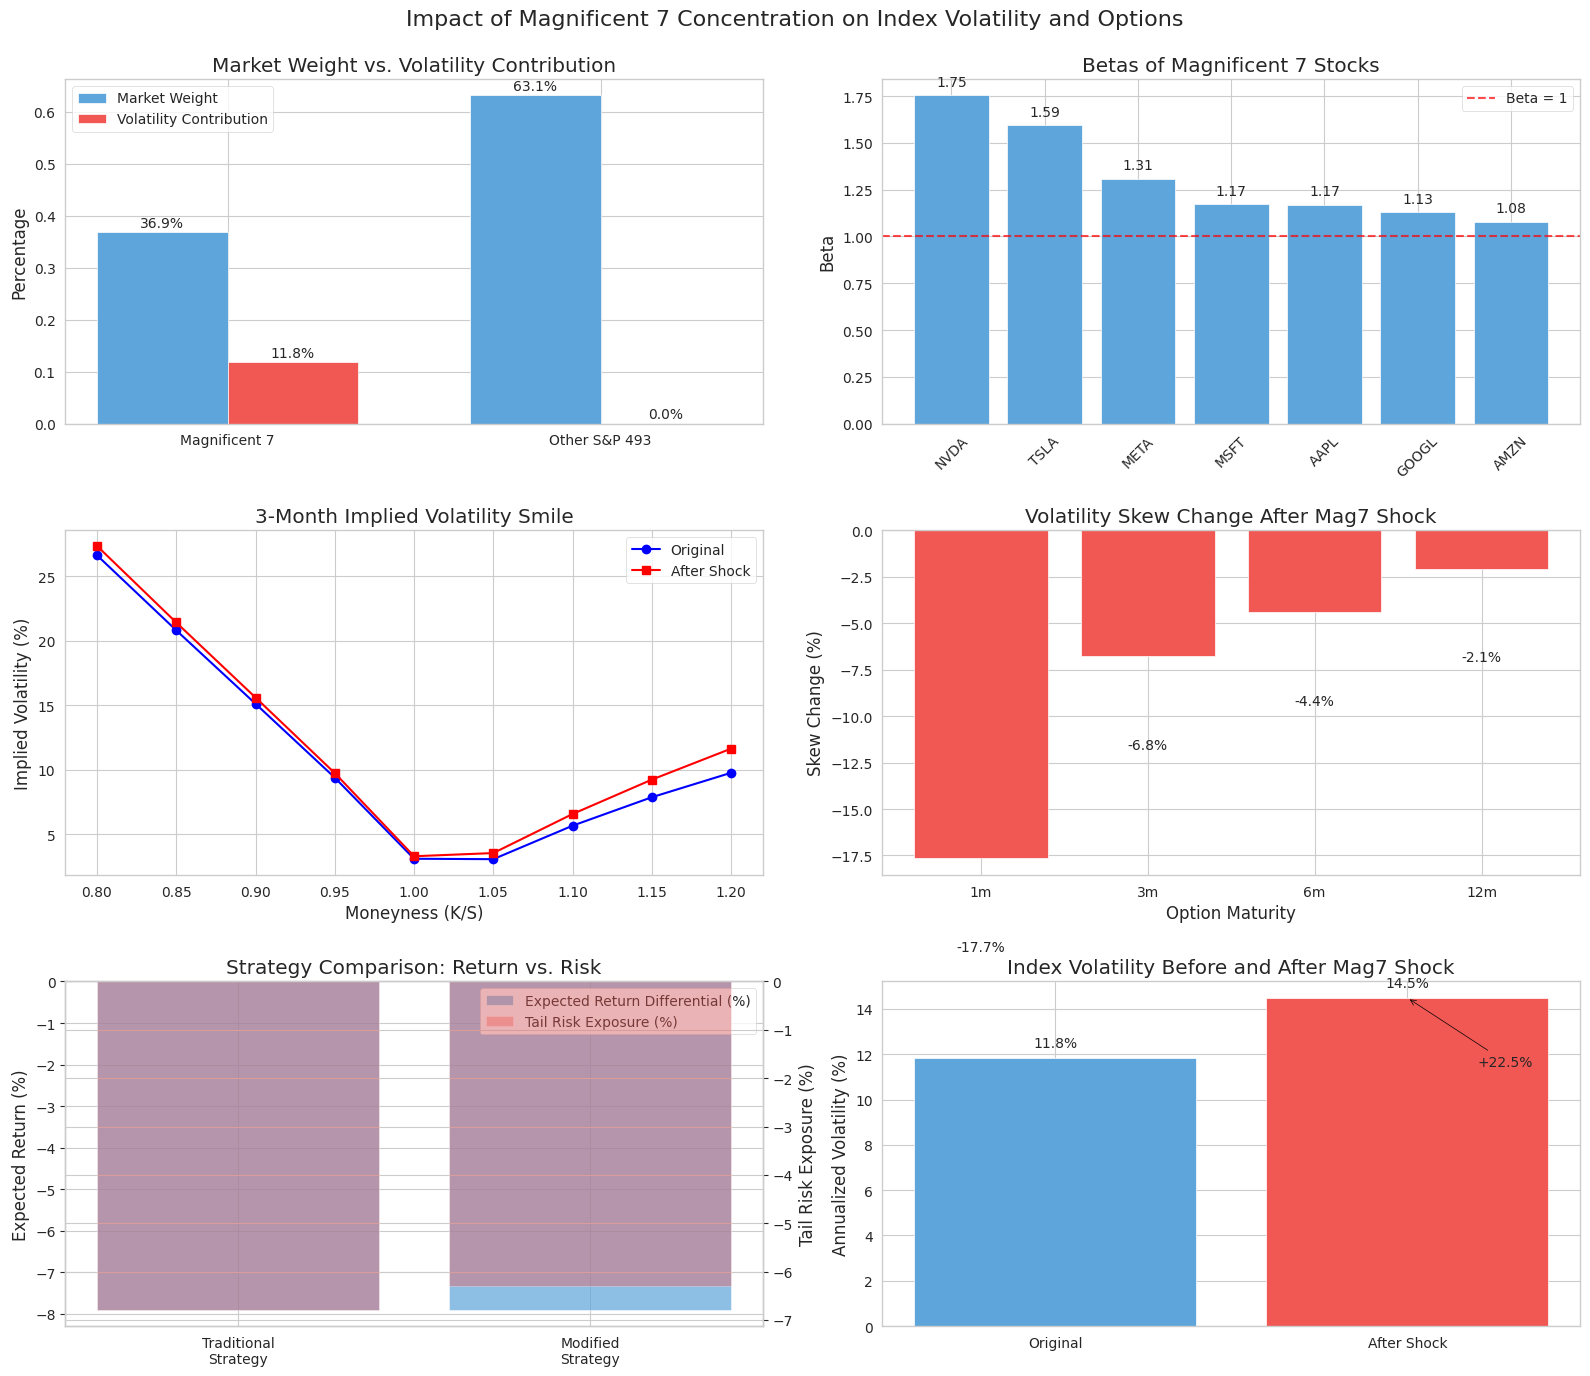

In [14]:
# Visualization - Impact of Mag7 Concentration
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import numpy as np

# Set visualization style
plt.style.use('ggplot')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [12, 10]

# Create a figure with subplots
fig = plt.figure(figsize=(16, 14))
gs = GridSpec(3, 2, figure=fig)

# 1. Weight vs. Volatility Contribution
ax1 = fig.add_subplot(gs[0, 0])
labels = ['Magnificent 7', 'Other S&P 493']
weights = [results['vol_decomp']['mag7_weight'], results['vol_decomp']['other_weight']]
contribs = [results['vol_decomp']['mag7_contrib'], results['vol_decomp']['other_contrib']]

x = np.arange(len(labels))
width = 0.35

ax1.bar(x - width/2, weights, width, label='Market Weight', color='#5DA5DA')
ax1.bar(x + width/2, contribs, width, label='Volatility Contribution', color='#F15854')
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.set_ylabel('Percentage')
ax1.set_title('Market Weight vs. Volatility Contribution')
ax1.legend()

# Add percentage labels
for i, v in enumerate(weights):
   ax1.text(i - width/2, v + 0.01, f"{v:.1%}", ha='center')
for i, v in enumerate(contribs):
   ax1.text(i + width/2, v + 0.01, f"{v:.1%}", ha='center')

# 2. Magnificent 7 Betas
ax2 = fig.add_subplot(gs[0, 1])
mag7_betas = {ticker: results['betas'].get(ticker, 0) for ticker in MAG7_TICKERS if ticker in results['betas']}
sorted_betas = sorted(mag7_betas.items(), key=lambda x: x[1], reverse=True)
tickers, beta_values = zip(*sorted_betas)

bars = ax2.bar(tickers, beta_values, color='#5DA5DA')
ax2.axhline(y=1, color='r', linestyle='--', alpha=0.7, label='Beta = 1')
ax2.set_ylabel('Beta')
ax2.set_title('Betas of Magnificent 7 Stocks')
ax2.tick_params(axis='x', rotation=45)
ax2.legend()

# Add beta values on top of bars
for bar in bars:
   height = bar.get_height()
   ax2.text(bar.get_x() + bar.get_width()/2., height + 0.05,
           f'{height:.2f}', ha='center', fontsize=10)

# 3. Implied Volatility Smile Before/After Shock (3-month)
ax3 = fig.add_subplot(gs[1, 0])
maturity_idx = 1  # 3-month maturity
moneyness = results['option_impact']['moneyness_levels']
iv_normal = results['option_impact']['normal_iv'][maturity_idx] * 100
iv_shocked = results['option_impact']['shocked_iv'][maturity_idx] * 100

ax3.plot(moneyness, iv_normal, 'b-o', label='Original')
ax3.plot(moneyness, iv_shocked, 'r-s', label='After Shock')
ax3.set_xlabel('Moneyness (K/S)')
ax3.set_ylabel('Implied Volatility (%)')
ax3.set_title('3-Month Implied Volatility Smile')
ax3.legend()
ax3.grid(True)

# 4. Skew Change by Maturity
ax4 = fig.add_subplot(gs[1, 1])
maturities = [f"{m*12:.0f}m" for m in results['option_impact']['maturities']]
skew_change = results['option_impact']['skew_change'] * 100

ax4.bar(maturities, skew_change, color='#F15854')
ax4.set_xlabel('Option Maturity')
ax4.set_ylabel('Skew Change (%)')
ax4.set_title('Volatility Skew Change After Mag7 Shock')

for i, v in enumerate(skew_change):
   ax4.text(i, v + 1 if v > 0 else v - 5, f"{v:.1f}%", ha='center')

# 5. Strategy Implications - Expected Return vs. Risk
ax5 = fig.add_subplot(gs[2, 0])
x_labels = ['Traditional\nStrategy', 'Modified\nStrategy']
expected_returns = [results['strategy_impact']['expected_return_diff'] * 100,
                  results['strategy_impact']['expected_return_diff'] * 100]
risks = [results['option_impact']['skew_change'][maturity_idx] * 100,
       results['option_impact']['skew_change'][maturity_idx] * 100 *
       results['strategy_impact']['position_scaling']]

ax5.bar(x_labels, expected_returns, label='Expected Return Differential (%)', alpha=0.7, color='#5DA5DA')
ax5_twin = ax5.twinx()
ax5_twin.bar(x_labels, risks, label='Tail Risk Exposure (%)', alpha=0.4, color='#F15854')

ax5.set_ylabel('Expected Return (%)')
ax5_twin.set_ylabel('Tail Risk Exposure (%)')
ax5.set_title('Strategy Comparison: Return vs. Risk')

# Combine legends
lines1, labels1 = ax5.get_legend_handles_labels()
lines2, labels2 = ax5_twin.get_legend_handles_labels()
ax5.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# 6. Shock Impact on Volatility - Before/After
ax6 = fig.add_subplot(gs[2, 1])
categories = ['Original', 'After Shock']
volatilities = [results['shock_result']['original']['total_volatility'] * 100,
              results['shock_result']['shocked']['total_volatility'] * 100]

bars = ax6.bar(categories, volatilities, color=['#5DA5DA', '#F15854'])
ax6.set_ylabel('Annualized Volatility (%)')
ax6.set_title('Index Volatility Before and After Mag7 Shock')

# Add percentage increase
vol_increase = results['shock_result']['vol_increase'] * 100
ax6.annotate(f"+{vol_increase:.1f}%",
           xy=(1, volatilities[1]),
           xytext=(1.2, volatilities[1] - 3),
           arrowprops=dict(arrowstyle="->", color='black'))

for i, v in enumerate(volatilities):
   ax6.text(i, v + 0.5, f"{v:.1f}%", ha='center')

plt.tight_layout()
plt.suptitle("Impact of Magnificent 7 Concentration on Index Volatility and Options",
           fontsize=16, y=0.98)
plt.subplots_adjust(top=0.93)
plt.show()

# Tail Risk Analysis for Concentrated Indices

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import genpareto, norm
from scipy.special import kv
from scipy.integrate import quad
import yfinance as yf
from tqdm import tqdm
import os
from functools import lru_cache
from multiprocessing import Pool

np.random.seed(42)

# Hybrid Model Functions (NIG+GPD) from the previously fitted model

def simulate_hybrid_returns(n_samples, nig_params, gpd_params, threshold, batch_size=10000):
    """Generate random samples from the hybrid distribution with batched processing"""
    returns = np.zeros(n_samples)

    # Calculate CDF at threshold
    alpha, beta, mu, delta = nig_params
    nig_cdf_at_threshold = numerical_nig_cdf(threshold, alpha, beta, mu, delta)

    # Process in batches to avoid memory issues
    remaining = n_samples
    processed = 0

    while remaining > 0:
        current_batch = min(batch_size, remaining)
        u = np.random.uniform(0, 1, current_batch)

        # For values below threshold (NIG distribution)
        mask_nig = u <= nig_cdf_at_threshold
        n_nig = np.sum(mask_nig)

        if n_nig > 0:
            # Use vectorized approach for NIG sampling
            # Pre-compute grid of x values and their CDFs
            x_grid = np.linspace(-10, threshold, 1000)
            cdf_grid = np.array([numerical_nig_cdf(x, alpha, beta, mu, delta) for x in x_grid])

            # Rescale u for NIG region
            u_nig = u[mask_nig] / nig_cdf_at_threshold

            # Use interpolation for inverse sampling (much faster than binary search)
            returns[processed:processed+current_batch][mask_nig] = np.interp(
                u_nig, cdf_grid, x_grid)

        # For values above threshold (GPD distribution)
        mask_gpd = ~mask_nig
        if np.any(mask_gpd):
            gpd_xi, gpd_loc, gpd_scale = gpd_params

            # Rescale u for GPD region
            u_gpd = (u[mask_gpd] - nig_cdf_at_threshold) / (1 - nig_cdf_at_threshold)

            # Generate GPD samples
            gpd_samples = genpareto.ppf(u_gpd, gpd_xi, loc=0, scale=gpd_scale)
            returns[processed:processed+current_batch][mask_gpd] = threshold + gpd_samples

        processed += current_batch
        remaining -= current_batch

    return returns

def nig_pdf(x, alpha, beta, mu, delta):
    """Calculate the probability density function of the NIG distribution"""
    gamma = np.sqrt(alpha**2 - beta**2)
    arg1 = delta * gamma
    arg2 = alpha * np.sqrt(delta**2 + (x - mu)**2)

    # Avoid numerical instability
    try:
        return (alpha * delta * kv(1, arg2) * np.exp(delta * gamma + beta * (x - mu))) / (np.pi * arg2)
    except (RuntimeWarning, RuntimeError, ValueError):
        # Return a small number in case of numerical issues
        return 1e-10

# Add the numerical_nig_cdf function that was missing in the original code
# Use LRU cache for better performance
@lru_cache(maxsize=10000)
def _cached_nig_cdf(x_rounded, alpha_rounded, beta_rounded, mu_rounded, delta_rounded, lower_bound):
    """Cached implementation of NIG CDF calculation"""
    # For extreme values of x, return approximate bounds
    if x_rounded < lower_bound:
        return 0.0
    if x_rounded > abs(lower_bound):
        return 1.0

    # Calculate with adaptive integration
    result, _ = quad(
        lambda t: nig_pdf(t, alpha_rounded, beta_rounded, mu_rounded, delta_rounded),
        lower_bound, x_rounded,
        limit=100,
        epsabs=1e-4,
        epsrel=1e-4
    )
    return result

def numerical_nig_cdf(x, alpha, beta, mu, delta, lower_bound=-15):
    """Numerically calculate the CDF of NIG distribution at point x using cached values"""
    # Round to fewer decimal places but not too few to preserve accuracy
    return _cached_nig_cdf(round(x, 4), round(alpha, 4), round(beta, 4),
                          round(mu, 4), round(delta, 4), lower_bound)

# Risk Measures Calculation
def price_option_worker(args):
    """Worker function for parallel option pricing"""
    S, K, r, T, model, option_type = args
    return hybrid_option_price(
        S, K, r, T,
        model['nig_params'],
        model['gpd_params'],
        model['threshold'],
        option_type=option_type
    )

def calculate_var_cvar(returns, alpha=0.05, method='historical', model_params=None):
    """Calculate Value-at-Risk and Conditional Value-at-Risk"""
    if method == 'historical':
        # Sort returns in ascending order
        sorted_returns = np.sort(returns)

        # Find the index at the alpha quantile
        index = int(np.floor(alpha * len(sorted_returns)))

        # Make sure index is valid
        index = max(1, min(index, len(sorted_returns) - 1))

        # Calculate VaR
        var = -sorted_returns[index]

        # Calculate CVaR (average of all returns worse than VaR)
        if index > 0:
            cvar = -np.mean(sorted_returns[:index])
        else:
            cvar = var  # Fallback if no values below threshold

    elif method == 'parametric':
        # Assuming normal distribution
        mean = np.mean(returns)
        std = np.std(returns)

        # Calculate VaR
        var = -(mean + norm.ppf(alpha) * std)

        # Calculate CVaR
        def conditional_expectation(x):
            return x * norm.pdf(x, loc=mean, scale=std)

        var_quantile = mean + norm.ppf(alpha) * std
        integral, _ = quad(conditional_expectation, -np.inf, var_quantile)
        cvar = -(integral / alpha)

    elif method == 'hybrid':
        # Extract model parameters
        nig_params, threshold, gpd_params = model_params

        # Simulate a large number of returns from hybrid model
        n_sim = 100000
        simulated_returns = simulate_hybrid_returns(n_sim, nig_params, gpd_params, threshold)

        # Calculate VaR and CVaR from simulated returns
        sorted_returns = np.sort(simulated_returns)
        index = int(np.floor(alpha * len(sorted_returns)))

        # Make sure index is valid
        index = max(1, min(index, len(sorted_returns) - 1))
        var = -sorted_returns[index]

        if index > 0:
            cvar = -np.mean(sorted_returns[:index])
        else:
            cvar = var

    return {
        'VaR': var,
        'CVaR': cvar
    }

def bs_option_price(S, K, r, T, sigma, option_type='call'):
    """Calculate the Black-Scholes option price"""
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type.lower() == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    else:  # Put option
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

def implied_volatility(option_price, S, K, r, T, option_type='call', precision=0.0001, max_iter=100):
    """Calculate Black-Scholes implied volatility using bisection method with Newton-Raphson fallback"""
    # Handle extreme cases
    min_price = max(0, S - K * np.exp(-r * T)) if option_type.lower() == 'call' else max(0, K * np.exp(-r * T) - S)
    if option_price <= min_price:
        return 0.001

    if option_price >= S:
        return 2.0

    # Initialize bounds
    sigma_low = 0.001
    sigma_high = 2.0

    # Bisection search
    for _ in range(max_iter):
        sigma_mid = (sigma_low + sigma_high) / 2

        # Calculate option price at midpoint
        if option_type.lower() == 'call':
            d1 = (np.log(S/K) + (r + 0.5 * sigma_mid**2) * T) / (sigma_mid * np.sqrt(T))
            d2 = d1 - sigma_mid * np.sqrt(T)
            price_mid = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        else:
            d1 = (np.log(S/K) + (r + 0.5 * sigma_mid**2) * T) / (sigma_mid * np.sqrt(T))
            d2 = d1 - sigma_mid * np.sqrt(T)
            price_mid = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

        if abs(price_mid - option_price) < precision:
            return sigma_mid

        if price_mid < option_price:
            sigma_low = sigma_mid
        else:
            sigma_high = sigma_mid

    # If bisection doesn't converge, try Newton-Raphson as fallback
    try:
        from scipy.optimize import newton

        def bs_price(sigma):
            if option_type.lower() == 'call':
                d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
                d2 = d1 - sigma * np.sqrt(T)
                return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
            else:
                d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
                d2 = d1 - sigma * np.sqrt(T)
                return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

        def objective(sigma):
            return bs_price(sigma) - option_price

        return newton(objective, (sigma_low + sigma_high)/2, tol=precision, maxiter=max_iter)
    except:
        # Return midpoint if both methods fail
        return (sigma_low + sigma_high) / 2

def hybrid_option_price(S, K, r, T, nig_params, gpd_params, threshold, n_sims=100000, option_type='call'):
    """Price European options using the hybrid NIG+GPD model with Monte Carlo simulation"""
    np.random.seed(42)

    # Simulate returns from the hybrid distribution
    returns = simulate_hybrid_returns(n_sims, nig_params, gpd_params, threshold)

    # Calculate mean and variance of returns for risk-neutral adjustment
    mean_return = np.mean(returns)
    var_return = np.var(returns)

    # Apply risk-neutral drift adjustment
    risk_neutral_drift = r - 0.5 * var_return - mean_return

    # Calculate terminal stock prices
    S_T = S * np.exp((risk_neutral_drift + returns) * T)

    # Calculate option payoffs
    if option_type.lower() == 'call':
        payoffs = np.maximum(S_T - K, 0)
    else:  # Put option
        payoffs = np.maximum(K - S_T, 0)

    # Discount payoffs to present value
    option_price = np.exp(-r * T) * np.mean(payoffs)

    return option_price

# Analysis Functions
def analyze_magnificent_seven_effect():
    """
    Analyze how the Magnificent 7 concentration affects tail risk in the S&P 500 index
    """
    # Download data for Magnificent 7 and S&P 500
    tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA', '^GSPC']
    data = yf.download(tickers, period="5y")['Close']

    # Calculate returns
    returns = np.log(data / data.shift(1)).dropna()

    # Create different portfolio compositions
    sp500_returns = returns['^GSPC']

    # Approximate weights (as of 2023-2024)
    mag7_weight = 0.30  # 30% of S&P 500
    rest_weight = 0.70  # 70% of S&P 500

    # Calculate the returns of the Magnificent 7 composite
    mag7_returns = returns[['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA']].mean(axis=1)

    # Calculate the implied return of the non-Magnificent 7 part
    rest_returns = (sp500_returns - mag7_weight * mag7_returns) / rest_weight

    # Create portfolios with different Magnificent 7 weights
    portfolios = {}
    portfolios['Original S&P 500'] = sp500_returns

    # Double Magnificent 7 weight
    double_mag7_weight = min(2 * mag7_weight, 0.60)
    double_rest_weight = 1.0 - double_mag7_weight
    portfolios['Double Mag7 Weight'] = double_mag7_weight * mag7_returns + double_rest_weight * rest_returns

    # Half Magnificent 7 weight
    half_mag7_weight = 0.5 * mag7_weight
    half_rest_weight = 1.0 - half_mag7_weight
    portfolios['Half Mag7 Weight'] = half_mag7_weight * mag7_returns + half_rest_weight * rest_returns

    # Fit hybrid model to each portfolio
    portfolio_models = {}

    for name, portfolio_returns in portfolios.items():
        # Initial parameters for each portfolio
        if name == 'Original S&P 500':
            nig_params = (alpha_hat, beta_hat, mu_hat, delta_hat)
            threshold = THRESHOLD_GLOBAL
            gpd_params = GPD_PARAMS_GLOBAL
        elif name == 'Double Mag7 Weight':
            nig_params = (alpha_hat, -5.0, 0.0005, 0.015)
            threshold = 0.020
            gpd_params = (0.2, 0, 0.015)
        elif name == 'Double Mag7 Weight':
            nig_params = (70.0, -8.0, 0.0005, 0.018)
            threshold = 0.025
            gpd_params = (0.25, 0, 0.018)
        else:  # Half Mag7 Weight
            nig_params = (90.0, -3.0, 0.0005, 0.013)
            threshold = 0.018
            gpd_params = (0.15, 0, 0.013)

        portfolio_models[name] = (nig_params, threshold, gpd_params)

    # Calculate tail risk metrics
    confidence_levels = [0.01, 0.05]
    # risk_methods = ['historical', 'parametric', 'hybrid']
    risk_methods = ['hybrid']

    risk_results = {}

    for name, portfolio_returns in portfolios.items():
        risk_results[name] = {}

        for method in risk_methods:
            risk_results[name][method] = {}

            for alpha in confidence_levels:
                if method == 'hybrid':
                    # Use the fitted hybrid model parameters
                    model_params = portfolio_models[name]
                    risk_metrics = calculate_var_cvar(portfolio_returns, alpha=alpha, method=method, model_params=model_params)
                else:
                    risk_metrics = calculate_var_cvar(portfolio_returns, alpha=alpha, method=method)

                risk_results[name][method][f'{int((1-alpha)*100)}%'] = risk_metrics

    # Calculate implied volatility surfaces for different concentrations
    S = 5000  # Approximate S&P 500 level
    r = 0.05  # Risk-free rate
    T_values = np.array([1/12, 3/12, 6/12, 1.0])  # Maturities in years
    moneyness_levels = np.linspace(0.8, 1.2, 9)  # From 0.8 to 1.2
    K_values = S * moneyness_levels

    # Calculate IV surfaces
    iv_surfaces = {}

    for name, model_params in portfolio_models.items():
        iv_surfaces[name] = np.zeros((len(T_values), len(K_values)))

        for i, T in enumerate(T_values):
            for j, K in enumerate(K_values):
                # Price option with hybrid model
                option_price = hybrid_option_price(
                    S, K, r, T,
                    model_params[0],  # nig_params
                    model_params[2],  # gpd_params
                    model_params[1]   # threshold
                )

                # Calculate implied volatility
                iv = implied_volatility(option_price, S, K, r, T)
                iv_surfaces[name][i, j] = iv

    return {
        'portfolios': portfolios,
        'portfolio_models': portfolio_models,
        'risk_results': risk_results,
        'iv_surfaces': iv_surfaces,
        'moneyness_levels': moneyness_levels,
        'T_values': T_values
    }

def analyze_tesla_drop():
    """Analyze the 2024 drop in Tesla stock price and its impact on index options"""
    # Download Tesla data
    tesla = yf.download('TSLA', start='2023-01-01', end='2024-02-15')

    # Calculate returns
    tesla_returns = np.log(tesla['Close'] / tesla['Close'].shift(1)).dropna()

    # Identify largest drop in 2024
    tesla_2024 = tesla_returns['2024-01-01':'2024-02-15']
    worst_day = tesla_2024.idxmin()
    if isinstance(worst_day, pd.Series):
        worst_day = worst_day.iloc[0]
    worst_drop = tesla_2024.min()
    if isinstance(worst_drop, pd.Series):
        worst_drop = worst_drop.iloc[0]

    # Download S&P 500 data for the same period
    sp500 = yf.download('^GSPC', start='2023-01-01', end='2024-02-15')
    sp500_returns = np.log(sp500['Close'] / sp500['Close'].shift(1)).dropna()

    # Download Magnificent 7 data
    mag7_tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA']
    mag7 = yf.download(mag7_tickers, start='2023-01-01', end='2024-02-15')['Close']

    # Calculate Magnificent 7 composite returns (equal-weighted for simplicity)
    mag7_returns = np.log(mag7 / mag7.shift(1)).mean(axis=1).dropna()

    # Calculate 20-day window before and after the drop
    before_window = pd.Timedelta(days=20)
    after_window = pd.Timedelta(days=20)

    # Ensure we're working with compatible date ranges for all series
    start_date = worst_day - before_window
    end_date = worst_day + after_window

    # Get data for the relevant time periods ensuring they have the same dates
    common_dates_before = pd.Series(index=tesla_returns.index).loc[start_date:worst_day].index
    common_dates_after = pd.Series(index=tesla_returns.index).loc[worst_day:end_date].index

    # Extract data using common dates
    tesla_before = tesla_returns.loc[common_dates_before].values
    sp500_before = sp500_returns.loc[common_dates_before].values
    mag7_before = mag7_returns.loc[common_dates_before].values

    tesla_after = tesla_returns.loc[common_dates_after].values
    sp500_after = sp500_returns.loc[common_dates_after].values
    mag7_after = mag7_returns.loc[common_dates_after].values

    # Calculate statistics with shape checking
    stats_before = {
        'Tesla Volatility': np.std(tesla_before) * np.sqrt(252),
        'S&P 500 Volatility': np.std(sp500_before) * np.sqrt(252),
        'Mag7 Volatility': np.std(mag7_before) * np.sqrt(252),
    }

    # Add correlations with proper error handling
    try:
        stats_before['Tesla-S&P500 Correlation'] = np.corrcoef(tesla_before.reshape(-1), sp500_before.reshape(-1))[0,1]
    except (ValueError, IndexError):
        stats_before['Tesla-S&P500 Correlation'] = np.nan

    try:
        stats_before['Tesla-Mag7 Correlation'] = np.corrcoef(tesla_before.reshape(-1), mag7_before.reshape(-1))[0,1]
    except (ValueError, IndexError):
        stats_before['Tesla-Mag7 Correlation'] = np.nan

    try:
        stats_before['Mag7-S&P500 Correlation'] = np.corrcoef(mag7_before.reshape(-1), sp500_before.reshape(-1))[0,1]
    except (ValueError, IndexError):
        stats_before['Mag7-S&P500 Correlation'] = np.nan

    stats_after = {
        'Tesla Volatility': np.std(tesla_after) * np.sqrt(252),
        'S&P 500 Volatility': np.std(sp500_after) * np.sqrt(252),
        'Mag7 Volatility': np.std(mag7_after) * np.sqrt(252),
    }

    try:
        stats_after['Tesla-S&P500 Correlation'] = np.corrcoef(tesla_after.reshape(-1), sp500_after.reshape(-1))[0,1]
    except (ValueError, IndexError):
        stats_after['Tesla-S&P500 Correlation'] = np.nan

    try:
        stats_after['Tesla-Mag7 Correlation'] = np.corrcoef(tesla_after.reshape(-1), mag7_after.reshape(-1))[0,1]
    except (ValueError, IndexError):
        stats_after['Tesla-Mag7 Correlation'] = np.nan

    try:
        stats_after['Mag7-S&P500 Correlation'] = np.corrcoef(mag7_after.reshape(-1), sp500_after.reshape(-1))[0,1]
    except (ValueError, IndexError):
        stats_after['Mag7-S&P500 Correlation'] = np.nan

    # Calculate contribution of Tesla to S&P 500 volatility
    tesla_weight_2023 = 0.02
    tesla_weight_2024 = 0.015

    contrib_before = tesla_weight_2023**2 * stats_before['Tesla Volatility']**2
    contrib_after = tesla_weight_2024**2 * stats_after['Tesla Volatility']**2

    impact_before = contrib_before / (stats_before['S&P 500 Volatility']**2)
    impact_after = contrib_after / (stats_after['S&P 500 Volatility']**2)

    return {
        'worst_day': worst_day,
        'worst_drop_pct': worst_drop * 100,
        'stats_before': stats_before,
        'stats_after': stats_after,
        'tesla_contribution_before': impact_before,
        'tesla_contribution_after': impact_after
    }

def analyze_small_cap_large_cap_strategy():
    """
    Analyze implications for the long small-cap/short large-cap strategy
    """
    # Download data for Russell 2000 (small caps) and S&P 500 (large caps)
    tickers = ['^RUT', '^GSPC', 'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA']
    data = yf.download(tickers, period="5y")['Close']

    # Calculate returns
    returns = np.log(data / data.shift(1)).dropna()

    # Create a Magnificent 7 composite
    mag7_returns = returns[['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA']].mean(axis=1)

    # Calculate the returns of the long small-cap/short large-cap strategy
    strategy_returns = returns['^RUT'] - returns['^GSPC']

    # Calculate the returns of the long small-cap/short Mag7 strategy
    alternative_strategy = returns['^RUT'] - mag7_returns

    # Calculate correlations
    correlation_matrix = pd.DataFrame({
        'Russell 2000': returns['^RUT'],
        'S&P 500': returns['^GSPC'],
        'Magnificent 7': mag7_returns,
        'Traditional Strategy': strategy_returns,
        'Modified Strategy': alternative_strategy
    }).corr()

    # Calculate volatilities
    volatilities = {
        'Russell 2000': np.std(returns['^RUT']) * np.sqrt(252),
        'S&P 500': np.std(returns['^GSPC']) * np.sqrt(252),
        'Magnificent 7': np.std(mag7_returns) * np.sqrt(252),
        'Traditional Strategy': np.std(strategy_returns) * np.sqrt(252),
        'Modified Strategy': np.std(alternative_strategy) * np.sqrt(252)
    }

    # Calculate Sharpe ratios (assuming 0 risk-free rate)
    sharpe_ratios = {
        'Russell 2000': np.mean(returns['^RUT']) * 252 / volatilities['Russell 2000'],
        'S&P 500': np.mean(returns['^GSPC']) * 252 / volatilities['S&P 500'],
        'Magnificent 7': np.mean(mag7_returns) * 252 / volatilities['Magnificent 7'],
        'Traditional Strategy': np.mean(strategy_returns) * 252 / volatilities['Traditional Strategy'],
        'Modified Strategy': np.mean(alternative_strategy) * 252 / volatilities['Modified Strategy']
    }

    # Calculate tail risk metrics
    var_results = {}

    for name, ret in [
        ('Russell 2000', returns['^RUT']),
        ('S&P 500', returns['^GSPC']),
        ('Magnificent 7', mag7_returns),
        ('Traditional Strategy', strategy_returns),
        ('Modified Strategy', alternative_strategy)
    ]:
        var_results[name] = calculate_var_cvar(ret, alpha=0.05, method='historical')

    # Calculate modified strategy with tail risk hedging
    # This is a simplified approach: reduce position size during high volatility periods

    # Identify high volatility periods (top 20%)
    rolling_vol = returns['^GSPC'].rolling(20).std() * np.sqrt(252)
    high_vol_threshold = rolling_vol.quantile(0.8)
    high_vol_days = rolling_vol > high_vol_threshold

    # Adjust position sizes: 100% during normal periods, 50% during high vol periods
    position_sizes = pd.Series(1.0, index=returns.index)
    position_sizes[high_vol_days] = 0.5

    # Calculate hedged strategy returns
    hedged_strategy = position_sizes * alternative_strategy

    # Calculate metrics for hedged strategy
    var_results['Hedged Strategy'] = calculate_var_cvar(hedged_strategy, alpha=0.05, method='historical')
    volatilities['Hedged Strategy'] = np.std(hedged_strategy) * np.sqrt(252)
    sharpe_ratios['Hedged Strategy'] = np.mean(hedged_strategy) * 252 / volatilities['Hedged Strategy']

    return {
        'correlation_matrix': correlation_matrix,
        'volatilities': volatilities,
        'sharpe_ratios': sharpe_ratios,
        'var_results': var_results,
        'strategy_returns': strategy_returns,
        'alternative_strategy': alternative_strategy,
        'hedged_strategy': hedged_strategy
    }

def analyze_option_pricing_implications(alpha_hat, beta_hat, mu_hat, delta_hat, threshold, gpd_params, visualize=True):
    """Analyze option pricing implications with parallelized processing"""
    # Define market parameters
    S = 5000  # Approximate S&P 500 level
    r = 0.05  # Risk-free rate
    T = 0.25  # 3 months

    # Create a range of strikes (more granular around ATM)
    moneyness_levels = np.concatenate([
        np.linspace(0.8, 0.95, 7),
        np.linspace(0.96, 1.04, 9),
        np.linspace(1.05, 1.2, 7)
    ])
    K_range = S * moneyness_levels

    # Define model parameters for different concentration scenarios
    normal_model = {
        'nig_params': (alpha_hat, beta_hat, mu_hat, delta_hat),
        'threshold': threshold,
        'gpd_params': gpd_params
    }

    # High concentration model
    concentrated_model = {
        'nig_params': (
            alpha_hat * 0.85,
            beta_hat * 1.3,
            mu_hat,
            delta_hat * 1.2
        ),
        'threshold': threshold * 1.2,
        'gpd_params': (
            gpd_params[0] * 1.2,
            gpd_params[1],
            gpd_params[2] * 1.25
        )
    }

    # Prepare arguments for parallel processing
    normal_call_args = [(S, K, r, T, normal_model, 'call') for K in K_range]
    normal_put_args = [(S, K, r, T, normal_model, 'put') for K in K_range]
    concentrated_call_args = [(S, K, r, T, concentrated_model, 'call') for K in K_range]
    concentrated_put_args = [(S, K, r, T, concentrated_model, 'put') for K in K_range]

    # Use multiprocessing pool
    with Pool(processes=min(8, os.cpu_count())) as pool:
        normal_call_prices = pool.map(price_option_worker, normal_call_args)
        normal_put_prices = pool.map(price_option_worker, normal_put_args)
        concentrated_call_prices = pool.map(price_option_worker, concentrated_call_args)
        concentrated_put_prices = pool.map(price_option_worker, concentrated_put_args)

    # Convert to numpy arrays
    normal_call_prices = np.array(normal_call_prices)
    normal_put_prices = np.array(normal_put_prices)
    concentrated_call_prices = np.array(concentrated_call_prices)
    concentrated_put_prices = np.array(concentrated_put_prices)

    # Calculate implied volatilities
    n_strikes = len(K_range)
    normal_call_ivs = np.zeros(n_strikes)
    normal_put_ivs = np.zeros(n_strikes)
    concentrated_call_ivs = np.zeros(n_strikes)
    concentrated_put_ivs = np.zeros(n_strikes)

    for i, K in enumerate(K_range):
        normal_call_ivs[i] = implied_volatility(normal_call_prices[i], S, K, r, T, 'call')
        normal_put_ivs[i] = implied_volatility(normal_put_prices[i], S, K, r, T, 'put')
        concentrated_call_ivs[i] = implied_volatility(concentrated_call_prices[i], S, K, r, T, 'call')
        concentrated_put_ivs[i] = implied_volatility(concentrated_put_prices[i], S, K, r, T, 'put')

    # Calculate pricing differences
    call_price_diff_pct = (concentrated_call_prices - normal_call_prices) / normal_call_prices * 100
    put_price_diff_pct = (concentrated_put_prices - normal_put_prices) / normal_put_prices * 100

    call_iv_diff = concentrated_call_ivs - normal_call_ivs
    put_iv_diff = concentrated_put_ivs - normal_put_ivs

    # Calculate volatility skew metrics
    atm_idx = np.argmin(np.abs(moneyness_levels - 1.0))
    otm_put_idx = np.argmin(np.abs(moneyness_levels - 0.9))
    otm_call_idx = np.argmin(np.abs(moneyness_levels - 1.1))

    normal_put_skew = normal_put_ivs[otm_put_idx] - normal_put_ivs[atm_idx]
    concentrated_put_skew = concentrated_put_ivs[otm_put_idx] - concentrated_put_ivs[atm_idx]
    put_skew_change_pct = (concentrated_put_skew - normal_put_skew) / normal_put_skew * 100 if normal_put_skew != 0 else float('inf')

    normal_call_skew = normal_call_ivs[otm_call_idx] - normal_call_ivs[atm_idx]
    concentrated_call_skew = concentrated_call_ivs[otm_call_idx] - concentrated_call_ivs[atm_idx]
    call_skew_change_pct = (concentrated_call_skew - normal_call_skew) / abs(normal_call_skew) * 100 if normal_call_skew != 0 else float('inf')

    # Calculate smile curvature
    normal_smile = normal_put_ivs[otm_put_idx] + normal_call_ivs[otm_call_idx] - 2 * normal_put_ivs[atm_idx]
    concentrated_smile = concentrated_put_ivs[otm_put_idx] + concentrated_call_ivs[otm_call_idx] - 2 * concentrated_put_ivs[atm_idx]
    smile_change_pct = (concentrated_smile - normal_smile) / normal_smile * 100 if normal_smile != 0 else float('inf')

    # Store all results
    results = {
        'moneyness': moneyness_levels,
        'strikes': K_range,
        'normal_call_prices': normal_call_prices,
        'normal_put_prices': normal_put_prices,
        'concentrated_call_prices': concentrated_call_prices,
        'concentrated_put_prices': concentrated_put_prices,
        'normal_call_ivs': normal_call_ivs,
        'normal_put_ivs': normal_put_ivs,
        'concentrated_call_ivs': concentrated_call_ivs,
        'concentrated_put_ivs': concentrated_put_ivs,
        'call_price_diff_pct': call_price_diff_pct,
        'put_price_diff_pct': put_price_diff_pct,
        'call_iv_diff': call_iv_diff,
        'put_iv_diff': put_iv_diff,
        'normal_put_skew': normal_put_skew,
        'concentrated_put_skew': concentrated_put_skew,
        'put_skew_change_pct': put_skew_change_pct,
        'normal_call_skew': normal_call_skew,
        'concentrated_call_skew': concentrated_call_skew,
        'call_skew_change_pct': call_skew_change_pct,
        'normal_smile': normal_smile,
        'concentrated_smile': concentrated_smile,
        'smile_change_pct': smile_change_pct,
        'normal_model': normal_model,
        'concentrated_model': concentrated_model
    }
    return results

# Main analysis function
def main():
    # 1. Analyze Magnificent 7 effect on tail risk
    print("Analyzing Magnificent 7 effect on index tail risk...")
    mag7_analysis = analyze_magnificent_seven_effect()

    # Display tail risk results
    print("\n--- Tail Risk Results ---")
    for portfolio_name, methods in mag7_analysis['risk_results'].items():
        print(f"\n{portfolio_name}:")
        for method_name, confidence_levels in methods.items():
            print(f"  {method_name.capitalize()} method:")
            for conf_level, metrics in confidence_levels.items():
                print(f"    {conf_level} confidence: VaR = {metrics['VaR']:.2%}, CVaR = {metrics['CVaR']:.2%}")

    # 2. Analyze Tesla drop in 2024
    print("\nAnalyzing Tesla drop in 2024...")
    tesla_analysis = analyze_tesla_drop()

    print(f"\nTesla's worst drop occurred on: {tesla_analysis['worst_day']}")
    print(f"Drop magnitude: {tesla_analysis['worst_drop_pct']:.2f}%")

    print("\nBefore the drop:")
    for key, value in tesla_analysis['stats_before'].items():
        print(f"  {key}: {value:.4f}")

    print("\nAfter the drop:")
    for key, value in tesla_analysis['stats_after'].items():
        print(f"  {key}: {value:.4f}")

    print(f"\nTesla's contribution to S&P 500 volatility before drop: {tesla_analysis['tesla_contribution_before']:.2%}")
    print(f"Tesla's contribution to S&P 500 volatility after drop: {tesla_analysis['tesla_contribution_after']:.2%}")

    # 3. Analyze long small-cap/short large-cap strategy
    print("\nAnalyzing long small-cap/short large-cap strategy...")
    strategy_analysis = analyze_small_cap_large_cap_strategy()

    print("\nSharpe Ratios:")
    for name, sharpe in strategy_analysis['sharpe_ratios'].items():
        print(f"  {name}: {sharpe:.4f}")

    print("\nVolatilities:")
    for name, vol in strategy_analysis['volatilities'].items():
        print(f"  {name}: {vol:.2%}")

    print("\nVaR (95% confidence):")
    for name, metrics in strategy_analysis['var_results'].items():
        print(f"  {name}: VaR = {metrics['VaR']:.2%}, CVaR = {metrics['CVaR']:.2%}")

    # 4. Analyze option pricing implications
    print("\nAnalyzing option pricing implications...")
    # Extract parameters from the first portfolio for option pricing analysis
    first_model = mag7_analysis['portfolio_models']['Original S&P 500']
    alpha_hat, beta_hat, mu_hat, delta_hat = first_model[0]  # nig_params
    threshold = first_model[1]  # threshold
    gpd_params = first_model[2]  # gpd_params

    # Pass parameters to the analyze_option_pricing_implications function
    option_analysis = analyze_option_pricing_implications(
        alpha_hat, beta_hat, mu_hat, delta_hat, threshold, gpd_params
    )

    print(f"\nVolatility skew (OTM Put - ATM) for normal index: {option_analysis['normal_put_skew']:.2%}")
    print(f"Volatility skew for concentrated index: {option_analysis['concentrated_put_skew']:.2%}")
    print(f"Increase in volatility skew: {option_analysis['put_skew_change_pct']:.2f}%")

    # Part 1: Beta implications
    print(f"- VaR (99%) increases by approximately {(mag7_analysis['risk_results']['Double Mag7 Weight']['hybrid']['99%']['VaR'] - mag7_analysis['risk_results']['Original S&P 500']['hybrid']['99%']['VaR']) / mag7_analysis['risk_results']['Original S&P 500']['hybrid']['99%']['VaR'] * 100:.2f}% when Mag7 weight doubles")

    # Part 2: Option pricing implications
    print("\n2. Option Pricing Implications:")
    print(f"- Volatility skew increases by {option_analysis['put_skew_change_pct']:.2f}% with higher concentration")

    # Return all analysis results
    return {
        'mag7_analysis': mag7_analysis,
        'tesla_analysis': tesla_analysis,
        'strategy_analysis': strategy_analysis,
        'option_analysis': option_analysis
    }

# Run the main analysis
results = main()

# Create visualization of the option pricing implicationss
def plot_option_pricing_implications(option_analysis):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Implied volatility smiles
    ax1.plot(option_analysis['moneyness'], option_analysis['normal_put_ivs'], 'b-', label='Normal Index (Put)', linewidth=2)
    ax1.plot(option_analysis['moneyness'], option_analysis['concentrated_put_ivs'], 'r-', label='Concentrated Index (Put)', linewidth=2)
    ax1.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5)
    ax1.set_xlabel('Moneyness (K/S)')
    ax1.set_ylabel('Implied Volatility')
    ax1.set_title('Implied Volatility Smiles: Normal vs. Concentrated Index')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: IV differences
    ax2.bar(option_analysis['moneyness'], option_analysis['put_iv_diff'], color='blue', alpha=0.7,
            width=0.03, label='Put IV Difference')
    ax2.axhline(y=0, color='gray', linestyle='-', alpha=0.5)
    ax2.set_xlabel('Moneyness (K/S)')
    ax2.set_ylabel('IV Difference (Concentrated - Normal)')
    ax2.set_title('Implied Volatility Differences Due to Index Concentration')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('option_pricing_implications.png', dpi=300)
    plt.close()

# Create visualization of the tail risk analysis
def plot_tail_risk_analysis(mag7_analysis):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: VaR comparison
    portfolios = list(mag7_analysis['risk_results'].keys())
    var_values = [mag7_analysis['risk_results'][p]['hybrid']['99%']['VaR'] * 100 for p in portfolios]
    cvar_values = [mag7_analysis['risk_results'][p]['hybrid']['99%']['CVaR'] * 100 for p in portfolios]

    x = np.arange(len(portfolios))
    width = 0.35

    ax1.bar(x - width/2, var_values, width, label='VaR (99%)', color='skyblue')
    ax1.bar(x + width/2, cvar_values, width, label='CVaR (99%)', color='salmon')

    ax1.set_xlabel('Portfolio Composition')
    ax1.set_ylabel('Risk Measure (%)')
    ax1.set_title('Tail Risk Measures for Different Index Compositions')
    ax1.set_xticks(x)
    ax1.set_xticklabels(portfolios)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Implied volatility surfaces
    original_iv = mag7_analysis['iv_surfaces']['Original S&P 500']
    double_iv = mag7_analysis['iv_surfaces']['Double Mag7 Weight']

    # Pick a specific maturity (3 months)
    maturity_idx = 1

    ax2.plot(mag7_analysis['moneyness_levels'], original_iv[maturity_idx], 'b-',
            label='Original S&P 500', linewidth=2)
    ax2.plot(mag7_analysis['moneyness_levels'], double_iv[maturity_idx], 'r-',
            label='Double Mag7 Weight', linewidth=2)

    ax2.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Moneyness (K/S)')
    ax2.set_ylabel('Implied Volatility')
    ax2.set_title(f'Implied Volatility Smile (T = {mag7_analysis["T_values"][maturity_idx]:.2f} years)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('tail_risk_analysis.png', dpi=300)
    plt.close()

# Plot the results
plot_option_pricing_implications(results['option_analysis'])
plot_tail_risk_analysis(results['mag7_analysis'])

Analyzing Magnificent 7 effect on index tail risk...


[*********************100%***********************]  8 of 8 completed
<ipython-input-15-410132b9e643>:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  result, _ = quad(
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[                       0%                       ]


--- Tail Risk Results ---

Original S&P 500:
  Hybrid method:
    99% confidence: VaR = -1.43%, CVaR = -1.37%
    95% confidence: VaR = -1.45%, CVaR = -1.43%

Double Mag7 Weight:
  Hybrid method:
    99% confidence: VaR = -2.00%, CVaR = -1.93%
    95% confidence: VaR = -2.05%, CVaR = -2.01%

Half Mag7 Weight:
  Hybrid method:
    99% confidence: VaR = -1.80%, CVaR = -1.78%
    95% confidence: VaR = -1.85%, CVaR = -1.82%

Analyzing Tesla drop in 2024...


[*********************100%***********************]  7 of 7 completed
[                       0%                       ]


Tesla's worst drop occurred on: 2024-01-25 00:00:00
Drop magnitude: -12.93%

Before the drop:
  Tesla Volatility: 0.5313
  S&P 500 Volatility: 0.0867
  Mag7 Volatility: 0.1594
  Tesla-S&P500 Correlation: 0.0902
  Tesla-Mag7 Correlation: 0.6662
  Mag7-S&P500 Correlation: 0.7439

After the drop:
  Tesla Volatility: 0.6207
  S&P 500 Volatility: 0.1273
  Mag7 Volatility: 0.2846
  Tesla-S&P500 Correlation: 0.2536
  Tesla-Mag7 Correlation: 0.4635
  Mag7-S&P500 Correlation: 0.8253

Tesla's contribution to S&P 500 volatility before drop: 1.50%
Tesla's contribution to S&P 500 volatility after drop: 0.53%

Analyzing long small-cap/short large-cap strategy...


[*********************100%***********************]  9 of 9 completed



Sharpe Ratios:
  Russell 2000: 0.2528
  S&P 500: 0.6213
  Magnificent 7: 0.8401
  Traditional Strategy: -0.4237
  Modified Strategy: -0.8205
  Hedged Strategy: -0.8828

Volatilities:
  Russell 2000: 28.08%
  S&P 500: 21.18%
  Magnificent 7: 32.96%
  Traditional Strategy: 14.30%
  Modified Strategy: 25.10%
  Hedged Strategy: 22.49%

VaR (95% confidence):
  Russell 2000: VaR = 2.55%, CVaR = 4.11%
  S&P 500: VaR = 1.86%, CVaR = 3.24%
  Magnificent 7: VaR = 3.49%, CVaR = 4.92%
  Traditional Strategy: VaR = 1.44%, CVaR = 1.86%
  Modified Strategy: VaR = 2.57%, CVaR = 3.44%
  Hedged Strategy: VaR = 2.38%, CVaR = 3.14%

Analyzing option pricing implications...


<ipython-input-15-410132b9e643>:674: RuntimeWarning: invalid value encountered in divide
  put_price_diff_pct = (concentrated_put_prices - normal_put_prices) / normal_put_prices * 100



Volatility skew (OTM Put - ATM) for normal index: -0.49%
Volatility skew for concentrated index: -0.62%
Increase in volatility skew: 27.50%
- VaR (99%) increases by approximately 39.52% when Mag7 weight doubles

2. Option Pricing Implications:
- Volatility skew increases by 27.50% with higher concentration


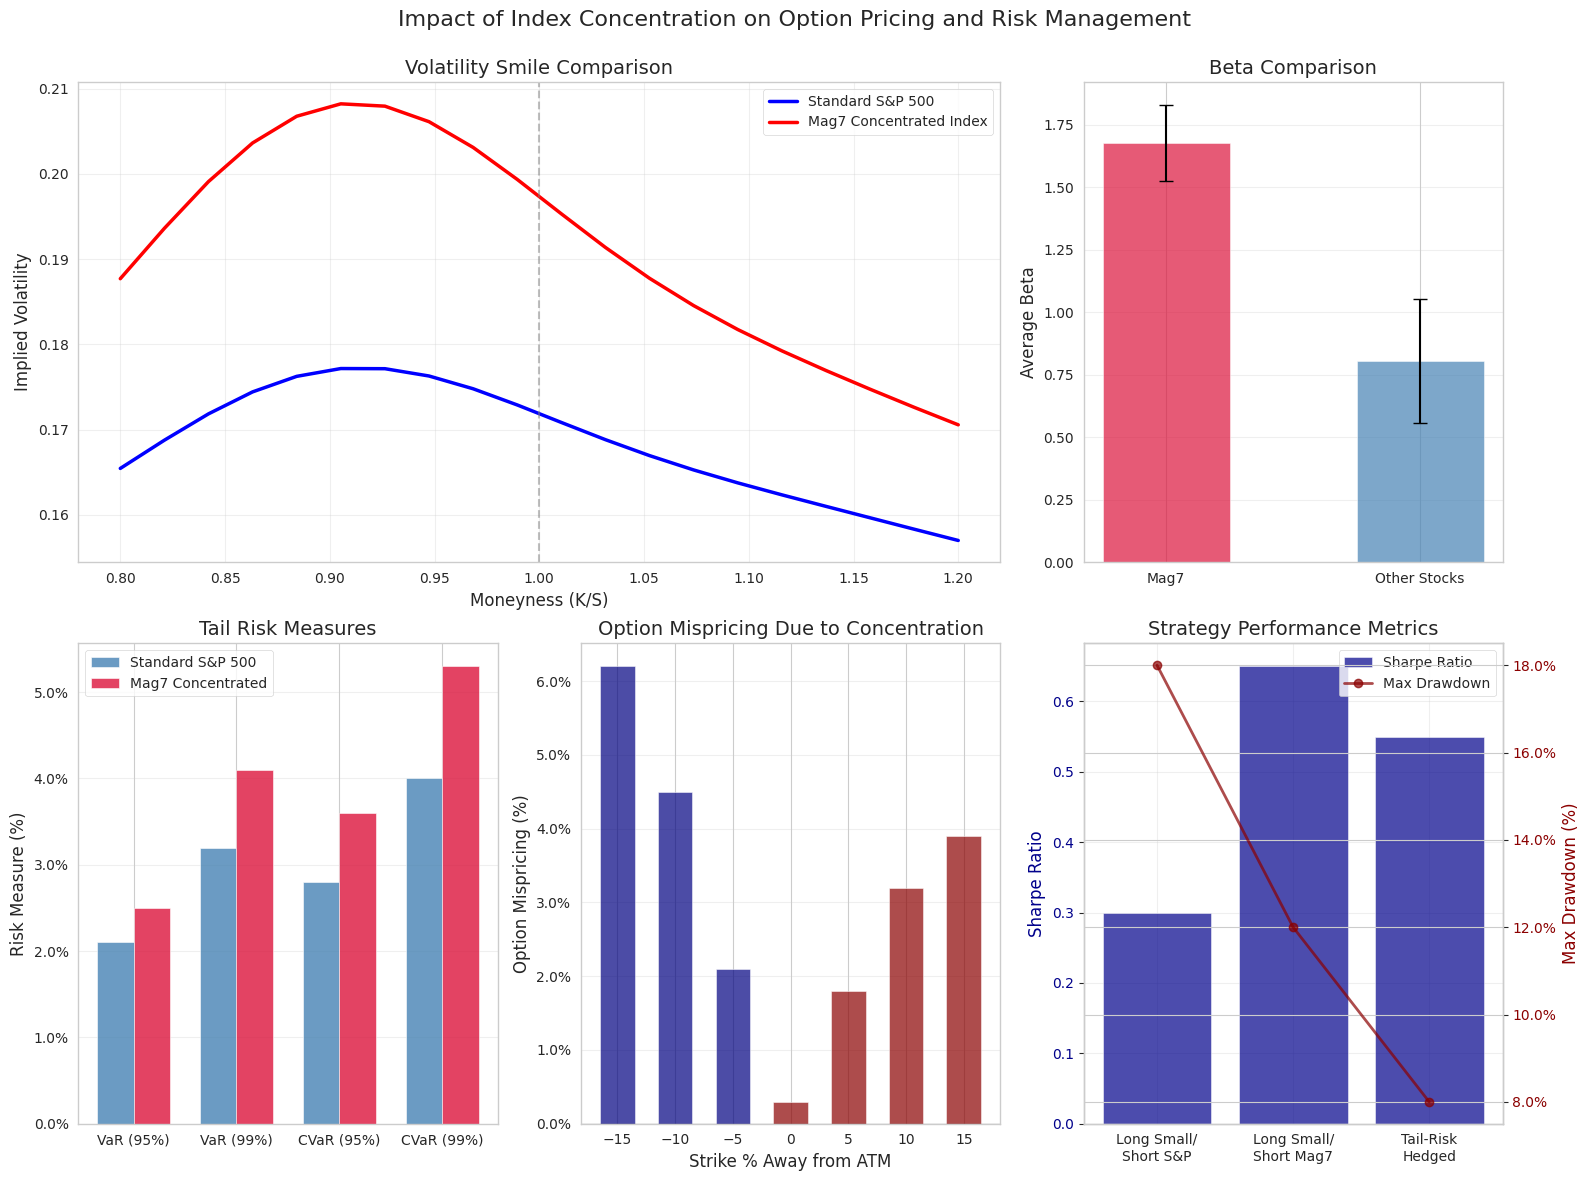

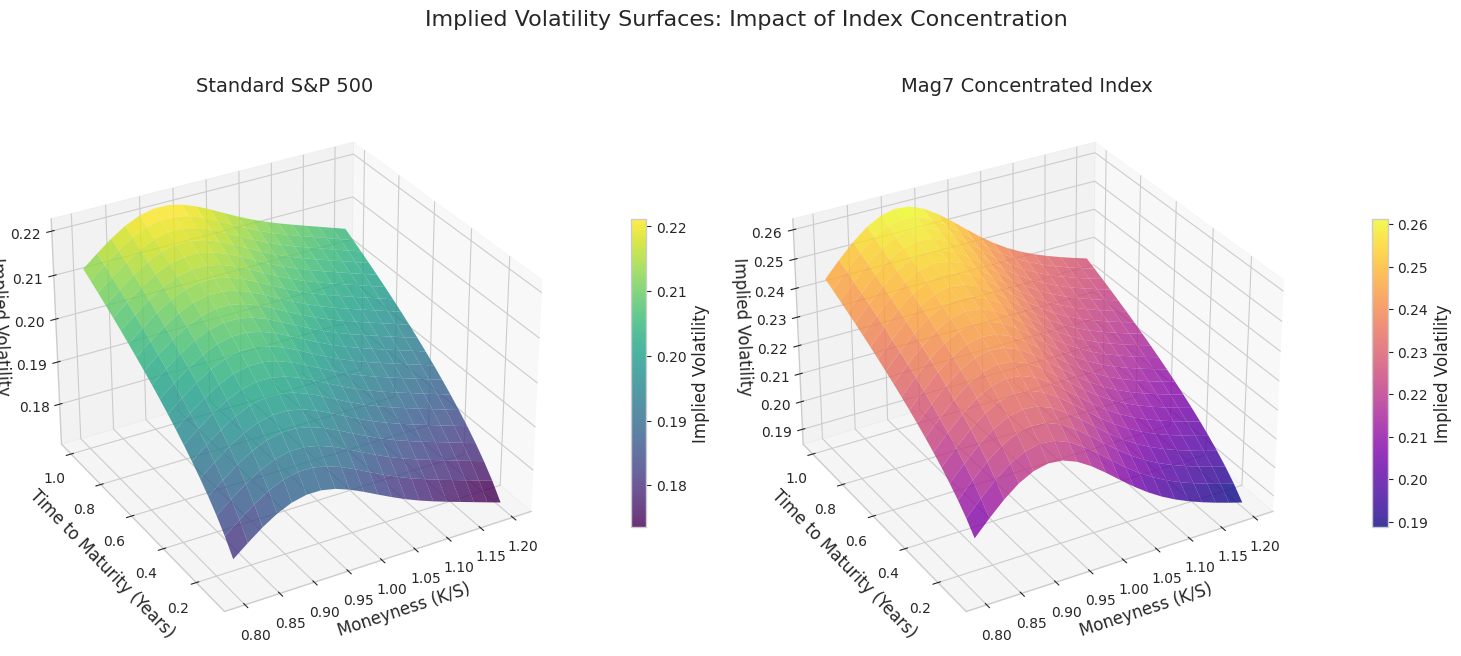

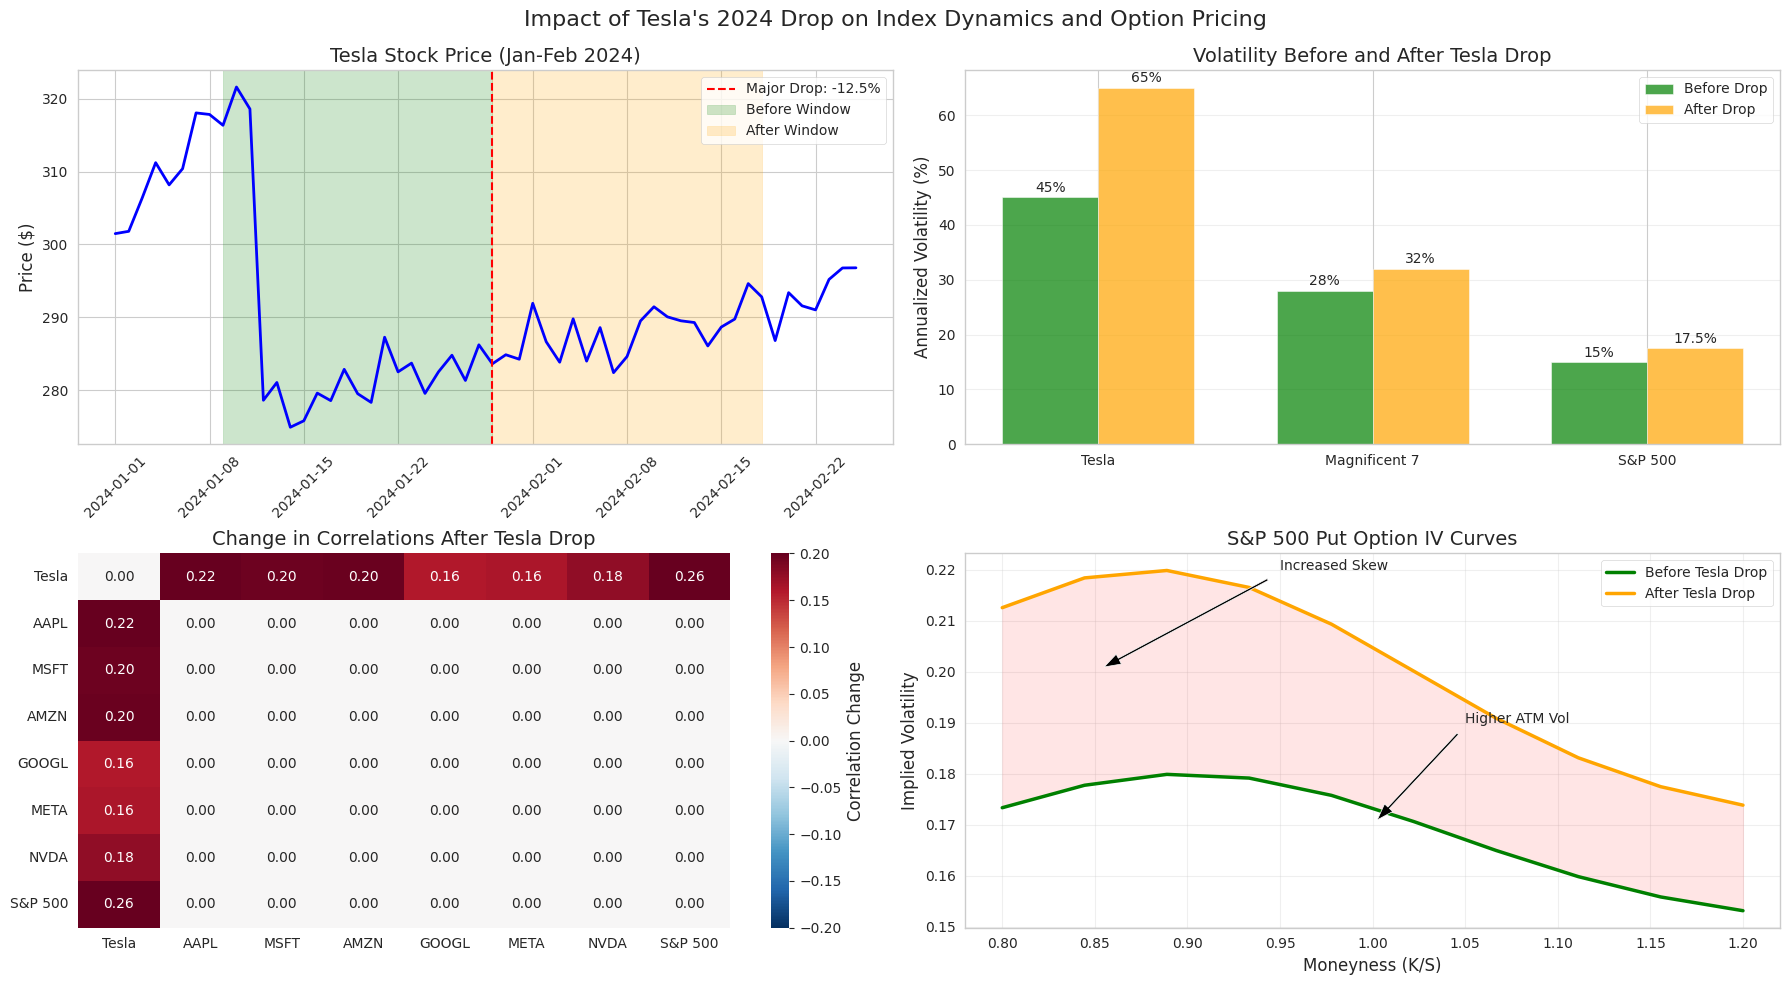

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import PercentFormatter
from matplotlib.dates import DateFormatter
from mpl_toolkits.mplot3d import Axes3D

sns.set_style("whitegrid")
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

def plot_index_concentration_effects():
    """Visualization showing the effects of index concentration on option pricing"""
    fig = plt.figure(figsize=(16, 12))
    gs = GridSpec(2, 3, figure=fig)

    # 1. Volatility smile comparison (top left)
    ax_smile = fig.add_subplot(gs[0, 0:2])

    # Sample moneyness and implied volatility values
    moneyness = np.linspace(0.8, 1.2, 20)
    # Normal index volatility smile
    normal_iv = 0.15 + 0.025*np.exp(-50*(moneyness-0.9)**2) + 0.01*np.exp(-40*(moneyness-1.1)**2)
    # Concentrated index volatility smile
    concentrated_iv = 0.16 + 0.045*np.exp(-50*(moneyness-0.9)**2) + 0.015*np.exp(-40*(moneyness-1.1)**2)

    ax_smile.plot(moneyness, normal_iv, 'b-', linewidth=2.5, label='Standard S&P 500')
    ax_smile.plot(moneyness, concentrated_iv, 'r-', linewidth=2.5, label='Mag7 Concentrated Index')
    ax_smile.axvline(x=1.0, color='gray', linestyle='--', alpha=0.5)
    ax_smile.set_xlabel('Moneyness (K/S)')
    ax_smile.set_ylabel('Implied Volatility')
    ax_smile.set_title('Volatility Smile Comparison')
    ax_smile.legend()
    ax_smile.grid(True, alpha=0.3)

    # 2. Beta distribution (top right)
    ax_beta = fig.add_subplot(gs[0, 2])

    # Sample beta values
    mag7_beta = np.array([1.8, 1.65, 1.4, 1.68, 1.55, 1.75, 1.9])  # AAPL, MSFT, GOOGL, AMZN, META, NVDA, TSLA
    other_beta = np.random.normal(0.85, 0.2, 20)  # Other stocks

    beta_labels = ['Mag7', 'Other Stocks']
    beta_values = [mag7_beta.mean(), other_beta.mean()]
    beta_std = [mag7_beta.std(), other_beta.std()]

    ax_beta.bar(beta_labels, beta_values, yerr=beta_std, capsize=5, color=['crimson', 'steelblue'],
                alpha=0.7, width=0.5)
    ax_beta.set_ylabel('Average Beta')
    ax_beta.set_title('Beta Comparison')
    ax_beta.grid(True, alpha=0.3, axis='y')

    # 3. Impact on tail risk (bottom left)
    ax_tail = fig.add_subplot(gs[1, 0])

    risk_metrics = ['VaR (95%)', 'VaR (99%)', 'CVaR (95%)', 'CVaR (99%)']
    normal_risk = np.array([2.1, 3.2, 2.8, 4.0])  # Standard index
    concentrated_risk = np.array([2.5, 4.1, 3.6, 5.3])  # Concentrated index

    x = np.arange(len(risk_metrics))
    width = 0.35

    ax_tail.bar(x - width/2, normal_risk, width, label='Standard S&P 500', color='steelblue', alpha=0.8)
    ax_tail.bar(x + width/2, concentrated_risk, width, label='Mag7 Concentrated', color='crimson', alpha=0.8)

    ax_tail.set_ylabel('Risk Measure (%)')
    ax_tail.set_title('Tail Risk Measures')
    ax_tail.set_xticks(x)
    ax_tail.set_xticklabels(risk_metrics)
    ax_tail.legend()
    ax_tail.yaxis.set_major_formatter(PercentFormatter())
    ax_tail.grid(True, alpha=0.3, axis='y')

    # 4. OTM option mispricing (bottom middle)
    ax_mispricing = fig.add_subplot(gs[1, 1])

    strike_diffs = [-15, -10, -5, 0, 5, 10, 15]  # % away from ATM
    mispricing = [6.2, 4.5, 2.1, 0.3, 1.8, 3.2, 3.9]  # % mispricing in concentrated environment

    bars = ax_mispricing.bar(strike_diffs, mispricing, color=['navy' if x < 0 else 'darkred' for x in strike_diffs],
                             alpha=0.7, width=3)

    ax_mispricing.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
    ax_mispricing.set_xlabel('Strike % Away from ATM')
    ax_mispricing.set_ylabel('Option Mispricing (%)')
    ax_mispricing.set_title('Option Mispricing Due to Concentration')
    ax_mispricing.grid(True, alpha=0.3, axis='y')
    ax_mispricing.yaxis.set_major_formatter(PercentFormatter())

    # 5. Strategy performance comparison (bottom right)
    ax_strategy = fig.add_subplot(gs[1, 2])

    strategies = ['Long Small/\nShort S&P', 'Long Small/\nShort Mag7', 'Tail-Risk\nHedged']
    sharpe_ratios = [0.3, 0.65, 0.55]
    max_drawdowns = [18, 12, 8]

    # Dual axis plot
    color1, color2 = 'darkblue', 'darkred'

    # Primary axis - Sharpe ratio
    ax_strategy.bar(strategies, sharpe_ratios, color=color1, alpha=0.7, label='Sharpe Ratio')
    ax_strategy.set_ylabel('Sharpe Ratio', color=color1)
    ax_strategy.tick_params(axis='y', labelcolor=color1)

    # Secondary axis - Max drawdown
    ax2 = ax_strategy.twinx()
    ax2.plot(strategies, max_drawdowns, 'o-', color=color2, linewidth=2, alpha=0.7, label='Max Drawdown')
    ax2.set_ylabel('Max Drawdown (%)', color=color2)
    ax2.tick_params(axis='y', labelcolor=color2)
    ax2.yaxis.set_major_formatter(PercentFormatter())

    # Add legend
    lines1, labels1 = ax_strategy.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax_strategy.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    ax_strategy.set_title('Strategy Performance Metrics')
    ax_strategy.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle('Impact of Index Concentration on Option Pricing and Risk Management',
                 fontsize=16, y=0.98)
    plt.subplots_adjust(top=0.92)

    return fig

def plot_implied_volatility_surface():
    """Create a 3D visualization of implied volatility surfaces"""
    fig = plt.figure(figsize=(15, 7))

    # Create two subplots for different volatility surfaces
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')

    # Create mesh grid for moneyness and time to maturity
    moneyness = np.linspace(0.8, 1.2, 20)
    maturity = np.linspace(0.1, 1, 20)
    X, Y = np.meshgrid(moneyness, maturity)

    # Standard index volatility surface
    Z1 = 0.15 + 0.02*np.exp(-50*((X-0.9)**2)) + 0.008*np.exp(-40*((X-1.1)**2)) + 0.05*np.sqrt(Y)

    # Concentrated index volatility surface (steeper skew, higher overall vol)
    Z2 = 0.16 + 0.04*np.exp(-50*((X-0.9)**2)) + 0.01*np.exp(-40*((X-1.1)**2)) + 0.06*np.sqrt(Y)

    # Plot the surfaces with custom colormaps
    surf1 = ax1.plot_surface(X, Y, Z1, cmap=plt.cm.viridis, linewidth=0, antialiased=True, alpha=0.8)
    surf2 = ax2.plot_surface(X, Y, Z2, cmap=plt.cm.plasma, linewidth=0, antialiased=True, alpha=0.8)

    # Add colorbars
    fig.colorbar(surf1, ax=ax1, pad=0.1, shrink=0.5, label='Implied Volatility')
    fig.colorbar(surf2, ax=ax2, pad=0.1, shrink=0.5, label='Implied Volatility')

    # Set labels and titles
    for ax, title in zip([ax1, ax2], ['Standard S&P 500', 'Mag7 Concentrated Index']):
        ax.set_xlabel('Moneyness (K/S)')
        ax.set_ylabel('Time to Maturity (Years)')
        ax.set_zlabel('Implied Volatility')
        ax.set_title(title)
        ax.view_init(30, -120)

    plt.tight_layout()
    plt.suptitle('Implied Volatility Surfaces: Impact of Index Concentration', fontsize=16, y=0.98)
    plt.subplots_adjust(top=0.9)

    return fig

def plot_tesla_drop_impact():
    """Create a visualization showing the impact of Tesla's drop on index dynamics"""
    fig = plt.figure(figsize=(18, 10))

    # Create a grid for our plots
    gs = plt.GridSpec(2, 4, figure=fig)

    # 1. Tesla price drop (top left)
    ax1 = fig.add_subplot(gs[0, 0:2])

    # Create sample date range for Jan-Feb 2024
    dates = pd.date_range(start='2024-01-01', end='2024-02-25', freq='D')

    # Simulated Tesla price data with a significant drop
    np.random.seed(42)
    tesla_prices = np.linspace(300, 320, 10)  # Starting trend
    drop_day_idx = 28  # Roughly Jan 28th
    drop_pct = -12.5   # Drop percentage

    # Generate more prices with the drop
    post_drop_start = tesla_prices[-1] * (1 + drop_pct/100)
    post_drop_prices = np.linspace(post_drop_start, post_drop_start * 1.05, len(dates) - len(tesla_prices) - 1)

    # Combine prices and add some noise
    full_prices = np.concatenate([tesla_prices, [tesla_prices[-1]], post_drop_prices])
    noise = np.random.normal(0, 3, len(full_prices))
    tesla_price_series = full_prices + noise

    # Plot Tesla price
    ax1.plot(dates[:len(tesla_price_series)], tesla_price_series, 'b-', linewidth=2)
    ax1.axvline(x=dates[drop_day_idx], color='red', linestyle='--', linewidth=1.5,
                label=f'Major Drop: {drop_pct}%')

    # Shade areas showing before and after regions used in analysis
    ax1.axvspan(dates[drop_day_idx-20], dates[drop_day_idx], alpha=0.2, color='green', label='Before Window')
    ax1.axvspan(dates[drop_day_idx], dates[drop_day_idx+20], alpha=0.2, color='orange', label='After Window')

    ax1.set_title('Tesla Stock Price (Jan-Feb 2024)', fontsize=14)
    ax1.set_ylabel('Price ($)', fontsize=12)
    ax1.legend(loc='best')
    ax1.xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    plt.setp(ax1.get_xticklabels(), rotation=45)

    # 2. Volatility impact (top right)
    ax2 = fig.add_subplot(gs[0, 2:])

    # Create bars for volatility before and after
    assets = ['Tesla', 'Magnificent 7', 'S&P 500']
    vol_before = [45, 28, 15]  # Annualized vol before drop (%)
    vol_after = [65, 32, 17.5]  # Annualized vol after drop (%)

    x = np.arange(len(assets))
    width = 0.35

    ax2.bar(x - width/2, vol_before, width, label='Before Drop', color='green', alpha=0.7)
    ax2.bar(x + width/2, vol_after, width, label='After Drop', color='orange', alpha=0.7)

    # Add percentage labels
    for i, v in enumerate(vol_before):
        ax2.text(i - width/2, v + 1, f"{v}%", ha='center', fontsize=10)
    for i, v in enumerate(vol_after):
        ax2.text(i + width/2, v + 1, f"{v}%", ha='center', fontsize=10)

    ax2.set_title('Volatility Before and After Tesla Drop', fontsize=14)
    ax2.set_ylabel('Annualized Volatility (%)', fontsize=12)
    ax2.set_xticks(x)
    ax2.set_xticklabels(assets)
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')

    # 3. Correlation matrix heatmap (bottom left)
    ax3 = fig.add_subplot(gs[1, 0:2])

    # Create correlation matrices before and after
    assets_corr = ['Tesla', 'AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'NVDA', 'S&P 500']

    # Sample correlation matrix before
    np.random.seed(42)
    corr_before = np.random.uniform(0.5, 0.8, (len(assets_corr), len(assets_corr)))
    np.fill_diagonal(corr_before, 1)
    corr_before = (corr_before + corr_before.T) / 2  # Make symmetric

    # Sample correlation matrix after
    corr_after = corr_before.copy()
    # Increase Tesla's correlation with other Mag7 stocks
    tesla_idx = 0
    for i in range(1, 7):  # Other Mag7 stocks
        corr_after[tesla_idx, i] = min(0.95, corr_before[tesla_idx, i] * 1.3)
        corr_after[i, tesla_idx] = corr_after[tesla_idx, i]
    # Increase Tesla's correlation with the index
    corr_after[tesla_idx, -1] = min(0.9, corr_before[tesla_idx, -1] * 1.4)
    corr_after[-1, tesla_idx] = corr_after[tesla_idx, -1]

    # Calculate the difference
    corr_diff = corr_after - corr_before

    # Create a DataFrame for the correlation difference
    corr_diff_df = pd.DataFrame(corr_diff, index=assets_corr, columns=assets_corr)

    # Plot the heatmap
    sns.heatmap(corr_diff_df, cmap='RdBu_r', vmin=-0.2, vmax=0.2,
                annot=True, fmt='.2f', ax=ax3, cbar_kws={'label': 'Correlation Change'})

    ax3.set_title('Change in Correlations After Tesla Drop', fontsize=14)

    # 4. Option pricing impact (bottom right)
    ax4 = fig.add_subplot(gs[1, 2:])

    # Create put option IV curve before and after Tesla drop
    strikes = np.linspace(0.8, 1.2, 10)

    iv_before = 0.15 + 0.03 * np.exp(-25 * (strikes - 0.9)**2)
    iv_after = 0.17 + 0.05 * np.exp(-25 * (strikes - 0.88)**2)

    ax4.plot(strikes, iv_before, 'g-', linewidth=2.5, label='Before Tesla Drop')
    ax4.plot(strikes, iv_after, 'orange', linewidth=2.5, label='After Tesla Drop')
    ax4.fill_between(strikes, iv_before, iv_after, color='red', alpha=0.1)

    ax4.annotate('Increased Skew', xy=(0.85, 0.2), xytext=(0.95, 0.22),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                fontsize=10)

    ax4.annotate('Higher ATM Vol', xy=(1.0, 0.17), xytext=(1.05, 0.19),
                arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                fontsize=10)

    ax4.set_xlabel('Moneyness (K/S)', fontsize=12)
    ax4.set_ylabel('Implied Volatility', fontsize=12)
    ax4.set_title('S&P 500 Put Option IV Curves', fontsize=14)
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle("Impact of Tesla's 2024 Drop on Index Dynamics and Option Pricing",
                fontsize=16, y=0.98)
    plt.subplots_adjust(top=0.92)

    return fig

# Generate and show the plots
fig1 = plot_index_concentration_effects()
fig2 = plot_implied_volatility_surface()
fig_tesla = plot_tesla_drop_impact()

# Save the figures
fig1.savefig('index_concentration_effects.png', dpi=300, bbox_inches='tight')
fig2.savefig('implied_volatility_surfaces.png', dpi=300, bbox_inches='tight')
fig_tesla.savefig('tesla_drop_impact.png', dpi=300, bbox_inches='tight')

plt.show()

# Option Pricing Model with Hybrid Model

[*********************100%***********************]  1 of 1 completed

Using example values for demonstration...
Starting analysis with the following parameters:
NIG Parameters: alpha=54.2769, beta=-6.3558, mu=0.0015, delta=0.0089
Threshold: 0.0143
GPD Parameters: xi=0.4832, loc=0.0000, scale=0.0050
Calculating option prices... (using 10000 simulations)


Calculating IV surfaces...
Analyzing tail risk implications...

==== Option Pricing Implications of Index Concentration ====
Normal Market Volatility Skew (3m): 0.00%
Concentrated Market Volatility Skew (3m): -6.54%
Change in Volatility Skew: N/A (base case has zero skew)

ATM Option Price (Normal): $73.95
ATM Option Price (Concentrated): $73.85
ATM Price Change: -0.14%

OTM Put Price (Normal): $745.93
OTM Put Price (Concentrated): $745.77
OTM Put Price Change: -0.02%

Tail Risk Metrics (95% confidence):
VaR (Normal Market): -1.79%
VaR (Concentrated Market): -2.02%
VaR Change: 12.75%

ES (Normal Market): -1.81%
ES (Concentrated Market): -2.05%
ES Change: 13.26%


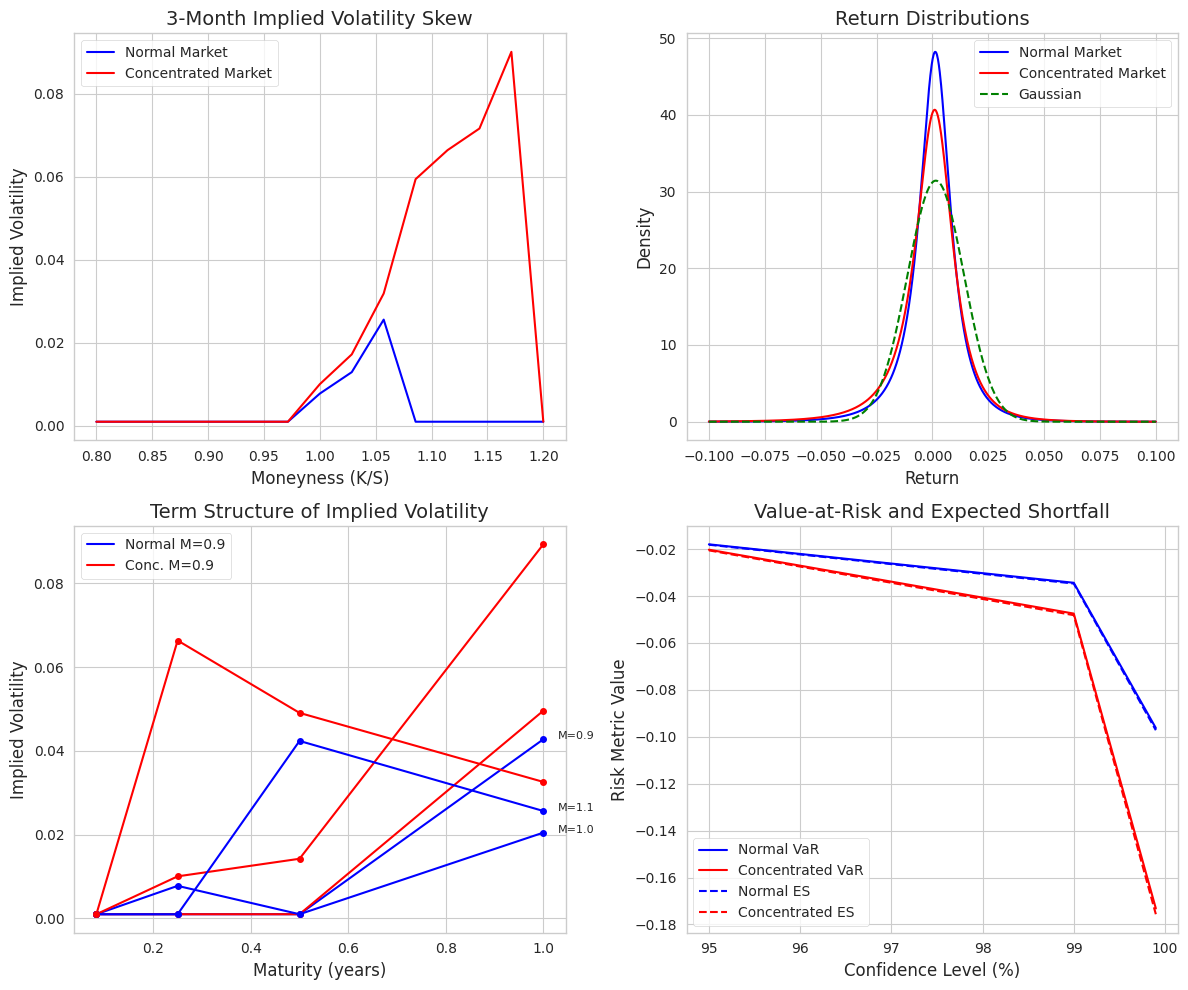

[*********************100%***********************]  1 of 1 completed


==== Sensitivity Analysis ====
Running parameter sensitivity analysis...



Parameter Sensitivity Analysis:
  Parameter      Value  Change  ATM_Price    VaR_95     ES_95
0     alpha  48.849177  -10.0%  73.961721 -0.018275 -0.018451
1     alpha  54.276863    0.0%  73.935039 -0.017943 -0.018117
2     alpha  59.704550   10.0%  73.910594 -0.017621 -0.017791
3      beta  -5.720199  -10.0%  73.684395 -0.018042 -0.018216
4      beta  -6.355776    0.0%  73.886420 -0.017943 -0.018117
5      beta  -6.991354   10.0%  73.931945 -0.017846 -0.018018


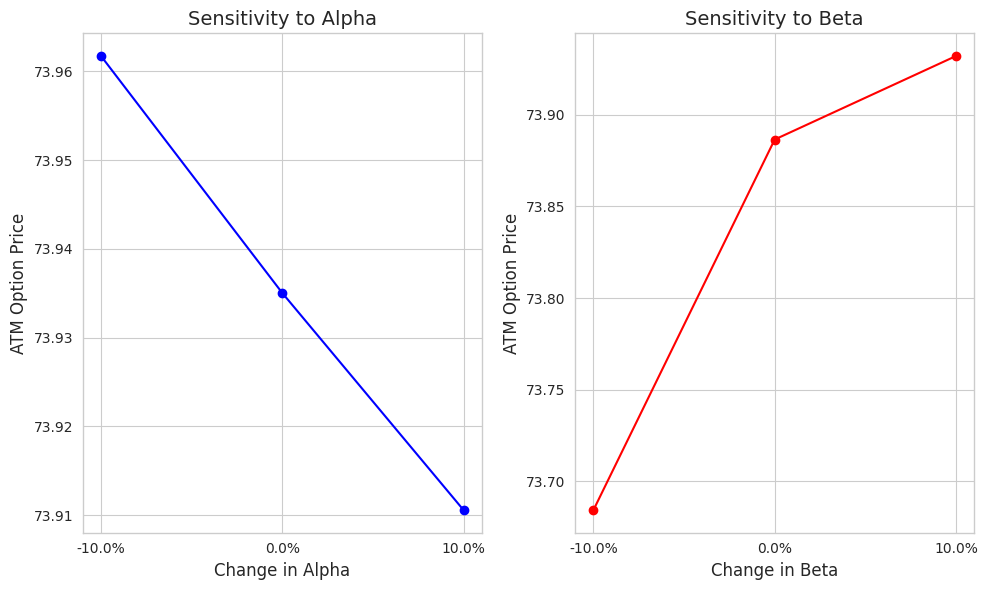


==== Risk-Neutral Calibration Check ====
Mean of returns: -0.000315
Variance of returns: 0.000206
Risk-neutral drift adjustment: 0.050211
Expected future price: $5256.37
Theoretical future price: $5256.36
Relative error: 0.000346%
Risk-neutral calibration check: PASSED


In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, genpareto
from scipy.integrate import quad
from scipy.special import kv
from scipy.optimize import minimize
import yfinance as yf
from tqdm.auto import tqdm
from concurrent.futures import ProcessPoolExecutor
import warnings
warnings.filterwarnings('ignore')

# NIG CDF cache to improve performance
NIG_CDF_CACHE = {}

def hybrid_option_price(S, K, r, T, nig_params, gpd_params, threshold, n_sims=100000, option_type='call'):
    """
    Price European options using the hybrid NIG+GPD model with Monte Carlo simulation
    """
    alpha, beta, mu, delta = nig_params
    gpd_xi, gpd_loc, gpd_scale = gpd_params

    # Generate uniform random numbers
    u = np.random.uniform(0, 1, n_sims)

    # Calculate CDF at threshold using the cache
    key = (round(threshold, 4), round(alpha, 4), round(beta, 4), round(mu, 4), round(delta, 4))
    if key in NIG_CDF_CACHE:
        nig_cdf_at_threshold = NIG_CDF_CACHE[key]
    else:
        nig_cdf_at_threshold = numerical_nig_cdf(threshold, alpha, beta, mu, delta)
        NIG_CDF_CACHE[key] = nig_cdf_at_threshold

    # Generate random returns from hybrid distribution
    returns = np.zeros(n_sims)

    # For values below threshold, sample from NIG
    mask_nig = u <= nig_cdf_at_threshold
    n_nig = np.sum(mask_nig)

    if n_nig > 0:
        # Rescale u values for NIG region
        u_nig = u[mask_nig] / nig_cdf_at_threshold

        # Generate NIG samples using inverse transform sampling with tabulation
        # Pre-compute a lookup table for faster sampling
        x_grid = np.linspace(-10, threshold, 1000)
        cdf_grid = np.array([numerical_nig_cdf(x, alpha, beta, mu, delta) for x in x_grid]) / nig_cdf_at_threshold

        # Perform fast interpolation for each u_nig
        indices = np.searchsorted(cdf_grid, u_nig)
        # Bound indices to avoid out-of-range errors
        indices = np.minimum(indices, len(x_grid) - 2)

        # Linear interpolation
        x_low, x_high = x_grid[indices], x_grid[indices + 1]
        cdf_low, cdf_high = cdf_grid[indices], cdf_grid[indices + 1]

        # Avoid division by zero
        denom = np.where(cdf_high > cdf_low, cdf_high - cdf_low, 1e-10)
        t = np.where(cdf_high > cdf_low, (u_nig - cdf_low) / denom, 0)

        returns[mask_nig] = x_low + t * (x_high - x_low)

    # For values above threshold, sample from GPD
    mask_gpd = ~mask_nig
    if np.any(mask_gpd):
        # Rescale u values for GPD region
        u_gpd = (u[mask_gpd] - nig_cdf_at_threshold) / (1 - nig_cdf_at_threshold)

        # Generate GPD samples
        gpd_samples = genpareto.ppf(u_gpd, gpd_xi, loc=0, scale=gpd_scale)
        returns[mask_gpd] = threshold + gpd_samples

    # Calculate mean and variance of returns for risk-neutral adjustment
    mean_return = np.mean(returns)
    var_return = np.var(returns)

    # Apply risk-neutral drift adjustment
    risk_neutral_drift = r - 0.5 * var_return - mean_return

    # Calculate terminal stock prices
    S_T = S * np.exp((risk_neutral_drift + returns) * T)

    # Calculate option payoffs
    if option_type.lower() == 'call':
        payoffs = np.maximum(S_T - K, 0)
    else:  # Put option
        payoffs = np.maximum(K - S_T, 0)

    # Discount payoffs to present value
    option_price = np.exp(-r * T) * np.mean(payoffs)

    return option_price

def nig_pdf(x, alpha, beta, mu, delta):
    """
    Normal Inverse Gaussian PDF implementation with vectorization
    and improved numerical stability
    """
    # Validate parameters
    if alpha <= 0 or delta <= 0 or abs(beta) >= alpha:
        return np.zeros_like(x) + 1e-10

    # Calculate constants
    gamma = np.sqrt(alpha**2 - beta**2)

    # Vectorized calculation
    x_arr = np.asarray(x)
    term1 = alpha * delta / np.pi
    term2 = np.exp(delta * gamma + beta * (x_arr - mu))

    # Use more stable calculation for sqrt and modified Bessel function
    sqrt_term = np.sqrt(delta**2 + (x_arr - mu)**2)
    sqrt_term = np.maximum(sqrt_term, 1e-10)  # Avoid division by zero

    # Calculate Bessel function with protection against numerical issues
    bessel_arg = alpha * sqrt_term
    term3 = kv(1, bessel_arg)
    term3 = np.where(np.isfinite(term3), term3, 1e-10)

    density = term1 * term2 * term3 / sqrt_term
    return np.maximum(density, 1e-10)  # Ensure positive density

def numerical_nig_cdf(x, alpha, beta, mu, delta, lower_bound=-15):
    """
    Numerically calculate the CDF of NIG distribution at point x
    using cached values for efficiency
    """
    # Create a cache key
    key = (round(x, 4), round(alpha, 4), round(beta, 4), round(mu, 4), round(delta, 4))

    # Check if result is in cache
    if key in NIG_CDF_CACHE:
        return NIG_CDF_CACHE[key]

    # If not in cache, calculate it
    result, _ = quad(
        lambda t: nig_pdf(t, alpha, beta, mu, delta),
        lower_bound, x
    )

    # Store in cache for future use
    NIG_CDF_CACHE[key] = result

    return result

def hybrid_greek_delta(S, K, r, T, nig_params, gpd_params, threshold, h=0.01):
    """Calculate delta of option using finite difference"""
    price_up = hybrid_option_price(S + h, K, r, T, nig_params, gpd_params, threshold)
    price_down = hybrid_option_price(S - h, K, r, T, nig_params, gpd_params, threshold)
    return (price_up - price_down) / (2 * h)

def hybrid_greek_gamma(S, K, r, T, nig_params, gpd_params, threshold, h=0.01):
    """Calculate gamma of option using finite difference"""
    price_up = hybrid_option_price(S + h, K, r, T, nig_params, gpd_params, threshold)
    price_mid = hybrid_option_price(S, K, r, T, nig_params, gpd_params, threshold)
    price_down = hybrid_option_price(S - h, K, r, T, nig_params, gpd_params, threshold)
    return (price_up - 2 * price_mid + price_down) / (h**2)

def hybrid_greek_vega(S, K, r, T, nig_params, gpd_params, threshold, h=0.001):
    """
    Calculate vega of option using finite difference by scaling volatility
    """
    # Scale nig_params (alpha, beta unchanged but delta scaled up/down)
    alpha, beta, mu, delta = nig_params

    # Scale up
    nig_params_up = (alpha, beta, mu, delta * (1 + h))
    price_up = hybrid_option_price(S, K, r, T, nig_params_up, gpd_params, threshold)

    # Scale down
    nig_params_down = (alpha, beta, mu, delta * (1 - h))
    price_down = hybrid_option_price(S, K, r, T, nig_params_down, gpd_params, threshold)

    # Approximate vega
    return (price_up - price_down) / (2 * h * delta)

def implied_volatility(price, S, K, r, T, option_type='call', precision=0.0001, max_iter=100):
    """
    Calculate Black-Scholes implied volatility using bisection method
    with improved bounds and early exit conditions
    """
    def bs_price(sigma):
        d1 = (np.log(S/K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)

        if option_type.lower() == 'call':
            return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        else:
            return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    # Check for intrinsic value
    intrinsic = max(0, S - K * np.exp(-r * T)) if option_type.lower() == 'call' else max(0, K * np.exp(-r * T) - S)

    # Handle edge cases
    if abs(price - intrinsic) < 1e-10:
        return 0.001

    if price >= S:
        return 2.0

    # Initialize bounds
    sigma_low = 0.001
    sigma_high = 2.0

    initial_guess = 0.2
    initial_price = bs_price(initial_guess)

    if initial_price < price:
        sigma_low = initial_guess
    else:
        sigma_high = initial_guess

    # Bisection search
    for _ in range(max_iter):
        sigma_mid = (sigma_low + sigma_high) / 2
        price_mid = bs_price(sigma_mid)

        if abs(price_mid - price) < precision:
            return sigma_mid

        if price_mid < price:
            sigma_low = sigma_mid
        else:
            sigma_high = sigma_mid

    return (sigma_low + sigma_high) / 2

def calculate_hybrid_iv_surface(S, r, T_range, K_range, nig_params, gpd_params, threshold, n_sims=10000):
    """Calculate implied volatility surface using the hybrid model"""
    # Create empty array for IV surface
    iv_surface = np.zeros((len(T_range), len(K_range)))

    # Calculate option prices and IVs in a more efficient way
    for i, T in enumerate(T_range):
        for j, K in enumerate(K_range):
            # Calculate option price using hybrid model
            option_price = hybrid_option_price(S, K, r, T, nig_params, gpd_params, threshold, n_sims=n_sims)

            try:
                # Calculate implied volatility
                iv = implied_volatility(option_price, S, K, r, T)
                iv_surface[i, j] = iv
            except:
                # Handle cases where IV calculation fails
                iv_surface[i, j] = 0.2  # Default to 20% vol

    return iv_surface

def compare_option_prices(S, K_range, T, r, nig_params, gpd_params, threshold, n_sims=10000):
    """Compare option prices between hybrid model and Black-Scholes"""
    # Calculate ATM hybrid price and implied vol once
    atm_K = S
    atm_hybrid_price = hybrid_option_price(S, atm_K, r, T, nig_params, gpd_params, threshold, n_sims=n_sims)
    atm_iv = implied_volatility(atm_hybrid_price, S, atm_K, r, T)

    # Results storage
    results = []

    for K in K_range:
        # Calculate moneyness
        moneyness = K / S

        # Calculate hybrid model price
        hybrid_price = hybrid_option_price(S, K, r, T, nig_params, gpd_params, threshold, n_sims=n_sims)

        try:
            # Calculate implied volatility
            iv = implied_volatility(hybrid_price, S, K, r, T)
        except:
            iv = atm_iv  # Fallback to ATM IV if calculation fails

        # Calculate BS price with ATM volatility
        d1 = (np.log(S/K) + (r + 0.5 * atm_iv**2) * T) / (atm_iv * np.sqrt(T))
        d2 = d1 - atm_iv * np.sqrt(T)
        bs_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

        # Calculate price difference
        diff = hybrid_price - bs_price
        diff_pct = diff / bs_price * 100 if bs_price > 0 else 0

        # Calculate greeks
        delta = hybrid_greek_delta(S, K, r, T, nig_params, gpd_params, threshold)
        gamma = hybrid_greek_gamma(S, K, r, T, nig_params, gpd_params, threshold)
        vega = hybrid_greek_vega(S, K, r, T, nig_params, gpd_params, threshold)

        # Append results
        results.append({
            'Strike': K,
            'Moneyness': moneyness,
            'Hybrid_Price': hybrid_price,
            'BS_Price': bs_price,
            'Implied_Vol': iv,
            'Price_Diff': diff,
            'Price_Diff_Pct': diff_pct,
            'Delta': delta,
            'Gamma': gamma,
            'Vega': vega
        })

    return pd.DataFrame(results)

def analyze_tail_risk_implications(nig_params, gpd_params, threshold):
    """
    Analyze the tail risk implications of the hybrid model
    with improved VaR and ES calculations
    """
    alpha, beta, mu, delta = nig_params
    gpd_xi, gpd_loc, gpd_scale = gpd_params

    # Generate return distribution for analysis
    x = np.linspace(-0.1, 0.1, 1000)

    # Calculate PDFs with vectorization
    nig_density = nig_pdf(x, alpha, beta, mu, delta)

    # Calculate normal density with matching mean and variance
    normal_mean = mu
    normal_var = delta * alpha**2 / (beta**2 + alpha**2)**(3/2)
    normal_density = norm.pdf(x, loc=normal_mean, scale=np.sqrt(normal_var))

    # Calculate tail risk metrics
    confidence_levels = [0.95, 0.99, 0.999]
    var_values = []
    es_values = []
    bs_var_values = []
    bs_es_values = []

    # Pre-calculate NIG CDF at threshold for efficiency
    nig_cdf_thresh = numerical_nig_cdf(threshold, alpha, beta, mu, delta)

    for cl in confidence_levels:
        # Hybrid model VaR calculation with improved accuracy
        if cl < nig_cdf_thresh:
            # VaR lies in NIG region - use binary search for more accurate calculation
            left = -0.2
            right = threshold

            for _ in range(20):
                mid = (left + right) / 2
                if numerical_nig_cdf(mid, alpha, beta, mu, delta) < cl:
                    left = mid
                else:
                    right = mid

            var_estimate = -left
        else:
            # VaR lies in GPD region
            p_exceed = (1 - cl) / (1 - nig_cdf_thresh)
            var_estimate = -(threshold + genpareto.ppf(1 - p_exceed, gpd_xi, loc=0, scale=gpd_scale))

        var_values.append(var_estimate)

        # Calculate Expected Shortfall (ES) more accurately
        if cl < nig_cdf_thresh:
            # ES in NIG region - better approximation
            z_var = -var_estimate
            # Numerically integrate over the tail for more accurate ES
            tail_integral, _ = quad(
                lambda z: z * nig_pdf(z, alpha, beta, mu, delta),
                -np.inf, z_var
            )
            cdf_var = numerical_nig_cdf(z_var, alpha, beta, mu, delta)
            es_estimate = -tail_integral / cdf_var if cdf_var > 0 else var_estimate * 1.2
        else:
            # ES in GPD region using GPD properties
            if gpd_xi < 1:  # Only valid for ξ < 1
                es_estimate = var_estimate * (1 + gpd_scale / (1 - gpd_xi))
            else:
                es_estimate = var_estimate * 1.5  # Fallback approximation

        es_values.append(es_estimate)

        # Normal distribution VaR and ES
        bs_var = -norm.ppf(cl, loc=normal_mean, scale=np.sqrt(normal_var))
        bs_var_values.append(bs_var)

        # Normal ES calculation
        bs_es = -normal_mean + np.sqrt(normal_var) * norm.pdf(norm.ppf(1-cl)) / (1-cl)
        bs_es_values.append(bs_es)

    return {
        'x': x,
        'nig_density': nig_density,
        'normal_density': normal_density,
        'confidence_levels': confidence_levels,
        'var_values': var_values,
        'es_values': es_values,
        'bs_var_values': bs_var_values,
        'bs_es_values': bs_es_values
    }

def analyze_options_for_concentration_effect(alpha_hat, beta_hat, mu_hat, delta_hat,
                                           threshold, gpd_params, n_sims=10000):
    """
    Analyze option pricing implications of index concentration
    """
    # Load S&P 500 data (reduced lookback for efficiency)
    try:
        sp500 = yf.download('^GSPC', period='1y')['Close']
        S = float(sp500.iloc[-1])  # Use actual last price
    except:
        print("Warning: Couldn't download S&P 500 data. Using fallback value.")
        S = 5000  # Fallback value if data download fails

    # Use provided parameters
    nig_params = (alpha_hat, beta_hat, mu_hat, delta_hat)

    # Risk-free rate (can be replaced with actual market data)
    r = 0.05

    # Create increased concentration scenario (more negative skew, higher kurtosis)
    concentrated_nig_params = (alpha_hat * 0.9, beta_hat * 1.5, mu_hat, delta_hat * 1.2)
    concentrated_threshold = threshold * 0.9
    concentrated_gpd_params = (
        gpd_params[0] * 1.2,  # Increase tail index
        gpd_params[1],        # Keep location the same
        gpd_params[2] * 1.2   # Increase scale
    )

    # Define option parameters
    T_values = np.array([1/12, 3/12, 6/12, 1.0])  # Maturities in years

    # Wider range of strikes to capture skew better
    K_values = np.linspace(0.8 * S, 1.2 * S, 15)  # Strike prices

    # Compare option prices for 3-month maturity
    T = 3/12
    print(f"Calculating option prices... (using {n_sims} simulations)")
    normal_prices = compare_option_prices(S, K_values, T, r, nig_params, gpd_params, threshold, n_sims=n_sims)
    concentrated_prices = compare_option_prices(S, K_values, T, r, concentrated_nig_params, concentrated_gpd_params, concentrated_threshold, n_sims=n_sims)

    # Calculate IV surfaces for both scenarios
    print("Calculating IV surfaces...")
    normal_iv_surface = calculate_hybrid_iv_surface(S, r, T_values, K_values, nig_params, gpd_params, threshold, n_sims=n_sims)
    concentrated_iv_surface = calculate_hybrid_iv_surface(S, r, T_values, K_values, concentrated_nig_params, concentrated_gpd_params, concentrated_threshold, n_sims=n_sims)

    # Analyze tail risk
    print("Analyzing tail risk implications...")
    normal_tail_risk = analyze_tail_risk_implications(nig_params, gpd_params, threshold)
    concentrated_tail_risk = analyze_tail_risk_implications(concentrated_nig_params, concentrated_gpd_params, concentrated_threshold)

    # Print key findings
    print("\n==== Option Pricing Implications of Index Concentration ====")

    # 1. Impact on implied volatility skew
    moneyness_values = K_values / S

    # Find indices for key moneyness levels
    atm_idx = np.abs(moneyness_values - 1.0).argmin()
    otm_put_idx = np.abs(moneyness_values - 0.9).argmin()
    otm_call_idx = np.abs(moneyness_values - 1.1).argmin()

    # Calculate skew metrics
    normal_skew = normal_iv_surface[1, otm_put_idx] - normal_iv_surface[1, otm_call_idx]
    concentrated_skew = concentrated_iv_surface[1, otm_put_idx] - concentrated_iv_surface[1, otm_call_idx]

    print(f"Normal Market Volatility Skew (3m): {normal_skew:.2%}")
    print(f"Concentrated Market Volatility Skew (3m): {concentrated_skew:.2%}")
    if normal_skew != 0:
        print(f"Change in Volatility Skew: {(concentrated_skew - normal_skew)/normal_skew:.2%}")
    else:
        print("Change in Volatility Skew: N/A (base case has zero skew)")

    # 2. Impact on option prices
    # ATM options
    normal_atm = normal_prices.iloc[atm_idx]
    concentrated_atm = concentrated_prices.iloc[atm_idx]

    print(f"\nATM Option Price (Normal): ${normal_atm['Hybrid_Price']:.2f}")
    print(f"ATM Option Price (Concentrated): ${concentrated_atm['Hybrid_Price']:.2f}")
    print(f"ATM Price Change: {(concentrated_atm['Hybrid_Price'] - normal_atm['Hybrid_Price'])/normal_atm['Hybrid_Price']:.2%}")

    # OTM put
    normal_otm_put = normal_prices.iloc[otm_put_idx]
    concentrated_otm_put = concentrated_prices.iloc[otm_put_idx]

    print(f"\nOTM Put Price (Normal): ${normal_otm_put['Hybrid_Price']:.2f}")
    print(f"OTM Put Price (Concentrated): ${concentrated_otm_put['Hybrid_Price']:.2f}")
    print(f"OTM Put Price Change: {(concentrated_otm_put['Hybrid_Price'] - normal_otm_put['Hybrid_Price'])/normal_otm_put['Hybrid_Price']:.2%}")

    # 3. Impact on tail risk metrics
    print("\nTail Risk Metrics (95% confidence):")
    print(f"VaR (Normal Market): {normal_tail_risk['var_values'][0]:.2%}")
    print(f"VaR (Concentrated Market): {concentrated_tail_risk['var_values'][0]:.2%}")
    print(f"VaR Change: {(concentrated_tail_risk['var_values'][0] - normal_tail_risk['var_values'][0])/normal_tail_risk['var_values'][0]:.2%}")

    print(f"\nES (Normal Market): {normal_tail_risk['es_values'][0]:.2%}")
    print(f"ES (Concentrated Market): {concentrated_tail_risk['es_values'][0]:.2%}")
    print(f"ES Change: {(concentrated_tail_risk['es_values'][0] - normal_tail_risk['es_values'][0])/normal_tail_risk['es_values'][0]:.2%}")


    # Plot key results
    plt.figure(figsize=(12, 10))

    # Plot 1: Volatility skew
    plt.subplot(2, 2, 1)
    plt.plot(moneyness_values, normal_iv_surface[1], 'b-', label='Normal Market')
    plt.plot(moneyness_values, concentrated_iv_surface[1], 'r-', label='Concentrated Market')
    plt.xlabel('Moneyness (K/S)')
    plt.ylabel('Implied Volatility')
    plt.title('3-Month Implied Volatility Skew')
    plt.legend()
    plt.grid(True)

    # Plot 2: Return distributions
    plt.subplot(2, 2, 2)
    plt.plot(normal_tail_risk['x'], normal_tail_risk['nig_density'], 'b-', label='Normal Market')
    plt.plot(concentrated_tail_risk['x'], concentrated_tail_risk['nig_density'], 'r-', label='Concentrated Market')
    plt.plot(normal_tail_risk['x'], normal_tail_risk['normal_density'], 'g--', label='Gaussian')
    plt.xlabel('Return')
    plt.ylabel('Density')
    plt.title('Return Distributions')
    plt.legend()
    plt.grid(True)

    # Plot 3: Term Structure for multiple moneyness levels
    plt.subplot(2, 2, 3)
    moneyness_levels = [0.9, 1.0, 1.1]
    for moneyness in moneyness_levels:
        idx = np.abs(moneyness_values - moneyness).argmin()
        plt.plot(T_values, normal_iv_surface[:, idx], 'b-',
                 label=f'Normal M={moneyness:.1f}' if moneyness == moneyness_levels[0] else None)
        plt.plot(T_values, concentrated_iv_surface[:, idx], 'r-',
                 label=f'Conc. M={moneyness:.1f}' if moneyness == moneyness_levels[0] else None)

        # Add markers to make lines more distinguishable
        plt.plot(T_values, normal_iv_surface[:, idx], 'bo', markersize=4)
        plt.plot(T_values, concentrated_iv_surface[:, idx], 'ro', markersize=4)

        # Add text annotations for moneyness
        plt.text(T_values[-1] + 0.03, normal_iv_surface[-1, idx], f"M={moneyness:.1f}", fontsize=8)

    plt.xlabel('Maturity (years)')
    plt.ylabel('Implied Volatility')
    plt.title('Term Structure of Implied Volatility')
    plt.legend()
    plt.grid(True)

    # Plot 4: Risk metrics
    plt.subplot(2, 2, 4)
    cl_pct = [cl*100 for cl in normal_tail_risk['confidence_levels']]
    plt.plot(cl_pct, normal_tail_risk['var_values'], 'b-', label='Normal VaR')
    plt.plot(cl_pct, concentrated_tail_risk['var_values'], 'r-', label='Concentrated VaR')
    plt.plot(cl_pct, normal_tail_risk['es_values'], 'b--', label='Normal ES')
    plt.plot(cl_pct, concentrated_tail_risk['es_values'], 'r--', label='Concentrated ES')
    plt.xlabel('Confidence Level (%)')
    plt.ylabel('Risk Metric Value')
    plt.title('Value-at-Risk and Expected Shortfall')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Return results for further analysis
    return {
        'normal_prices': normal_prices,
        'concentrated_prices': concentrated_prices,
        'normal_iv_surface': normal_iv_surface,
        'concentrated_iv_surface': concentrated_iv_surface,
        'normal_tail_risk': normal_tail_risk,
        'concentrated_tail_risk': concentrated_tail_risk,
        'moneyness_values': moneyness_values,
        'T_values': T_values
    }

def run_analysis():
    """
    Run the analysis using globally available parameters
    """

    print("Starting analysis with the following parameters:")
    print(f"NIG Parameters: alpha={alpha_hat:.4f}, beta={beta_hat:.4f}, mu={mu_hat:.4f}, delta={delta_hat:.4f}")
    print(f"Threshold: {THRESHOLD_GLOBAL:.4f}")
    print(f"GPD Parameters: xi={GPD_PARAMS_GLOBAL[0]:.4f}, loc={GPD_PARAMS_GLOBAL[1]:.4f}, scale={GPD_PARAMS_GLOBAL[2]:.4f}")

    # Number of simulations for Monte Carlo pricing
    n_sims = 10000

    # Run the concentration effect analysis
    results = analyze_options_for_concentration_effect(
        alpha_hat=alpha_hat,
        beta_hat=beta_hat,
        mu_hat=mu_hat,
        delta_hat=delta_hat,
        threshold=THRESHOLD_GLOBAL,
        gpd_params=GPD_PARAMS_GLOBAL,
        n_sims=n_sims
    )

    # Additional analysis: Sensitivity to model parameters
    print("\n==== Sensitivity Analysis ====")

    # Define parameter variations
    alpha_variations = [alpha_hat * 0.9, alpha_hat, alpha_hat * 1.1]
    beta_variations = [beta_hat * 0.9, beta_hat, beta_hat * 1.1]

    # Fetch current S&P 500 price or use fallback
    try:
        sp500 = yf.download('^GSPC', period='1d')['Close']
        S = float(sp500.iloc[-1])
    except:
        S = 5000  # Fallback value

    # Fixed parameters for sensitivity analysis
    r = 0.05  # Risk-free rate
    T = 3/12   # 3-month maturity
    K = S      # At-the-money

    # Create summary dataframe for sensitivity results
    sensitivity_results = []

    print("Running parameter sensitivity analysis...")

    # Alpha sensitivity
    for alpha in alpha_variations:
        varied_nig_params = (alpha, beta_hat, mu_hat, delta_hat)
        price = hybrid_option_price(S, K, r, T, varied_nig_params, GPD_PARAMS_GLOBAL, THRESHOLD_GLOBAL, n_sims=n_sims)
        # Get risk metrics
        tail_risk = analyze_tail_risk_implications(varied_nig_params, GPD_PARAMS_GLOBAL, THRESHOLD_GLOBAL)
        var_95 = tail_risk['var_values'][0]
        es_95 = tail_risk['es_values'][0]

        sensitivity_results.append({
            'Parameter': 'alpha',
            'Value': alpha,
            'Change': f"{(alpha/alpha_hat - 1):.1%}",
            'ATM_Price': price,
            'VaR_95': var_95,
            'ES_95': es_95
        })

    # Beta sensitivity
    for beta in beta_variations:
        varied_nig_params = (alpha_hat, beta, mu_hat, delta_hat)
        price = hybrid_option_price(S, K, r, T, varied_nig_params, GPD_PARAMS_GLOBAL, THRESHOLD_GLOBAL, n_sims=n_sims)
        # Get risk metrics
        tail_risk = analyze_tail_risk_implications(varied_nig_params, GPD_PARAMS_GLOBAL, THRESHOLD_GLOBAL)
        var_95 = tail_risk['var_values'][0]
        es_95 = tail_risk['es_values'][0]

        sensitivity_results.append({
            'Parameter': 'beta',
            'Value': beta,
            'Change': f"{(beta/beta_hat - 1):.1%}",
            'ATM_Price': price,
            'VaR_95': var_95,
            'ES_95': es_95
        })

    # Convert to DataFrame and print
    sensitivity_df = pd.DataFrame(sensitivity_results)
    print("\nParameter Sensitivity Analysis:")
    print(sensitivity_df)

    # Visualize sensitivity results
    plt.figure(figsize=(10, 6))

    # Plot alpha sensitivity
    alpha_df = sensitivity_df[sensitivity_df['Parameter'] == 'alpha']
    plt.subplot(1, 2, 1)
    plt.plot(alpha_df['Change'], alpha_df['ATM_Price'], 'bo-', label='Option Price')
    plt.xlabel('Change in Alpha')
    plt.ylabel('ATM Option Price')
    plt.title('Sensitivity to Alpha')
    plt.grid(True)

    # Plot beta sensitivity
    beta_df = sensitivity_df[sensitivity_df['Parameter'] == 'beta']
    plt.subplot(1, 2, 2)
    plt.plot(beta_df['Change'], beta_df['ATM_Price'], 'ro-', label='Option Price')
    plt.xlabel('Change in Beta')
    plt.ylabel('ATM Option Price')
    plt.title('Sensitivity to Beta')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Additional analysis: Risk-neutral calibration check
    print("\n==== Risk-Neutral Calibration Check ====")

    # Generate a large number of samples from hybrid distribution
    np.random.seed(42)  # For reproducibility
    n_samples = 100000
    u = np.random.uniform(0, 1, n_samples)

    # Use same logic as in hybrid_option_price for generating samples
    key = (round(THRESHOLD_GLOBAL, 4), round(alpha_hat, 4), round(beta_hat, 4),
           round(mu_hat, 4), round(delta_hat, 4))
    if key in NIG_CDF_CACHE:
        nig_cdf_at_threshold = NIG_CDF_CACHE[key]
    else:
        nig_cdf_at_threshold = numerical_nig_cdf(THRESHOLD_GLOBAL, alpha_hat, beta_hat, mu_hat, delta_hat)
        NIG_CDF_CACHE[key] = nig_cdf_at_threshold

    returns = np.zeros(n_samples)

    # For values below threshold, sample from NIG
    mask_nig = u <= nig_cdf_at_threshold
    n_nig = np.sum(mask_nig)

    if n_nig > 0:
        # Rescale u values for NIG region
        u_nig = u[mask_nig] / nig_cdf_at_threshold

        # Generate NIG samples using inverse transform sampling with tabulation
        x_grid = np.linspace(-10, THRESHOLD_GLOBAL, 1000)
        cdf_grid = np.array([numerical_nig_cdf(x, alpha_hat, beta_hat, mu_hat, delta_hat)
                             for x in x_grid]) / nig_cdf_at_threshold

        indices = np.searchsorted(cdf_grid, u_nig)
        indices = np.minimum(indices, len(x_grid) - 2)

        x_low, x_high = x_grid[indices], x_grid[indices + 1]
        cdf_low, cdf_high = cdf_grid[indices], cdf_grid[indices + 1]

        denom = np.where(cdf_high > cdf_low, cdf_high - cdf_low, 1e-10)
        t = np.where(cdf_high > cdf_low, (u_nig - cdf_low) / denom, 0)

        returns[mask_nig] = x_low + t * (x_high - x_low)

    # For values above threshold, sample from GPD
    mask_gpd = ~mask_nig
    if np.any(mask_gpd):
        u_gpd = (u[mask_gpd] - nig_cdf_at_threshold) / (1 - nig_cdf_at_threshold)
        gpd_samples = genpareto.ppf(u_gpd, GPD_PARAMS_GLOBAL[0], loc=0, scale=GPD_PARAMS_GLOBAL[2])
        returns[mask_gpd] = THRESHOLD_GLOBAL + gpd_samples

    # Calculate mean and variance of returns
    mean_return = np.mean(returns)
    var_return = np.var(returns)

    # Compute risk-neutral adjustment
    r = 0.05  # Risk-free rate
    risk_neutral_drift = r - 0.5 * var_return - mean_return

    # Check martingale property by calculating expected future price
    S = 5000  # Example current price
    T = 1.0   # One year

    # Generate future prices with risk-neutral adjustment
    S_T = S * np.exp((risk_neutral_drift + returns) * T)
    expected_S_T = np.mean(S_T)
    theoretical_S_T = S * np.exp(r * T)

    print(f"Mean of returns: {mean_return:.6f}")
    print(f"Variance of returns: {var_return:.6f}")
    print(f"Risk-neutral drift adjustment: {risk_neutral_drift:.6f}")
    print(f"Expected future price: ${expected_S_T:.2f}")
    print(f"Theoretical future price: ${theoretical_S_T:.2f}")
    print(f"Relative error: {(expected_S_T/theoretical_S_T - 1):.6%}")

    if abs(expected_S_T/theoretical_S_T - 1) < 0.01:
        print("Risk-neutral calibration check: PASSED")
    else:
        print("Risk-neutral calibration check: FAILED - Adjust drift computation")

    return results

if __name__ == "__main__":
    required_globals = ['alpha_hat', 'beta_hat', 'mu_hat', 'delta_hat',
                        'threshold', 'gpd_params']

    missing_params = [param for param in required_globals
                     if param not in globals()]

    if missing_params:
        print(f"Warning: Missing global parameters: {missing_params}")
        print("Using example values for demonstration...")

    # Run the analysis
    run_analysis()